In [1]:
import pandas as pd
import numpy as np
import matplotlib.backends.backend_tkagg
import matplotlib.pylab as plt
from astropy.io import fits
from astropy import units as units
import astropy.io.fits as pyfits
from astropy.convolution import Gaussian1DKernel, convolve
from extinction import calzetti00, apply, ccm89
from scipy import optimize
import sys
import time
import emcee
import corner
# from multiprocessing import Pool,cpu_counts
%matplotlib inline

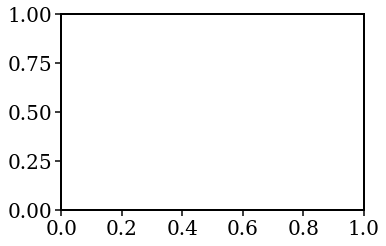

In [2]:
# from src.lib import *
pd.options.mode.chained_assignment = None 
np.warnings.filterwarnings('ignore')

current_dir = '/Volumes/My Passport/TPAGB/'
outcome_dir = 'outcome/'
plot_dir = 'plot/'
numeric_dir = 'numeric/'

plt.tight_layout()
plt.rc('lines', linewidth=3, markersize=2)
plt.rc('font', size=24, family='serif', weight=300)
plt.rc('mathtext', fontset='stix')
plt.rc('axes', linewidth=2)
plt.rc('xtick.major', width=1.5, size=6)
plt.rc('ytick.major', width=1.5, size=6)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.subplots_adjust(bottom=0.2, left=0.2)


In [3]:
def find_nearest(array, value):
    idx = np.argmin(np.abs(array-value))
    return idx
BC_ML = pd.read_csv('/Volumes/My Passport/bc03/src/bc2003_hr_stelib_m62_salp_ssp_1Gyr_csp.4color', delim_whitespace=True, header=None, comment='#', index_col=False)
BC_ML.columns = ['log_age_yr', 'Mbol', 'Bmag', 'Vmag', 'Kmag' ,'M_liv', 'M_remnants', 'M_ret_gas', 'M_galaxy' ,\
				'SFR_yr', 'M_liv_M_rem', 'M_tot_Lb', 'M_tot_Lv', 'M_tot_Lk', 'M_liv_Lb', 'M_liv_Lv', 'M_liv_Lk']
BC_mag = pd.read_csv('/Volumes/My Passport/bc03/src/bc2003_hr_stelib_m62_salp_ssp_1Gyr_csp.1color', delim_whitespace=True, header=None, comment='#', index_col=False)
BC_mag.columns = ['log_age_yr', 'Mbol', 'Umag','Bmag', 'Vmag', 'Kmag' ,'14-V', '17-V', '22-V', '27-V' ,\
				'U-J', 'J-F', 'F-N', 'U-B', 'B-V' ]

M05_ML = pd.read_csv('/Volumes/My Passport/M05_ml_SSP_SDSS.tab.txt', delim_whitespace=True, header=None, comment='#', index_col=False)
M05_ML.columns = ['ZH','t','u','g','r','i','z']
M05_ML_002 = M05_ML[M05_ML.ZH==0.0]

M05_ML_JC = pd.read_csv('/Volumes/My Passport/M05_ml_SSP.tab.txt', delim_whitespace=True, header=None, comment='#', index_col=False)
M05_ML_JC.columns = ['ZH','t',"Bol", 'U', 'B', 'V', 'R', 'I', 'J', 'H', 'K']
M05_ML_002_JC = M05_ML_JC[M05_ML_JC.ZH==0.0]
M05_ML_002_JC = M05_ML_002_JC[:67]

M05_mag = pd.read_csv('/Volumes/My Passport/SSPmags_Mar05_JohnsonCousins.tab', delim_whitespace=True, header=None, comment='#', index_col=False)
M05_mag.columns=['ZH','t',"Bol", 'U', 'B', 'V', 'R', 'I', 'J', 'H', 'K']
def best_model(df_opt,df_photometry,df_cat,df_fast,field):
    """
    input the dataframe
    Return the model with the best-fit values
    """
    #df_opt = df
    df_opt['field'] = field
    for i in range(len(df_opt)):
        ID = int(df_opt.iloc[i].ID)
        #print('ID',ID)
        #print(df_photometry.iloc[ID-1].f_F160W)
        #print(df_photometry.iloc[ID-1].e_F160W)
        if df_opt.iloc[i].model == 1 and df_opt.iloc[i].x2_spectra_M05_opt > 0.5 and df_opt.iloc[i].x2_M05 <60:
#             df_opt.loc[i,'age_opt'] = df_opt.iloc[i].M05_age_opt
#             df_opt.loc[i,'age_opt_std'] = df_opt.iloc[i].M05_age_std
#             df_opt.loc[i,'AV_opt'] = df_opt.iloc[i].M05_AV_opt
#             df_opt.loc[i,'AV_opt_std'] = df_opt.iloc[i].M05_AV_std
            m_AB_K = -2.5*np.log10(df_cat.iloc[ID-1].L163)+25.0
            M_AB_K = m_AB_K - df_cat.iloc[ID-1].DM-df_opt.iloc[i].AV_opt
            df_opt.loc[i,'M_K'] = M_AB_K
            galaxy_age = df_opt.iloc[i].M05_age_opt
            ML_K_index = find_nearest(BC_ML.log_age_yr.unique(), np.log10(galaxy_age*1e9))
            Intensity_ratio = 10**(-0.4*(M_AB_K-5.08))
            ML_K = BC_ML.iloc[ML_K_index].M_tot_Lk
            BC_mass = Intensity_ratio*ML_K
            df_opt.loc[i,'BC_ML'] = ML_K
            df_opt.loc[i,'BC_mass'] = BC_mass
            ML_K_index = find_nearest(M05_ML_002_JC.t.unique(), galaxy_age)
            ML_K = M05_ML_002_JC.iloc[ML_K_index].K
            df_opt.loc[i,'M05_ML'] = ML_K
            M05_mass = Intensity_ratio*ML_K
            df_opt.loc[i,'M05_mass'] = M05_mass
            df_opt.loc[i,'M13_mass'] = M05_mass
            df_opt.loc[i,'best_mass'] = M05_mass
            df_opt.loc[i,'radius'] = df_photometry.iloc[ID-1].a_image
            df_opt.loc[i,'use_phot'] = df_photometry.iloc[ID-1].use_phot
            df_opt.loc[i,'z_best'] = df_cat.iloc[ID-1].z_best
            df_opt.loc[i,'z_type'] = df_cat.iloc[ID-1].z_type
            df_opt.loc[i,'z_spec'] = df_cat.iloc[ID-1].z_spec
            df_opt.loc[i,'use_phot'] = df_photometry.iloc[ID-1].use_phot
            u = -2.5*np.log10(df_cat.iloc[ID-1].L156)+25
            r = -2.5*np.log10(df_cat.iloc[ID-1].L158)+25
            Mu = u - df_cat.iloc[ID-1].DM
            Mr = r - df_cat.iloc[ID-1].DM
            df_opt.loc[i,'U'] = -2.5*np.log10(df_cat.iloc[ID-1].L153)+25
            df_opt.loc[i,'V'] = -2.5*np.log10(df_cat.iloc[ID-1].L155)+25
            df_opt.loc[i,'J'] = -2.5*np.log10(df_cat.iloc[ID-1].L161)+25
            df_opt.loc[i, 'H'] = -2.5*np.log10(df_cat.iloc[ID-1].L162)+25
            df_opt.loc[i,'B'] = -2.5*np.log10(df_cat.iloc[ID-1].L136)+25
            df_opt.loc[i,'K'] = -2.5*np.log10(df_cat.iloc[ID-1].L163)+25
            df_opt.loc[i,'u'] = u
            df_opt.loc[i,'r'] = r
            df_opt.loc[i,'Mr'] = Mr
            df_opt.loc[i,'color'] = u - r
            df_opt.loc[i, 'FAST_mass'] = df_fast.iloc[ID-1].lmass
            df_opt.loc[i, 'SFR'] = df_fast.iloc[ID-1].lsfr
            df_opt.loc[i, 'sSFR'] = df_fast.iloc[ID-1].lssfr
            df_opt.loc[i, 'ltau'] = df_fast.iloc[ID-1].ltau
            df_opt.loc[i, 'SNR_F160W'] = df_photometry.iloc[ID-1].f_F160W/df_photometry.iloc[ID-1].e_F160W
            df_opt.loc[i, 'SNR_F140W'] = df_photometry.iloc[ID-1].f_F140W/df_photometry.iloc[ID-1].e_F140W
            df_opt.loc[i, 'SNR_F125W'] = df_photometry.iloc[ID-1].f_F125W/df_photometry.iloc[ID-1].e_F125W
            #df_opt.loc[i, 'SNR_F814W'] = df_photometry.iloc[ID-1].f_F814W/df_photometry.iloc[ID-1].e_F814W
            df_opt.loc[i, 'SNR_F606W'] = df_photometry.iloc[ID-1].f_F606W/df_photometry.iloc[ID-1].e_F606W
            df_opt.loc[i, 'F160W_mag'] = -2.5*np.log10(df_photometry.iloc[ID-1].f_F160W)+25
            df_opt.loc[i, 'F140W_mag'] = -2.5*np.log10(df_photometry.iloc[ID-1].f_F140W)+25
            df_opt.loc[i, 'F125W_mag'] = -2.5*np.log10(df_photometry.iloc[ID-1].f_F125W)+25
            #df_opt.loc[i, 'F814W_mag'] = -2.5*np.log10(df_photometry.iloc[ID-1].f_F814W)+25
            df_opt.loc[i, 'F606W_mag'] = -2.5*np.log10(df_photometry.iloc[ID-1].f_F606W)+25
        elif df_opt.iloc[i].model == 2 and df_opt.iloc[i].x2_spectra_M13_opt > 0.5 and df_opt.iloc[i].x2_M13 <60:
#             df_opt.loc[i,'age_opt'] = df_opt.iloc[i].M13_age_opt
#             df_opt.loc[i,'age_opt_std'] = df_opt.iloc[i].M13_age_std
#             df_opt.loc[i,'AV_opt'] = df_opt.iloc[i].M13_AV_opt
#             df_opt.loc[i,'AV_opt_std'] = df_opt.iloc[i].M13_AV_std
            m_AB_K = -2.5*np.log10(df_cat.iloc[ID-1].L163)+25.0
            M_AB_K = m_AB_K - df_cat.iloc[ID-1].DM-df_opt.iloc[i].AV_opt
            df_opt.loc[i,'M_K'] = M_AB_K
            galaxy_age = df_opt.iloc[i].M13_age_opt
            Intensity_ratio = 10**(-0.4*(M_AB_K-5.08))
            ML_K_index = find_nearest(BC_ML.log_age_yr.unique(), np.log10(galaxy_age*1e9))
            ML_K = BC_ML.iloc[ML_K_index].M_tot_Lk
            BC_mass = Intensity_ratio*ML_K
            df_opt.loc[i,'BC_ML'] = ML_K
            df_opt.loc[i,'BC_mass'] = BC_mass
            ML_K_index = find_nearest(M05_ML_002_JC.t.unique(), galaxy_age)
            ML_K = M05_ML_002_JC.iloc[ML_K_index].K
            df_opt.loc[i,'M05_ML'] = ML_K
            M05_mass = Intensity_ratio*ML_K
            df_opt.loc[i,'M05_mass'] = M05_mass
            df_opt.loc[i,'M13_mass'] = M05_mass
            df_opt.loc[i,'best_mass'] = M05_mass
            df_opt.loc[i,'radius'] = df_photometry.iloc[ID-1].a_image
            df_opt.loc[i,'use_phot'] = df_photometry.iloc[ID-1].use_phot
            df_opt.loc[i,'z_best'] = df_cat.iloc[ID-1].z_best
            df_opt.loc[i,'z_type'] = df_cat.iloc[ID-1].z_type
            df_opt.loc[i,'z_spec'] = df_cat.iloc[ID-1].z_spec
            df_opt.loc[i,'use_phot'] = df_photometry.iloc[ID-1].use_phot
            u = -2.5*np.log10(df_cat.iloc[ID-1].L156)+25
            r = -2.5*np.log10(df_cat.iloc[ID-1].L158)+25
            Mu = u - df_cat.iloc[ID-1].DM
            Mr = r - df_cat.iloc[ID-1].DM
            df_opt.loc[i,'U'] = -2.5*np.log10(df_cat.iloc[ID-1].L153)+25
            df_opt.loc[i,'V'] = -2.5*np.log10(df_cat.iloc[ID-1].L155)+25
            df_opt.loc[i,'J'] = -2.5*np.log10(df_cat.iloc[ID-1].L161)+25
            df_opt.loc[i, 'H'] = -2.5*np.log10(df_cat.iloc[ID-1].L162)+25
            df_opt.loc[i, 'B'] = -2.5 * np.log10(df_cat.iloc[ID - 1].L136) + 25
            df_opt.loc[i, 'K'] = -2.5 * np.log10(df_cat.iloc[ID - 1].L163) + 25
            df_opt.loc[i,'u'] = u
            df_opt.loc[i,'r'] = r
            df_opt.loc[i,'Mr'] = Mr
            df_opt.loc[i,'color'] = u - r
            df_opt.loc[i, 'FAST_mass'] = df_fast.iloc[ID-1].lmass
            df_opt.loc[i, 'SFR'] = df_fast.iloc[ID-1].lsfr
            df_opt.loc[i, 'sSFR'] = df_fast.iloc[ID-1].lssfr
            df_opt.loc[i, 'ltau'] = df_fast.iloc[ID-1].ltau
            df_opt.loc[i, 'SNR_F160W'] = df_photometry.iloc[ID-1].f_F160W/df_photometry.iloc[ID-1].e_F160W
            df_opt.loc[i, 'SNR_F140W'] = df_photometry.iloc[ID-1].f_F140W/df_photometry.iloc[ID-1].e_F140W
            df_opt.loc[i, 'SNR_F125W'] = df_photometry.iloc[ID-1].f_F125W/df_photometry.iloc[ID-1].e_F125W
            #df_opt.loc[i, 'SNR_F814W'] = df_photometry.iloc[ID-1].f_F814W/df_photometry.iloc[ID-1].e_F814W
            df_opt.loc[i, 'SNR_F606W'] = df_photometry.iloc[ID-1].f_F606W/df_photometry.iloc[ID-1].e_F606W
            df_opt.loc[i, 'F160W_mag'] = -2.5*np.log10(df_photometry.iloc[ID-1].f_F160W)+25
            df_opt.loc[i, 'F140W_mag'] = -2.5*np.log10(df_photometry.iloc[ID-1].f_F140W)+25
            df_opt.loc[i, 'F125W_mag'] = -2.5*np.log10(df_photometry.iloc[ID-1].f_F125W)+25
            #df_opt.loc[i, 'F814W_mag'] = -2.5*np.log10(df_photometry.iloc[ID-1].f_F814W)+25
            df_opt.loc[i, 'F606W_mag'] = -2.5*np.log10(df_photometry.iloc[ID-1].f_F606W)+25
        elif df_opt.iloc[i].model == 3 and df_opt.iloc[i].x2_spectra_BC_opt > 0.5 and df_opt.iloc[i].x2_BC <60:
#             df_opt.loc[i,'age_opt'] = df_opt.iloc[i].BC_age_opt
#             df_opt.loc[i,'age_opt_std'] = df_opt.iloc[i].BC_age_std
#             df_opt.loc[i,'AV_opt'] = df_opt.iloc[i].BC_AV_opt
#             df_opt.loc[i,'AV_opt_std'] = df_opt.iloc[i].BC_AV_std
            m_AB_K = -2.5*np.log10(df_cat.loc[ID-1].L163)+25.0
            M_AB_K = m_AB_K - df_cat.loc[ID-1].DM-df_opt.iloc[i].AV_opt
            df_opt.loc[i,'M_K'] = M_AB_K
            galaxy_age = df_opt.iloc[i].BC_age_opt
            Intensity_ratio = 10**(-0.4*(M_AB_K-5.08))
            ML_K_index = find_nearest(BC_ML.log_age_yr.unique(), np.log10(galaxy_age*1e9))
            ML_K = BC_ML.iloc[ML_K_index].M_tot_Lk
            BC_mass = Intensity_ratio*ML_K
            df_opt.loc[i,'BC_ML'] = ML_K
            df_opt.loc[i,'BC_mass'] = BC_mass
            ML_K_index = find_nearest(M05_ML_002_JC.t.unique(), galaxy_age)
            ML_K = M05_ML_002_JC.iloc[ML_K_index].K
            df_opt.loc[i,'M05_ML'] = ML_K
            M05_mass = Intensity_ratio*ML_K
            df_opt.loc[i,'M05_mass'] = M05_mass
            df_opt.loc[i,'M13_mass'] = M05_mass
            df_opt.loc[i,'best_mass'] = M05_mass
            df_opt.loc[i,'radius'] = df_photometry.iloc[ID-1].a_image
            df_opt.loc[i,'use_phot'] = df_photometry.iloc[ID-1].use_phot
            df_opt.loc[i,'z_best'] = df_cat.iloc[ID-1].z_best
            df_opt.loc[i,'z_type'] = df_cat.iloc[ID-1].z_type
            df_opt.loc[i,'z_spec'] = df_cat.iloc[ID-1].z_spec
            df_opt.loc[i,'use_phot'] = df_photometry.iloc[ID-1].use_phot
            u = -2.5*np.log10(df_cat.iloc[ID-1].L156)+25
            r = -2.5*np.log10(df_cat.iloc[ID-1].L158)+25
            Mu = u - df_cat.iloc[ID-1].DM
            Mr = r - df_cat.iloc[ID-1].DM
            df_opt.loc[i,'U'] = -2.5*np.log10(df_cat.iloc[ID-1].L153)+25
            df_opt.loc[i,'V'] = -2.5*np.log10(df_cat.iloc[ID-1].L155)+25
            df_opt.loc[i,'J'] = -2.5*np.log10(df_cat.iloc[ID-1].L161)+25
            df_opt.loc[i, 'H'] = -2.5*np.log10(df_cat.iloc[ID-1].L162)+25
            df_opt.loc[i, 'B'] = -2.5 * np.log10(df_cat.iloc[ID - 1].L136) + 25
            df_opt.loc[i, 'K'] = -2.5 * np.log10(df_cat.iloc[ID - 1].L163) + 25
            df_opt.loc[i,'u'] = u
            df_opt.loc[i,'r'] = r
            df_opt.loc[i,'Mr'] = Mr
            df_opt.loc[i,'color'] = u - r
            df_opt.loc[i, 'FAST_mass'] = df_fast.iloc[ID-1].lmass
            df_opt.loc[i, 'SFR'] = df_fast.iloc[ID-1].lsfr
            df_opt.loc[i, 'sSFR'] = df_fast.iloc[ID-1].lssfr
            df_opt.loc[i, 'ltau'] = df_fast.iloc[ID-1].ltau
            df_opt.loc[i, 'SNR_F160W'] = df_photometry.iloc[ID-1].f_F160W/df_photometry.iloc[ID-1].e_F160W
            df_opt.loc[i, 'SNR_F140W'] = df_photometry.iloc[ID-1].f_F140W/df_photometry.iloc[ID-1].e_F140W
            df_opt.loc[i, 'SNR_F125W'] = df_photometry.iloc[ID-1].f_F125W/df_photometry.iloc[ID-1].e_F125W
            #df_opt.loc[i, 'SNR_F814W'] = df_photometry.iloc[ID-1].f_F814W/df_photometry.iloc[ID-1].e_F814W
            df_opt.loc[i, 'SNR_F606W'] = df_photometry.iloc[ID-1].f_F606W/df_photometry.iloc[ID-1].e_F606W
            df_opt.loc[i, 'F160W_mag'] = -2.5*np.log10(df_photometry.iloc[ID-1].f_F160W)+25
            df_opt.loc[i, 'F140W_mag'] = -2.5*np.log10(df_photometry.iloc[ID-1].f_F140W)+25
            df_opt.loc[i, 'F125W_mag'] = -2.5*np.log10(df_photometry.iloc[ID-1].f_F125W)+25
            #df_opt.loc[i, 'F814W_mag'] = -2.5*np.log10(df_photometry.iloc[ID-1].f_F814W)+25
            df_opt.loc[i, 'F606W_mag'] = -2.5*np.log10(df_photometry.iloc[ID-1].f_F606W)+25
    # dropping the IDs
    drop_index = []
    for i in df_opt.index:
        #try:
        ID = int(df_opt.iloc[i].ID)
        if df_photometry.iloc[ID-1].class_star>0.8:
            drop_index.append(i)
            print('drop due to class_star',ID)
    print('Dropping index list', field, drop_index)
    df_opt = df_opt.drop(drop_index)
    df_opt = df_opt.fillna(0.0)
    df_opt = df_opt[df_opt.U!=0.0]
    #index_to_drop = np.where(df_photometry.class_star>0.8)[0]
    #print(df_photometry.iloc[index_to_drop].ID)
    #df_opt = df_opt.drop([i for i in df_opt.index if i in index_to_drop])
    return df_opt


In [4]:
aegis_photometry = pd.read_csv('/Volumes/My Passport/aegis_3dhst.v4.1.cats/Catalog/aegis_3dhst.v4.1.cat',
                               delim_whitespace=True, header=None, comment='#', index_col=False)
aegis_photometry.columns = ["id", "x", "y", "ra", "dec", "faper_F160W", "eaper_F160W", "faper_F140W", "eaper_F140W",
                            "f_F160W", "e_F160W", "w_F160W", "f_U", "e_U", "w_U", "f_G", "e_G", "w_G", "f_F606W",
                            "e_F606W", "w_F606W", "f_R", "e_R", "w_R", "f_I", "e_I", "w_I", "f_F814W", "e_F814W",
                            "w_F814W", "f_Z", "e_Z", "w_Z", "f_F125W", "e_F125W", "w_F125W", "f_J1", "e_J1", "w_J1",
                            "f_J2", "e_J2", "w_J2", "f_J3", "e_J3", "w_J3", "f_J", "e_J", "w_J", "f_F140W", "e_F140W",
                            "w_F140W", "f_H1", "e_H1", "w_H1", "f_H2", "e_H2", "w_H2", "f_H", "e_H", "w_H", "f_K",
                            "e_K", "w_K", "f_Ks", "e_Ks", "w_Ks", "f_IRAC1", "e_IRAC1", "w_IRAC1", "f_IRAC2", "e_IRAC2",
                            "w_IRAC2", "f_IRAC3", "e_IRAC3", "w_IRAC3", "f_IRAC4", "e_IRAC4", "w_IRAC4", "tot_cor",
                            "wmin_ground", "wmin_hst", "wmin_irac", "wmin_wfc3", "z_spec", "star_flag", "kron_radius",
                            "a_image", "b_image", "theta_J2000", "class_star", "flux_radius", "fwhm_image", "flags",
                            "IRAC1_contam", "IRAC2_contam", "IRAC3_contam", "IRAC4_contam", "contam_flag", "f140w_flag",
                            "use_phot", "near_star", "nexp_f125w", "nexp_f140w", "nexp_f160w"]
# aegis_photometry= aegis_photometry.set_index('id')
aegis_cat = pd.read_csv('/Volumes/My Passport/aegis_3dhst_v4.1.5_catalogs/aegis_3dhst.v4.1.5.zbest.rf',
                        delim_whitespace=True, header=None, comment='#', index_col=False)
aegis_cat.columns = ["id", "z_best", "z_type", "z_spec", "DM", "L153", "nfilt153", "L154", "nfilt154", "L155",
                     "nfilt155", "L161", "nfilt161", "L162", "nfilt162", "L163", "nfilt163", "L156", "nfilt156", "L157",
                     "nfilt157", "L158", "nfilt158", "L159", "nfilt159", "L160", "nfilt160", "L135", "nfilt135", "L136",
                     "nfilt136", "L137", "nfilt137", "L138", "nfilt138", "L139", "nfilt139", "L270", "nfilt270", "L271",
                     "nfilt271", "L272", "nfilt272", "L273", "nfilt273", "L274", "nfilt274", "L275", "nfilt275"]
# aegis_cat= aegis_cat.set_index('id')
aegis_fast = pd.read_csv('/Volumes/My Passport/aegis_3dhst.v4.1.cats/Fast/aegis_3dhst.v4.1.fout', delim_whitespace=True,
                         header=None, comment='#', index_col=False)
aegis_fast.columns = ['id', 'z', 'ltau', 'metal', 'lage', 'Av', 'lmass', 'lsfr', 'lssfr', 'la2t', 'chi2']
# aegis_fast = aegis_fast.set_index('id')

cosmos_photometry = pd.read_csv('/Volumes/My Passport/cosmos_3dhst.v4.1.cats/Catalog/cosmos_3dhst.v4.1.cat',
                                delim_whitespace=True, header=None, comment='#', index_col=False)
cosmos_photometry.columns = ["id", "x", "y", "ra", "dec", "faper_F160W", "eaper_F160W", "faper_F140W", "eaper_F140W",
                             "f_F160W", "e_F160W", "w_F160W",
                             "f_U", "e_U", "w_U", "f_B", "e_B", "w_B", "f_G", "e_G", "w_G", "f_V", "e_V", "w_V",
                             "f_F606W", "e_F606W", "w_F606W", "f_R", "e_R", "w_R", "f_Rp", "e_Rp", "w_Rp", "f_I", "e_I",
                             "w_I", "f_Ip", "e_Ip", "w_Ip", "f_F814W", "e_F814W", "w_F814W", "f_Z", "e_Z", "w_Z",
                             "f_Zp", "e_Zp", "w_Zp", "f_UVISTA_Y", "e_UVISTA_Y", "w_UVISTA_Y", "f_F125W", "e_F125W",
                             "w_F125W", "f_J1", "e_J1", "w_J1", "f_J2", "e_J2", "w_J2", "f_J3", "e_J3", "w_J3", "f_J",
                             "e_J", "w_J", "f_UVISTA_J", "e_UVISTA_J", "w_UVISTA_J", "f_F140W", "e_F140W", "w_F140W",
                             "f_H1", "e_H1", "w_H1", "f_H2", "e_H2", "w_H2", "f_H", "e_H", "w_H", "f_UVISTA_H",
                             "e_UVISTA_H", "w_UVISTA_H", "f_K", "e_K", "w_K", "f_Ks", "e_Ks", "w_Ks", "f_UVISTA_Ks",
                             "e_UVISTA_Ks", "w_UVISTA_Ks", "f_IRAC1", "e_IRAC1", "w_IRAC1", "f_IRAC2", "e_IRAC2",
                             "w_IRAC2", "f_IRAC3", "e_IRAC3", "w_IRAC3", "f_IRAC4", "e_IRAC4", "w_IRAC4", "f_IA427",
                             "e_IA427", "f_IA464", "e_IA464", "f_IA484", "e_IA484", "f_IA505", "e_IA505", "f_IA527",
                             "e_IA527", "f_IA574", "e_IA574", "f_IA624", "e_IA624", "f_IA679", "e_IA679", "f_IA709",
                             "e_IA709", "f_IA738", "e_IA738", "f_IA767", "e_IA767", "f_IA827", "e_IA827", "tot_cor",
                             "wmin_ground", "wmin_hst", "wmin_irac", "wmin_wfc3", "z_spec", "star_flag", "kron_radius",
                             "a_image", "b_image", "theta_J2000", "class_star", "flux_radius", "fwhm_image", "flags",
                             "IRAC1_contam", "IRAC2_contam", "IRAC3_contam", "IRAC4_contam", "contam_flag",
                             "f140w_flag", "use_phot", "near_star", "nexp_f125w", "nexp_f140w", "nexp_f160w"]
# cosmos_photometry= cosmos_photometry.set_index('id')
cosmos_cat = pd.read_csv('/Volumes/My Passport/cosmos_3dhst_v4.1.5_catalogs/cosmos_3dhst.v4.1.5.zbest.rf',
                         delim_whitespace=True, header=None, comment='#', index_col=False)
cosmos_cat.columns = ["id", "z_best", "z_type", "z_spec", "DM", "L153", "nfilt153", "L154", "nfilt154", "L155",
                      "nfilt155", "L161", "nfilt161", "L162", "nfilt162", "L163", "nfilt163", "L156", "nfilt156",
                      "L157", "nfilt157", "L158", "nfilt158", "L159", "nfilt159",
                      "L160", "nfilt160", "L135", "nfilt135", "L136", "nfilt136", "L137", "nfilt137", "L138",
                      "nfilt138", "L139", "nfilt139",
                      "L270", "nfilt270", "L271", "nfilt271", "L272", "nfilt272", "L273", "nfilt273", "L274",
                      "nfilt274", "L275", "nfilt275"]
# cosmos_cat = cosmos_cat.set_index('id')
cosmos_fast = pd.read_csv('/Volumes/My Passport/cosmos_3dhst.v4.1.cats/Fast/cosmos_3dhst.v4.1.fout',
                          delim_whitespace=True, header=None, comment='#', index_col=False)
cosmos_fast.columns = ['id', 'z', 'ltau', 'metal', 'lage', 'Av', 'lmass', 'lsfr', 'lssfr', 'la2t', 'chi2']
# cosmos_fast = cosmos_fast.set_index('id')

goodsn_photometry = pd.read_csv('/Volumes/My Passport/goodsn_3dhst.v4.1.cats/Catalog/goodsn_3dhst.v4.1.cat',
                                delim_whitespace=True, header=None, comment='#', index_col=False)
goodsn_photometry.columns = ["id", "x", "y", "ra", "dec", "faper_F160W", "eaper_F160W", "faper_F140W", "eaper_F140W",
                             "f_F160W", "e_F160W", "w_F160W", \
                             "f_U", "e_U", "w_U", "f_F435W", "e_F435W", "w_F435W", "f_B", "e_B", "w_B", "f_G", "e_G",
                             "w_G", "f_V", "e_V", "w_V", "f_F606W", "e_F606W", "w_F606W", \
                             "f_R", "e_R", "w_R", "f_Rs", "e_Rs", "w_Rs", "f_I", "e_I", "w_I", \
                             "f_F775W", "e_F775W", "w_F775W", "f_Z", "e_Z", "w_Z", "f_F850LP", "e_F850LP", "w_F850LP", \
                             "f_F125W", "e_F125W", "w_F125W", "f_J", "e_J", "w_J", "f_F140W", "e_F140W", "w_F140W", \
                             "f_H", "e_H", "w_H", "f_Ks", "e_Ks", "w_Ks", "f_IRAC1", "e_IRAC1", "w_IRAC1", "f_IRAC2",
                             "e_IRAC2", "w_IRAC2", \
                             "f_IRAC3", "e_IRAC3", "w_IRAC3", "f_IRAC4", "e_IRAC4", "w_IRAC4", \
                             "tot_cor", "wmin_ground", \
                             "wmin_hst", "wmin_wfc3", "wmin_irac", "z_spec", "star_flag", "kron_radius", \
                             "a_image", "b_image", "theta_J2000", "class_star", "flux_radius", "fwhm_image", \
                             "flags", "IRAC1_contam", "IRAC2_contam", "IRAC3_contam", "IRAC4_contam", "contam_flag", \
                             "f140w_flag", "use_phot", "near_star", "nexp_f125w", "nexp_f140w", "nexp_f160w"]
# goodsn_photometry= goodsn_photometry.set_index('id')
goodsn_cat = pd.read_csv('/Volumes/My Passport/goodsn_3dhst_v4.1.5_catalogs/goodsn_3dhst.v4.1.5.zbest.rf',
                         delim_whitespace=True, header=None, comment='#', index_col=False)
goodsn_cat.columns = ["id", "z_best", "z_type", "z_spec", "DM", "L153", "nfilt153", "L154", "nfilt154", "L155",
                      "nfilt155", "L161", "nfilt161", "L162", "nfilt162", "L163", \
                      "nfilt163", "L156", "nfilt156", "L157", "nfilt157", "L158", "nfilt158", "L159", "nfilt159",
                      "L160", "nfilt160", "L135", "nfilt135", "L136", "nfilt136", \
                      "L137", "nfilt137", "L138", "nfilt138", "L139", "nfilt139", "L270", "nfilt270", "L271",
                      "nfilt271", "L272", "nfilt272", "L273", "nfilt273", "L274", "nfilt274", "L275", "nfilt275"]
# goodsn_cat = goodsn_cat.set_index('id')
goodsn_fast = pd.read_csv('/Volumes/My Passport/goodsn_3dhst.v4.1.cats/Fast/goodsn_3dhst.v4.1.fout',
                          delim_whitespace=True, header=None, comment='#', index_col=False)
goodsn_fast.columns = ['id', 'z', 'ltau', 'metal', 'lage', 'Av', 'lmass', 'lsfr', 'lssfr', 'la2t', 'chi2']
# goodsn_fast = goodsn_fast.set_index('id')

goodss_photometry = pd.read_csv('/Volumes/My Passport/goodss_3dhst.v4.1.cats/Catalog/goodss_3dhst.v4.1.cat',
                                delim_whitespace=True, header=None, comment='#', index_col=False)
goodss_photometry.columns = ["id", "x", "y", "ra", "dec", "faper_F160W", "eaper_F160W", "faper_F140W", "eaper_F140W",
                             "f_F160W", "e_F160W", "w_F160W", \
                             "f_U38", "e_U38", "w_U38", "f_U", "e_U", "w_U", "f_F435W", "e_F435W", "w_F435W", "f_B",
                             "e_B", "w_B", "f_V", "e_V", "w_V", \
                             "f_F606Wcand", "e_F606Wcand", "w_F606Wcand", "f_F606W", "e_F606W", "w_F606W", "f_R", "e_R",
                             "w_R", "f_Rc", "e_Rc", "w_Rc", \
                             "f_F775W", "e_F775W", "w_F775W", "f_I", "e_I", "w_I", "f_F814Wcand", "e_F814Wcand",
                             "w_F814Wcand", "f_F850LP", "e_F850LP", "w_F850LP", \
                             "f_F850LPcand", "e_F850LPcand", "w_F850LPcand", "f_F125W", "e_F125W", "w_F125W", "f_J",
                             "e_J", "w_J", "f_tenisJ", "e_tenisJ", "w_tenisJ", \
                             "f_F140W", "e_F140W", "w_F140W", "f_H", "e_H", "w_H", "f_tenisK", "e_tenisK", "w_tenisK",
                             "f_Ks", "e_Ks", "w_Ks", \
                             "f_IRAC1", "e_IRAC1", "w_IRAC1", "f_IRAC2", "e_IRAC2", "w_IRAC2", "f_IRAC3", "e_IRAC3",
                             "w_IRAC3", "f_IRAC4", "e_IRAC4", "w_IRAC4", \
                             "f_IA427", "e_IA427", "f_IA445", "e_IA445", "f_IA505", "e_IA505", "f_IA527", "e_IA527",
                             "f_IA550", "e_IA550", "f_IA574", "e_IA574", \
                             "f_IA598", "e_IA598", "f_IA624", "e_IA624", "f_IA651", "e_IA651", "f_IA679", "e_IA679",
                             "f_IA738", "e_IA738", "f_IA767", "e_IA767", \
                             "f_IA797", "e_IA797", "f_IA856", "e_IA856", "tot_cor", "wmin_ground", "wmin_hst",
                             "wmin_wfc3", "wmin_irac", "z_spec", "star_flag", \
                             "kron_radius", "a_image", "b_image", "theta_J2000", "class_star", "flux_radius",
                             "fwhm_image", "flags", "IRAC1_contam", "IRAC2_contam", \
                             "IRAC3_contam", "IRAC4_contam", "contam_flag", "f140w_flag", "use_phot", "near_star",
                             "nexp_f125w", "nexp_f140w", "nexp_f160w"]
# goodss_photometry = goodss_photometry.set_index('id')
goodss_cat = pd.read_csv('/Volumes/My Passport/goodss_3dhst_v4.1.5_catalogs/goodss_3dhst.v4.1.5.zbest.rf',
                         delim_whitespace=True, header=None, comment='#', index_col=False)
goodss_cat.columns = ["id", "z_best", "z_type", "z_spec", "DM", "L153", "nfilt153", "L154", "nfilt154", "L155",
                      "nfilt155", "L161", "nfilt161", "L162", "nfilt162", \
                      "L163", "nfilt163", "L156", "nfilt156", "L157", "nfilt157", "L158", "nfilt158", "L159",
                      "nfilt159", "L160", "nfilt160", "L135", "nfilt135", "L136", "nfilt136", \
                      "L137", "nfilt137", "L138", "nfilt138", "L139", "nfilt139", "L270", "nfilt270", "L271",
                      "nfilt271", "L272", "nfilt272", "L273", "nfilt273", "L274", "nfilt274", "L275", "nfilt275"]
# goodss_cat = goodss_cat.set_index('id')
goodss_fast = pd.read_csv('/Volumes/My Passport/goodss_3dhst.v4.1.cats/Fast/goodss_3dhst.v4.1.fout',
                          delim_whitespace=True, header=None, comment='#', index_col=False)
goodss_fast.columns = ['id', 'z', 'ltau', 'metal', 'lage', 'Av', 'lmass', 'lsfr', 'lssfr', 'la2t', 'chi2']
# goodss_fast = goodss_fast.set_index('id')

uds_photometry = pd.read_csv('/Volumes/My Passport/uds_3dhst.v4.2.cats/Catalog/uds_3dhst.v4.2.cat',
                             delim_whitespace=True, header=None, comment='#', index_col=False)
uds_photometry.columns = ["id", "x", "y", "ra", "dec", "faper_F160W", "eaper_F160W", "faper_F140W", "eaper_F140W",
                          "f_F160W", "e_F160W", "w_F160W", \
                          "f_u", "e_u", "w_u", "f_B", "e_B", "w_B", "f_V", "e_V", "w_V", "f_F606W", "e_F606W",
                          "w_F606W", \
                          "f_R", "e_R", "w_R", "f_i", "e_i", "w_i", "f_F814W", "e_F814W", "w_F814W", "f_z", "e_z",
                          "w_z", \
                          "f_F125W", "e_F125W", "w_F125W", "f_J", "e_J", "w_J", "f_F140W", "e_F140W", "w_F140W", \
                          "f_H", "e_H", "w_H", "f_K", "e_K", "w_K", "f_IRAC1", "e_IRAC1", "w_IRAC1", "f_IRAC2",
                          "e_IRAC2", "w_IRAC2", \
                          "f_IRAC3", "e_IRAC3", "w_IRAC3", "f_IRAC4", "e_IRAC4", "w_IRAC4", "tot_cor", "wmin_ground",
                          "wmin_hst", "wmin_wfc3", \
                          "wmin_irac", "z_spec", "star_flag", "kron_radius", "a_image", "b_image", "theta_J2000",
                          "class_star", "flux_radius", "fwhm_image", \
                          "flags", "IRAC1_contam", "IRAC2_contam", "IRAC3_contam", "IRAC4_contam", "contam_flag",
                          "f140w_flag", "use_phot", "near_star", "nexp_f125w", "nexp_f140w", "nexp_f160w"]
# uds_photometry = uds_photometry.set_index('id')
uds_cat = pd.read_csv('/Volumes/My Passport/uds_3dhst_v4.1.5_catalogs/uds_3dhst.v4.1.5.zbest.rf', delim_whitespace=True,
                      header=None, comment='#', index_col=False)
uds_cat.columns = ["id", "z_best", "z_type", "z_spec", "DM", "L153", "nfilt153", "L154", "nfilt154", "L155", "nfilt155",
                   "L161", "nfilt161", "L162", "nfilt162", \
                   "L163", "nfilt163", "L156", "nfilt156", "L157", "nfilt157", "L158", "nfilt158", "L159", "nfilt159",
                   "L160", "nfilt160", "L135", "nfilt135", "L136", "nfilt136", \
                   "L137", "nfilt137", "L138", "nfilt138", "L139", "nfilt139", "L270", "nfilt270", "L271", "nfilt271",
                   "L272", "nfilt272", "L273", "nfilt273", "L274", "nfilt274", "L275", "nfilt275"]
# uds_cat = uds_cat.set_index('id')
uds_fast = pd.read_csv('/Volumes/My Passport/uds_3dhst.v4.2.cats/Fast/uds_3dhst.v4.2.fout', delim_whitespace=True,
                       header=None, comment='#', index_col=False)
uds_fast.columns = ['id', 'z', 'ltau', 'metal', 'lage', 'Av', 'lmass', 'lsfr', 'lssfr', 'la2t', 'chi2']



In [5]:
All_opt = pd.read_csv('/Volumes/My Passport/TPAGB/database/sourcelist_20200702_smooth.csv')
All_opt = All_opt.reset_index(drop=True)
# All_opt = All_opt.drop(columns='Unnamed: 0')

aegis_opt = All_opt[All_opt.field=='aegis']
aegis_opt = aegis_opt.reset_index(drop=True)
cosmos_opt = All_opt[All_opt.field=='cosmos']
cosmos_opt = cosmos_opt.reset_index(drop=True)
goodsn_opt = All_opt[All_opt.field=='goodsn']
goodsn_opt = goodsn_opt.reset_index(drop=True)
goodss_opt = All_opt[All_opt.field=='goodss']
goodss_opt = goodss_opt.reset_index(drop=True)
uds_opt = All_opt[All_opt.field=='uds']
uds_opt = uds_opt.reset_index(drop=True)
# uds_opt

In [6]:
len(All_opt)

336

In [7]:
# 3 Define the functions


def SSP_BC_CN(BC_ssp,bin_size=1):
    for i in range(len(BC03_age_list)):
        galaxy_age_1 = float(BC03_age_list[i])/1e9
        age_index_1 = find_nearest(BC03_age_list_num, galaxy_age_1)
        model3_flux_1 = BC03_flux_array[age_index_1, :7125]   
        BC03_flux_attenuated_1 = model3_flux_1#*spectra_flux_correction
        BC03_flux_norm_1 = BC03_flux_attenuated_1[2556]
        BC03_flux_attenuated_1 = BC03_flux_attenuated_1/BC03_flux_norm_1

        BC03_wave_list_num_binned,BC03_flux_attenuated_binned=binning_spec_keep_shape(BC03_wave_list_num, BC03_flux_attenuated_1,bin_size)
        
        BC_ssp[i]=Lick_index_ratio(BC03_wave_list_num_binned, BC03_flux_attenuated_binned)

    return BC_ssp
def SSP_BC_CN_smoothed(BC_ssp,kernel=1):
    for i in range(len(BC03_age_list)):
        galaxy_age_1 = float(BC03_age_list[i])/1e9
        age_index_1 = find_nearest(BC03_age_list_num, galaxy_age_1)
        model3_flux_1 = BC03_flux_array[age_index_1, :7125]   
        BC03_flux_attenuated_1 = model3_flux_1#*spectra_flux_correction
        BC03_flux_norm_1 = BC03_flux_attenuated_1[2556]
        BC03_flux_attenuated_1 = BC03_flux_attenuated_1/BC03_flux_norm_1

        #kernel = 3
        g = Gaussian1DKernel(stddev=kernel)
        BC03_flux_attenuated_smoothed  = convolve(BC03_flux_attenuated_1, g)
        #BC03_flux_attenuated_binned=binning_spec_keep_shape(BC03_wave_list_num, BC03_flux_attenuated_1,bin_size)
        
        BC_ssp[i]=Lick_index_ratio(BC03_wave_list_num, BC03_flux_attenuated_smoothed)        

    return BC_ssp

def SSP_M05_CN(M05_SSP,bin_size=1):
    index_age = 0
    for i in range(len(df_Ma.Age.unique())):
        galaxy_age_1 = df_Ma.Age.unique()[i]
        #galaxy_age_2 = 10
        age_index_1 = find_nearest(df_Ma.Age.unique(), galaxy_age_1)
        age_prior = df_Ma.Age.unique()[age_index_1]
        galaxy_age_string = str(age_prior)
        split_galaxy_age_string = str(galaxy_age_string).split('.')

        #### Galaxy_age_1
        galaxy_age = galaxy_age_1
        if age_prior < 1:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_'+'0_'+split_galaxy_age_string[1]+'_Av_00_z002.csv'
            model1 = np.genfromtxt(fn1)
        elif age_prior == 1.5:
            if galaxy_age >=1.25 and galaxy_age <1.5:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_1_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M05_age_1_5_Av_00_z002.csv'
                #print(fn1, fn2)
                model1 = 2.*(1.5-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 1.5 and galaxy_age < 1.75:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_1_5_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M05_age_2_Av_00_z002.csv'
                #print(fn1, fn2)
                model1 = 2.*(2.0-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.5)*np.genfromtxt(fn2)
        elif len(split_galaxy_age_string[1])==1:
            if galaxy_age >= 1.0 and galaxy_age < 1.25:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_1_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M05_age_1_5_Av_00_z002.csv'
                #print(fn1, fn2)
                model1 = 2.*(1.5-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.0)*np.genfromtxt(fn2)
            elif galaxy_age >=1.75 and galaxy_age < 2.0:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_1_5_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M05_age_2_Av_00_z002.csv'
                #print(fn1, fn2)
                model1 = 2.*(2.0-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.5)*np.genfromtxt(fn2)
            elif galaxy_age >= 2.0 and galaxy_age < 3.0:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_2_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M05_age_3_Av_00_z002.csv'
                #print(fn1, fn2)
                model1 = (3.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-2.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 3.0 and galaxy_age < 4.0:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_3_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M05_age_4_Av_00_z002.csv'
                #print(fn1, fn2)
                model1 = (4.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-3.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 4.0 and galaxy_age < 5.0:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_4_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M05_age_5_Av_00_z002.csv'
                #print(fn1, fn2)
                model1 = (5.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-4.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 5.0 and galaxy_age < 6.0:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_5_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M05_age_6_Av_00_z002.csv'
                #print(fn1, fn2)
                model1 = (6.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-5.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 6.0 and galaxy_age < 7.0:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_6_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M05_age_7_Av_00_z002.csv'
                #print(fn1, fn2)
                model1 = (7.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-6.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 7.0 and galaxy_age < 8.0:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_7_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M05_age_8_Av_00_z002.csv'
                #print(fn1, fn2)
                model1 = (8.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-7.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 8.0 and galaxy_age < 9.0:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_8_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M05_age_9_Av_00_z002.csv'
                #print(fn1, fn2)
                model1 = (9.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-8.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 9.0 and galaxy_age < 10.0:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_9_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M05_age_10_Av_00_z002.csv'
                #print(fn1, fn2)
                model1 = (10.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-9.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 10.0 and galaxy_age < 11.0:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_10_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M05_age_11_Av_00_z002.csv'
                #print(fn1, fn2)
                model1 = (11.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-10.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 11.0 and galaxy_age < 12.0:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_11_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M05_age_12_Av_00_z002.csv'
                #print(fn1, fn2)
                model1 = (12.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-11.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 12.0 and galaxy_age < 13.0:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_12_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M05_age_13_Av_00_z002.csv'
                #print(fn1, fn2)
                model1 = (13.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-12.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 13.0 and galaxy_age < 14.0:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_13_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M05_age_14_Av_00_z002.csv'
                #print(fn1, fn2)
                model1 = (14.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-13.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 14.0 and galaxy_age < 15.0:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_14_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M05_age_15_Av_00_z002.csv'
                #print(fn1, fn2)
                model1 = (15.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-14.0)*np.genfromtxt(fn2)
            else:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_'+split_galaxy_age_string[0]+'_Av_00_z002.csv'
                model1 = np.genfromtxt(fn1)

        M05_flux_center = model1[1,:]#*spectra_flux_correction
        F_M05_index=167
        Flux_M05_norm_new = M05_flux_center[F_M05_index]
        smooth_Flux_Ma_1Gyr_new_1 = M05_flux_center/Flux_M05_norm_new
    
        wave_binned,smooth_Flux_Ma_1Gyr_binned = binning_spec_keep_shape(model1[0,:], smooth_Flux_Ma_1Gyr_new_1,bin_size)
        
        M05_SSP[index_age]=Lick_index_ratio(wave_binned, smooth_Flux_Ma_1Gyr_binned)
        index_age += 1
    return M05_SSP
def SSP_M05_CN_smoothed(M05_SSP,kernel=1):
    index_age = 0
    for i in range(len(df_Ma.Age.unique())):
        galaxy_age_1 = df_Ma.Age.unique()[i]
        #galaxy_age_2 = 10
        age_index_1 = find_nearest(df_Ma.Age.unique(), galaxy_age_1)
        age_prior = df_Ma.Age.unique()[age_index_1]
        galaxy_age_string = str(age_prior)
        split_galaxy_age_string = str(galaxy_age_string).split('.')

        #### Galaxy_age_1
        galaxy_age = galaxy_age_1
        if age_prior < 1:
            fn1 = '/Volumes/My Passport/SSP_models/M05_age_'+'0_'+split_galaxy_age_string[1]+'_Av_00_z002.csv'
            model1 = np.genfromtxt(fn1)
        elif age_prior == 1.5:
            if galaxy_age >=1.25 and galaxy_age <1.5:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_1_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M05_age_1_5_Av_00_z002.csv'
                #print(fn1, fn2)
                model1 = 2.*(1.5-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 1.5 and galaxy_age < 1.75:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_1_5_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M05_age_2_Av_00_z002.csv'
                #print(fn1, fn2)
                model1 = 2.*(2.0-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.5)*np.genfromtxt(fn2)
        elif len(split_galaxy_age_string[1])==1:
            if galaxy_age >= 1.0 and galaxy_age < 1.25:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_1_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M05_age_1_5_Av_00_z002.csv'
                #print(fn1, fn2)
                model1 = 2.*(1.5-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.0)*np.genfromtxt(fn2)
            elif galaxy_age >=1.75 and galaxy_age < 2.0:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_1_5_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M05_age_2_Av_00_z002.csv'
                #print(fn1, fn2)
                model1 = 2.*(2.0-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.5)*np.genfromtxt(fn2)
            elif galaxy_age >= 2.0 and galaxy_age < 3.0:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_2_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M05_age_3_Av_00_z002.csv'
                #print(fn1, fn2)
                model1 = (3.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-2.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 3.0 and galaxy_age < 4.0:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_3_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M05_age_4_Av_00_z002.csv'
                #print(fn1, fn2)
                model1 = (4.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-3.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 4.0 and galaxy_age < 5.0:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_4_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M05_age_5_Av_00_z002.csv'
                #print(fn1, fn2)
                model1 = (5.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-4.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 5.0 and galaxy_age < 6.0:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_5_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M05_age_6_Av_00_z002.csv'
                #print(fn1, fn2)
                model1 = (6.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-5.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 6.0 and galaxy_age < 7.0:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_6_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M05_age_7_Av_00_z002.csv'
                #print(fn1, fn2)
                model1 = (7.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-6.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 7.0 and galaxy_age < 8.0:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_7_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M05_age_8_Av_00_z002.csv'
                #print(fn1, fn2)
                model1 = (8.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-7.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 8.0 and galaxy_age < 9.0:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_8_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M05_age_9_Av_00_z002.csv'
                #print(fn1, fn2)
                model1 = (9.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-8.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 9.0 and galaxy_age < 10.0:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_9_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M05_age_10_Av_00_z002.csv'
                #print(fn1, fn2)
                model1 = (10.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-9.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 10.0 and galaxy_age < 11.0:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_10_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M05_age_11_Av_00_z002.csv'
                #print(fn1, fn2)
                model1 = (11.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-10.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 11.0 and galaxy_age < 12.0:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_11_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M05_age_12_Av_00_z002.csv'
                #print(fn1, fn2)
                model1 = (12.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-11.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 12.0 and galaxy_age < 13.0:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_12_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M05_age_13_Av_00_z002.csv'
                #print(fn1, fn2)
                model1 = (13.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-12.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 13.0 and galaxy_age < 14.0:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_13_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M05_age_14_Av_00_z002.csv'
                #print(fn1, fn2)
                model1 = (14.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-13.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 14.0 and galaxy_age < 15.0:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_14_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M05_age_15_Av_00_z002.csv'
                #print(fn1, fn2)
                model1 = (15.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-14.0)*np.genfromtxt(fn2)
            else:
                fn1 = '/Volumes/My Passport/SSP_models/M05_age_'+split_galaxy_age_string[0]+'_Av_00_z002.csv'
                model1 = np.genfromtxt(fn1)

        M05_flux_center = model1[1,:]#*spectra_flux_correction
        F_M05_index=167
        Flux_M05_norm_new = M05_flux_center[F_M05_index]
        smooth_Flux_Ma_1Gyr_new_1 = M05_flux_center/Flux_M05_norm_new
    
        #smooth_Flux_Ma_1Gyr_binned = binning_spec_keep_shape(model1[0,:], smooth_Flux_Ma_1Gyr_new_1,bin_size)
        g = Gaussian1DKernel(stddev=kernel)
        smooth_Flux_Ma_1Gyr_smoothed  = convolve(smooth_Flux_Ma_1Gyr_new_1, g)
        
        M05_SSP[index_age]=Lick_index_ratio(model1[0,:], smooth_Flux_Ma_1Gyr_smoothed)
        index_age += 1
    return M05_SSP

def SSP_M13_CN(M13_SSP,bin_size=1):
    index_age = 0
    intrinsic_Av=0.0
    for i in range(len(df_M13.Age.unique())):
        galaxy_age = df_M13.Age.unique()[i]
        age_index = find_nearest(df_M13.Age.unique(), galaxy_age)
        age_prior = df_M13.Age.unique()[age_index]
        galaxy_age_string = str(age_prior)
        split_galaxy_age_string = str(galaxy_age_string).split('.')
        
        if age_prior < 1e-4:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_'+'0_0001_Av_00_z002.csv'
            #print(fn1)
            model2 = np.genfromtxt(fn1)
        elif age_prior < 1 and age_prior>=1e-4:
            #try:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_'+'0_'+split_galaxy_age_string[1]+'_Av_00_z002.csv'
            #print(fn1)
            model2 = np.genfromtxt(fn1)
            #except:
            #    break
        elif age_prior == 1.5:
            if galaxy_age >=1.25 and galaxy_age <1.5:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_1_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M13_age_1_5_Av_00_z002.csv'
                #print(fn1, fn2)
                model2 = 2.*(1.5-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 1.5 and galaxy_age <= 1.75:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_1_5_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M13_age_2_Av_00_z002.csv'
                #print(fn1, fn2)
                model2 = 2.*(2.0-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.5)*np.genfromtxt(fn2)
        elif len(split_galaxy_age_string[1])==1:
            if galaxy_age >= 1.0 and galaxy_age < 1.25:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_1_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M13_age_1_5_Av_00_z002.csv'
                #print(fn1, fn2)
                model2 = 2.*(1.5-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.0)*np.genfromtxt(fn2)
            elif galaxy_age >=1.75 and galaxy_age < 2.0:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_1_5_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M13_age_2_Av_00_z002.csv'
                #print(fn1, fn2)
                model2 = 2.*(2.0-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.5)*np.genfromtxt(fn2)
            elif galaxy_age >= 2.0 and galaxy_age < 3.0:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_2_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M13_age_3_Av_00_z002.csv'
                #print(fn1, fn2)
                model2 = (3.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-2.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 3.0 and galaxy_age < 4.0:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_3_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M13_age_4_Av_00_z002.csv'
                #print(fn1, fn2)
                model2 = (4.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-3.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 4.0 and galaxy_age < 5.0:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_4_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M13_age_5_Av_00_z002.csv'
                #print(fn1, fn2)
                model2 = (5.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-4.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 5.0 and galaxy_age < 6.0:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_5_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M13_age_6_Av_00_z002.csv'
                #print(fn1, fn2)
                model2 = (6.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-5.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 6.0 and galaxy_age < 7.0:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_6_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M13_age_7_Av_00_z002.csv'
                #print(fn1, fn2)
                model2 = (7.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-6.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 7.0 and galaxy_age < 8.0:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_7_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M13_age_8_Av_00_z002.csv'
                #print(fn1, fn2)
                model2 = (8.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-7.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 8.0 and galaxy_age < 9.0:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_8_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M13_age_9_Av_00_z002.csv'
                #print(fn1, fn2)
                model2 = (9.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-8.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 9.0 and galaxy_age < 10.0:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_9_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M13_age_10_Av_00_z002.csv'
                #print(fn1, fn2)
                model2 = (10.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-9.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 10.0 and galaxy_age < 11.0:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_10_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M13_age_11_Av_00_z002.csv'
                #print(fn1, fn2)
                model2 = (11.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-10.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 11.0 and galaxy_age < 12.0:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_11_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M13_age_12_Av_00_z002.csv'
                #print(fn1, fn2)
                model2 = (12.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-11.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 12.0 and galaxy_age < 13.0:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_12_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M13_age_13_Av_00_z002.csv'
                #print(fn1, fn2)
                model2 = (13.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-12.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 13.0 and galaxy_age < 14.0:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_13_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M13_age_14_Av_00_z002.csv'
                #print(fn1, fn2)
                model2 = (14.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-13.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 14.0 and galaxy_age < 15.0:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_14_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M13_age_15_Av_00_z002.csv'
                #print(fn1, fn2)
                model2 = (15.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-14.0)*np.genfromtxt(fn2)
            else:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_'+split_galaxy_age_string[0]+'_Av_00_z002.csv'
                model2 = np.genfromtxt(fn1)
        M13_flux_center = model2[1,:]#*spectra_flux_correction
        F_M13_index = 126##np.where(abs(model2[0,:]-norm_wavelength)<10.5)[0][0]
        #print(F_M13_index)
        Flux_M13_norm_new = M13_flux_center[F_M13_index]
        smooth_Flux_M13_1Gyr_new = M13_flux_center/Flux_M13_norm_new

        wave_binned,smooth_Flux_M13_1Gyr_binned = binning_spec_keep_shape(model2[0,:], smooth_Flux_M13_1Gyr_new,bin_size)
        
        M13_SSP[index_age]=Lick_index_ratio(wave_binned, smooth_Flux_M13_1Gyr_binned)
        index_age += 1
    return M13_SSP
def SSP_M13_CN_smoothed(M13_SSP,kernel=1):
    index_age = 0
    intrinsic_Av=0.0
    for i in range(len(df_M13.Age.unique())):
        galaxy_age = df_M13.Age.unique()[i]
        age_index = find_nearest(df_M13.Age.unique(), galaxy_age)
        age_prior = df_M13.Age.unique()[age_index]
        galaxy_age_string = str(age_prior)
        split_galaxy_age_string = str(galaxy_age_string).split('.')
        
        if age_prior < 1e-4:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_'+'0_0001_Av_00_z002.csv'
            #print(fn1)
            model2 = np.genfromtxt(fn1)
        elif age_prior < 1 and age_prior>=1e-4:
            #try:
            fn1 = '/Volumes/My Passport/SSP_models/M13_age_'+'0_'+split_galaxy_age_string[1]+'_Av_00_z002.csv'
            #print(fn1)
            model2 = np.genfromtxt(fn1)
            #except:
            #    break
        elif age_prior == 1.5:
            if galaxy_age >=1.25 and galaxy_age <1.5:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_1_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M13_age_1_5_Av_00_z002.csv'
                #print(fn1, fn2)
                model2 = 2.*(1.5-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 1.5 and galaxy_age <= 1.75:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_1_5_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M13_age_2_Av_00_z002.csv'
                #print(fn1, fn2)
                model2 = 2.*(2.0-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.5)*np.genfromtxt(fn2)
        elif len(split_galaxy_age_string[1])==1:
            if galaxy_age >= 1.0 and galaxy_age < 1.25:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_1_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M13_age_1_5_Av_00_z002.csv'
                #print(fn1, fn2)
                model2 = 2.*(1.5-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.0)*np.genfromtxt(fn2)
            elif galaxy_age >=1.75 and galaxy_age < 2.0:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_1_5_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M13_age_2_Av_00_z002.csv'
                #print(fn1, fn2)
                model2 = 2.*(2.0-galaxy_age)*np.genfromtxt(fn1) + 2.*(galaxy_age-1.5)*np.genfromtxt(fn2)
            elif galaxy_age >= 2.0 and galaxy_age < 3.0:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_2_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M13_age_3_Av_00_z002.csv'
                #print(fn1, fn2)
                model2 = (3.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-2.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 3.0 and galaxy_age < 4.0:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_3_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M13_age_4_Av_00_z002.csv'
                #print(fn1, fn2)
                model2 = (4.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-3.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 4.0 and galaxy_age < 5.0:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_4_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M13_age_5_Av_00_z002.csv'
                #print(fn1, fn2)
                model2 = (5.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-4.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 5.0 and galaxy_age < 6.0:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_5_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M13_age_6_Av_00_z002.csv'
                #print(fn1, fn2)
                model2 = (6.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-5.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 6.0 and galaxy_age < 7.0:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_6_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M13_age_7_Av_00_z002.csv'
                #print(fn1, fn2)
                model2 = (7.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-6.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 7.0 and galaxy_age < 8.0:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_7_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M13_age_8_Av_00_z002.csv'
                #print(fn1, fn2)
                model2 = (8.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-7.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 8.0 and galaxy_age < 9.0:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_8_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M13_age_9_Av_00_z002.csv'
                #print(fn1, fn2)
                model2 = (9.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-8.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 9.0 and galaxy_age < 10.0:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_9_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M13_age_10_Av_00_z002.csv'
                #print(fn1, fn2)
                model2 = (10.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-9.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 10.0 and galaxy_age < 11.0:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_10_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M13_age_11_Av_00_z002.csv'
                #print(fn1, fn2)
                model2 = (11.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-10.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 11.0 and galaxy_age < 12.0:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_11_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M13_age_12_Av_00_z002.csv'
                #print(fn1, fn2)
                model2 = (12.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-11.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 12.0 and galaxy_age < 13.0:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_12_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M13_age_13_Av_00_z002.csv'
                #print(fn1, fn2)
                model2 = (13.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-12.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 13.0 and galaxy_age < 14.0:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_13_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M13_age_14_Av_00_z002.csv'
                #print(fn1, fn2)
                model2 = (14.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-13.0)*np.genfromtxt(fn2)
            elif galaxy_age >= 14.0 and galaxy_age < 15.0:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_14_Av_00_z002.csv'
                fn2 = '/Volumes/My Passport/SSP_models/M13_age_15_Av_00_z002.csv'
                #print(fn1, fn2)
                model2 = (15.0-galaxy_age)*np.genfromtxt(fn1) + (galaxy_age-14.0)*np.genfromtxt(fn2)
            else:
                fn1 = '/Volumes/My Passport/SSP_models/M13_age_'+split_galaxy_age_string[0]+'_Av_00_z002.csv'
                model2 = np.genfromtxt(fn1)
        M13_flux_center = model2[1,:]#*spectra_flux_correction
        F_M13_index = 126##np.where(abs(model2[0,:]-norm_wavelength)<10.5)[0][0]
        #print(F_M13_index)
        Flux_M13_norm_new = M13_flux_center[F_M13_index]
        smooth_Flux_M13_1Gyr_new = M13_flux_center/Flux_M13_norm_new

        #smooth_Flux_M13_1Gyr_binned = binning_spec_keep_shape(model2[0,:], smooth_Flux_M13_1Gyr_new,bin_size)
        g = Gaussian1DKernel(stddev=kernel)
        smooth_Flux_M13_1Gyr_smoothed = convolve(smooth_Flux_M13_1Gyr_new, g)

        M13_SSP[index_age]=Lick_index_ratio(model2[0,:], smooth_Flux_M13_1Gyr_smoothed)
        index_age += 1
    return M13_SSP


In [8]:
## M05
norm_wavelength= 5500.0


df_Ma = pd.read_csv('/Volumes/My Passport/M09_ssp_pickles.sed',delim_whitespace=True,header=None,comment='#',index_col=False)# only solar metallicity is contained in this catalogue
df_Ma.columns = ['Age','ZH','l','Flambda']
age = df_Ma.Age
metallicity = df_Ma.ZH
wavelength = df_Ma.l
Flux = df_Ma.Flambda
# Select ou the model that is 1Gyr and with solar metallicity: select out the age=1Gyr slice
age_1Gyr_index = np.where(age==age.unique()[30])[0]
age_1Gyr = age[age_1Gyr_index]
#print(age_1Gyr)
metallicity_1Gyr = metallicity[age_1Gyr_index]
wavelength_1Gyr = wavelength[age_1Gyr_index]
Flux_1Gyr = Flux[age_1Gyr_index]
# Find out the normalization flux to be applied.
F_5500_1Gyr_index=np.where(wavelength_1Gyr==norm_wavelength)[0]
F_5500_1Gyr = Flux_1Gyr[wavelength_1Gyr==norm_wavelength].values # this is the band to be normalized



## 1.3 M13
df_M13 = pd.read_csv('/Volumes/My Passport/M13_models/sed_M13.ssz002',delim_whitespace=True,header=None,comment='#',index_col=False)
df_M13.columns = ['Age','ZH','l','Flambda']
age_M13 = df_M13.Age
metallicity_M13 = df_M13.ZH
wavelength_M13 = df_M13.l
Flux_M13 = df_M13.Flambda

age_1Gyr_index_M13 = np.where(age_M13==age_M13.unique()[51])[0]#[0]
age_1Gyr_M13 = age_M13[age_1Gyr_index_M13]
metallicity_1Gyr_M13 = metallicity_M13[age_1Gyr_index_M13]
wavelength_1Gyr_M13 = wavelength_M13[age_1Gyr_index_M13]
Flux_1Gyr_M13 = Flux_M13[age_1Gyr_index_M13]

# Find out the normalization flux to be applied
F_5500_1Gyr_index_M13=np.where(abs(wavelength_1Gyr_M13-norm_wavelength)<15)[0]
F_5500_1Gyr_M13 = 0.5*(Flux_1Gyr_M13.loc[62271+F_5500_1Gyr_index_M13[0]]+Flux_1Gyr_M13.loc[62271+F_5500_1Gyr_index_M13[1]])


df_BC = pd.read_csv('/Volumes/My Passport/ssp_900Myr_z02.spec',delim_whitespace=True,header=None,comment='#',index_col=False)
df_BC.columns=['Lambda','Flux']
wavelength_BC = df_BC.Lambda
Flux_BC = df_BC.Flux
F_6000_BC_index=np.where(wavelength_BC==norm_wavelength)[0]
Flux_BC_norm = Flux_BC[F_6000_BC_index]

BC03_fn = '/Volumes/My Passport/bc03/models/Stelib_Atlas/Salpeter_IMF/bc2003_hr_stelib_m62_salp_ssp.ised_ASCII'
BC03_file = open(BC03_fn,"r")
BC03_X = []
for line in BC03_file:
    BC03_X.append(line)
BC03_SSP_m62 = np.array(BC03_X)
BC03_age_list = np.array(BC03_SSP_m62[0].split()[1:])
BC03_age_list_num = BC03_age_list.astype(np.float)/1.0e9 # unit is Gyr
#print(BC03_age_list_num)
BC03_wave_list = np.array(BC03_SSP_m62[6].split()[1:])
BC03_wave_list_num = BC03_wave_list.astype(np.float)
BC03_flux_list = np.array(BC03_SSP_m62[7:-12])
BC03_flux_array = np.zeros((221,7178))
for i in range(221):
    BC03_flux_array[i,:] = BC03_flux_list[i].split()[1:]
    BC03_flux_array[i,:] = BC03_flux_array[i,:]/BC03_flux_array[i,2556]# Normalize the flux

In [9]:
## Prepare the M05 models and store in the right place
M05_model = []
M05_model_list=[]
for i in range(30):
    age_index = i
    age_prior = df_Ma.Age.unique()[age_index]
    galaxy_age_string = str(age_prior)
    split_galaxy_age_string = str(galaxy_age_string).split('.')
    fn1 = '/Volumes/My Passport/SSP_models/new/M05_age_'+'0_'+split_galaxy_age_string[1]+'_Av_00_z002.csv'
    M05_model = np.loadtxt(fn1)
    M05_model_list.append(M05_model)
fn1 = '/Volumes/My Passport/SSP_models/new/M05_age_1_Av_00_z002.csv'
fn2 = '/Volumes/My Passport/SSP_models/new/M05_age_1_5_Av_00_z002.csv'
M05_model = np.loadtxt(fn1)
M05_model_list.append(M05_model)
M05_model = np.loadtxt(fn2)
M05_model_list.append(M05_model)
for i in range(32,46):
    age_index = i
    age_prior = df_Ma.Age.unique()[age_index]
    galaxy_age_string = str(age_prior)
    split_galaxy_age_string = str(galaxy_age_string).split('.')
    fn2 = '/Volumes/My Passport/SSP_models/new/M05_age_'+split_galaxy_age_string[0]+'_Av_00_z002.csv'
    M05_model = np.loadtxt(fn2)
    M05_model_list.append(M05_model)


## Prepare the M13 models and store in the right place
M13_model = []
M13_model_list=[]
fn1 = '/Volumes/My Passport/SSP_models/new/M13_age_1e-06_Av_00_z002.csv'
fn2 = '/Volumes/My Passport/SSP_models/new/M13_age_0_0001_Av_00_z002.csv'
M13_model = np.genfromtxt(fn1)
M13_model_list.append(M13_model)
M13_model = np.genfromtxt(fn2)
M13_model_list.append(M13_model)
for i in range(2,51):
    age_index = i
    age_prior = df_M13.Age.unique()[age_index]
    galaxy_age_string = str(age_prior)
    split_galaxy_age_string = str(galaxy_age_string).split('.')
    fn1 = '/Volumes/My Passport/SSP_models/new/M13_age_'+'0_'+split_galaxy_age_string[1]+'_Av_00_z002.csv'
    M13_model = np.loadtxt(fn1)
    M13_model_list.append(M13_model)
fn1 = '/Volumes/My Passport/SSP_models/new/M13_age_1_Av_00_z002.csv'
fn2 = '/Volumes/My Passport/SSP_models/new/M13_age_1_5_Av_00_z002.csv'
M13_model = np.loadtxt(fn1)
M13_model_list.append(M13_model)
M13_model = np.loadtxt(fn2)
M13_model_list.append(M13_model)
for i in range(53,67):
    age_index = i
    age_prior = df_M13.Age.unique()[age_index]
    galaxy_age_string = str(age_prior)
    split_galaxy_age_string = str(galaxy_age_string).split('.')
    fn2 = '/Volumes/My Passport/SSP_models/new/M13_age_'+split_galaxy_age_string[0]+'_Av_00_z002.csv'
    M13_model = np.loadtxt(fn2)
    M13_model_list.append(M13_model)

In [10]:
def binning_spec_keep_shape(wave,flux,bin_size):
    wave_binned = wave
    flux_binned = np.zeros(len(wave))
    for i in range((int(len(wave)/bin_size))):
        flux_binned[bin_size*i:bin_size*(i+1)] = np.mean(flux[bin_size*i:bin_size*(i+1)])
    return wave_binned, flux_binned#, flux_err_binned
def Lick_index_ratio(wave, flux, band=3):
    if band == 3:
        blue_min = 1.06e4  # 1.072e4#
        blue_max = 1.08e4  # 1.08e4#
        red_min = 1.12e4  # 1.097e4#
        red_max = 1.14e4  # 1.106e4#
        band_min = blue_max
        band_max = red_min

    # Blue
    blue_mask = (wave >= blue_min) & (wave <= blue_max)
    blue_wave = wave[blue_mask]
    blue_flux = flux[blue_mask]

    # Red
    red_mask = (wave >= red_min) & (wave <= red_max)
    red_wave = wave[red_mask]
    red_flux = flux[red_mask]

    band_mask = (wave >= band_min) & (wave <= band_max)
    band_wave = wave[band_mask]
    band_flux = flux[band_mask]

    if len(blue_wave) == len(red_wave) and len(blue_wave) != 0:
        ratio = np.mean(blue_flux) / np.mean(red_flux)
    elif red_wave == []:
        ratio = np.mean(blue_flux) / np.mean(red_flux)
    elif len(blue_wave) != 0 and len(red_wave) != 0:
        ratio = np.mean(blue_flux) / np.mean(red_flux)

    # ratio_err = np.sqrt(np.sum(1/red_flux**2*blue_flux_err**2)+np.sum((blue_flux/red_flux**2*red_flux_err)**2))

    return ratio  # , ratio_err
def Lick_index_ratio_new(wave, flux):
    # Follow the definition in https://ui.adsabs.harvard.edu/abs/2003PASJ...55..771G/abstract
    # ferr = flux/SNR
    # print(delta_lam)
    tik=time.time()
    blue_min = 1.06e4  # 1.072e4#
    blue_max = 1.08e4  # 1.08e4#
    red_min = 1.12e4  # 1.097e4#
    red_max = 1.14e4  # 1.106e4#

    band_min = 1.09e4
    band_max = 1.11e4

    # Blue
    blue_mask = (wave >= blue_min) & (wave <= blue_max)
    blue_wave = wave[blue_mask]
    blue_flux = flux[blue_mask]

    delta_lam = blue_wave[1] - blue_wave[0]

    Fp_blue = np.mean(
        blue_flux)  # np.sum(blue_flux*delta_lam)/(blue_wave[-1]-blue_wave[0])
    plt.hlines(Fp_blue, blue_wave[0], blue_wave[-1], color='b')
    # print('Continuum flux of blue', Fp_blue, blue_wave,(blue_wave[1]-blue_wave[0]))

    # Red
    red_mask = (wave >= red_min) & (wave <= red_max)
    red_wave = wave[red_mask]
    red_flux = flux[red_mask]
    Fp_red = np.mean(
        red_flux)  # np.sum(red_flux*delta_lam)/(red_wave[-1]-red_wave[0])
    plt.hlines(Fp_red, red_wave[0], red_wave[-1], color='r')
    # print('Continuum flux of red', Fp_red)

    # Continuum
    wave_continuum = np.concatenate([blue_wave, red_wave])
    flux_continuum = np.concatenate([blue_flux, red_flux])

    band_mask = (wave >= band_min) & (wave <= band_max)
    band_wave = wave[band_mask]
    band_flux = flux[band_mask]

    # print(Fp_red, np.median(red_wave)-np.median(blue_wave))
    m = (Fp_red - Fp_blue) / (np.median(red_wave) - np.median(blue_wave))
    c = Fp_red - m * np.median(red_wave)
    x = np.linspace(np.median(red_wave), np.median(blue_wave))
    plt.plot(x, m * x + c, linestyle=':', color='k')

    Fc_band = m * band_wave + c
    plt.plot(band_wave, Fc_band, color='yellow')
    EWd = np.sum((1 - band_flux / Fc_band) * delta_lam)
    tok = time.time()
#     print('lick index time:',tok-tik)
    return EWd  # , EWd_err
def find_nearest(array, value):
    idx = np.argmin(np.abs(array-value))
    return idx
def Lick_index_ratio(wave, flux, band=3):
    if band == 3:
        blue_min = 1.06e4  # 1.072e4#
        blue_max = 1.08e4  # 1.08e4#
        red_min = 1.12e4  # 1.097e4#
        red_max = 1.14e4  # 1.106e4#
        band_min = blue_max
        band_max = red_min


    # Blue
    blue_mask = (wave >= blue_min) & (wave <= blue_max)
    blue_wave = wave[blue_mask]
    blue_flux = flux[blue_mask]

    # Red
    red_mask = (wave >= red_min) & (wave <= red_max)
    red_wave = wave[red_mask]
    red_flux = flux[red_mask]

    band_mask = (wave >= band_min) & (wave <= band_max)
    band_wave = wave[band_mask]
    band_flux = flux[band_mask]

    if len(blue_wave) == len(red_wave) and len(blue_wave) != 0:
        ratio = np.mean(blue_flux) / np.mean(red_flux)
    elif red_wave == []:
        ratio = np.mean(blue_flux) / np.mean(red_flux)
    elif len(blue_wave) != 0 and len(red_wave) != 0:
        ratio = np.mean(blue_flux) / np.mean(red_flux)

    # ratio_err = np.sqrt(np.sum(1/red_flux**2*blue_flux_err**2)+np.sum((blue_flux/red_flux**2*red_flux_err)**2))

    return ratio  # , ratio_err
def EW_Hb_1997(wave, flux):
    # Follow the definition in https://ui.adsabs.harvard.edu/abs/2003PASJ...55..771G/abstract
    # ferr = flux/SNR
    # print(delta_lam)

    blue_min = 4827.875
    blue_max = 4847.875
    red_min = 4876.625
    red_max = 4891.625

    band_min = 4847.875
    band_max = 4876.875

    # Blue
    blue_mask = (wave >= blue_min) & (wave <= blue_max)
    blue_wave = wave[blue_mask]
    blue_flux = flux[blue_mask]

    delta_lam = blue_wave[1] - blue_wave[0]

    Fp_blue = np.mean(
        blue_flux)  # np.sum(blue_flux*delta_lam)/(blue_wave[-1]-blue_wave[0])
    plt.hlines(Fp_blue, blue_wave[0], blue_wave[-1], color='b')
    # print('Continuum flux of blue', Fp_blue, blue_wave,(blue_wave[1]-blue_wave[0]))

    # Red
    red_mask = (wave >= red_min) & (wave <= red_max)
    red_wave = wave[red_mask]
    red_flux = flux[red_mask]
    Fp_red = np.mean(
        red_flux)  # np.sum(red_flux*delta_lam)/(red_wave[-1]-red_wave[0])
    plt.hlines(Fp_red, red_wave[0], red_wave[-1], color='r')
    # print('Continuum flux of red', Fp_red)

    # Continuum
    wave_continuum = np.concatenate([blue_wave, red_wave])
    flux_continuum = np.concatenate([blue_flux, red_flux])

    band_mask = (wave >= band_min) & (wave <= band_max)
    band_wave = wave[band_mask]
    band_flux = flux[band_mask]

    # print(Fp_red, np.median(red_wave)-np.median(blue_wave))
    m = (Fp_red - Fp_blue) / (np.median(red_wave) - np.median(blue_wave))
    c = Fp_red - m * np.median(red_wave)
    x = np.linspace(np.median(red_wave), np.median(blue_wave))
    plt.plot(x, m * x + c, linestyle=':', color='k')

    Fc_band = m * band_wave + c
    plt.plot(band_wave, Fc_band, color='yellow')
    EWd = np.sum((1 - band_flux / Fc_band) * delta_lam)

    return EWd  # , EWd_err/

In [11]:
def minimize_age_AV_vector_weighted_return_flux(X, x,y,y_err,z, RADIUS):
    redshift_1 = z
    galaxy_age= X[0]
    intrinsic_Av = X[1]
    n=len(x)
    age_index = find_nearest(df_Ma.Age.unique(), galaxy_age)
    age_prior = df_Ma.Age.unique()[age_index]
    AV_string = str(intrinsic_Av)
    galaxy_age_string = str(age_prior)
    split_galaxy_age_string = str(galaxy_age_string).split('.')

    if age_prior < 1:
        if galaxy_age < age_prior:
            model1 = (M05_model_list[age_index]*(galaxy_age-df_Ma.Age.unique()[age_index-1]) \
                + M05_model_list[age_index-1]*(age_prior-galaxy_age))/(df_Ma.Age.unique()[age_index]-df_Ma.Age.unique()[age_index-1])
        elif galaxy_age > age_prior:
            model1 = (M05_model_list[age_index]*(df_Ma.Age.unique()[age_index+1]-galaxy_age) \
                + M05_model_list[age_index+1]*(galaxy_age-age_prior))/(df_Ma.Age.unique()[age_index+1]-df_Ma.Age.unique()[age_index])
        elif galaxy_age == age_prior:
            model1 = M05_model_list[age_index]
    elif age_prior == 1.5:
        if galaxy_age >=1.25 and galaxy_age <1.5:
            model1 = 2.*(1.5-galaxy_age)*M05_model_list[30] + 2.*(galaxy_age-1.0)*M05_model_list[31]
        elif galaxy_age >= 1.5 and galaxy_age <= 1.75:
            model1 = 2.*(2.0-galaxy_age)*M05_model_list[31] + 2.*(galaxy_age-1.5)*M05_model_list[32]
    elif len(split_galaxy_age_string[1])==1:
        if galaxy_age >= 1.0 and galaxy_age < 1.25:
            model1 = 2.*(1.5-galaxy_age)*M05_model_list[30] + 2.*(galaxy_age-1.0)*M05_model_list[31]
        elif galaxy_age >=1.75 and galaxy_age < 2.0:
            model1 = 2.*(2.0-galaxy_age)*M05_model_list[31] + 2.*(galaxy_age-1.5)*M05_model_list[32]
        elif galaxy_age >= 2.0 and galaxy_age < 3.0:
            model1 = (3.0-galaxy_age)*M05_model_list[32] + (galaxy_age-2.0)*M05_model_list[33]
        elif galaxy_age >= 3.0 and galaxy_age < 4.0:
            model1 = (4.0-galaxy_age)*M05_model_list[33] + (galaxy_age-3.0)*M05_model_list[34]
        elif galaxy_age >= 4.0 and galaxy_age < 5.0:
            model1 = (5.0-galaxy_age)*M05_model_list[34] + (galaxy_age-4.0)*M05_model_list[35]
        elif galaxy_age >= 5.0 and galaxy_age < 6.0:
            model1 = (6.0-galaxy_age)*M05_model_list[35] + (galaxy_age-5.0)*M05_model_list[36]
        elif galaxy_age >= 6.0 and galaxy_age < 7.0:
            model1 = (7.0-galaxy_age)*M05_model_list[36] + (galaxy_age-6.0)*M05_model_list[37]
        elif galaxy_age >= 7.0 and galaxy_age < 8.0:
            model1 = (8.0-galaxy_age)*M05_model_list[37] + (galaxy_age-7.0)*M05_model_list[38]
        elif galaxy_age >= 8.0 and galaxy_age < 9.0:
            model1 = (9.0-galaxy_age)*M05_model_list[38] + (galaxy_age-8.0)*M05_model_list[39]
        elif galaxy_age >= 9.0 and galaxy_age < 10.0:
            model1 = (10.0-galaxy_age)*M05_model_list[39] + (galaxy_age-9.0)*M05_model_list[40]
        elif galaxy_age >= 10.0 and galaxy_age < 11.0:
            model1 = (11.0-galaxy_age)*M05_model_list[40] + (galaxy_age-10.0)*M05_model_list[41]
        elif galaxy_age >= 11.0 and galaxy_age < 12.0:
            model1 = (12.0-galaxy_age)*M05_model_list[41] + (galaxy_age-11.0)*M05_model_list[42]
        elif galaxy_age >= 12.0 and galaxy_age < 13.0:
            model1 = (13.0-galaxy_age)*M05_model_list[42] + (galaxy_age-12.0)*M05_model_list[43]
        elif galaxy_age >= 13.0 and galaxy_age < 14.0:
            model1 = (14.0-galaxy_age)*M05_model_list[43] + (galaxy_age-13.0)*M05_model_list[44]
        elif galaxy_age >= 14.0 and galaxy_age < 15.0:
            model1 = (15.0-galaxy_age)*M05_model_list[44] + (galaxy_age-14.0)*M05_model_list[45]
        else:
            model1 = M05_model_list[age_index]

    M05_flux_center = model1[1,:]
    F_M05_index=700 #167
    Flux_M05_norm_new = M05_flux_center[F_M05_index]
    smooth_Flux_Ma_1Gyr_new_unattenuated = M05_flux_center/Flux_M05_norm_new

    model_wave_smooth_unattenuated, model_flux_smooth_unattenuated = smooth_model_spec(x, y, y_err, \
                               model1[0,:], smooth_Flux_Ma_1Gyr_new_unattenuated, redshift_1, RADIUS,\
                               5, 20/2.35, 5, 50/2.35)

    spectra_extinction = calzetti00(model1[0,:], intrinsic_Av, 4.05)
    spectra_flux_correction = 10**(-0.4*spectra_extinction)
    M05_flux_center = model1[1,:]*spectra_flux_correction
    F_M05_index=700 #167
    Flux_M05_norm_new = M05_flux_center[F_M05_index]
    smooth_Flux_Ma_1Gyr_new = M05_flux_center/Flux_M05_norm_new

    model_wave_smooth, model_flux_smooth = smooth_model_spec(x, y, y_err,\
                         model1[0,:], smooth_Flux_Ma_1Gyr_new, redshift_1, RADIUS,\
                         5, 20/2.35, 5, 50/2.35)

    return 1, model1[0,:], smooth_Flux_Ma_1Gyr_new_unattenuated, smooth_Flux_Ma_1Gyr_new,  model_wave_smooth, model_flux_smooth_unattenuated, model_flux_smooth
def minimize_age_AV_vector_weighted_M13_return_flux(X,x,y,y_err,z, RADIUS):
    redshift_1=z
    galaxy_age= X[0]
    intrinsic_Av = X[1]
    n=len(x)
    age_index = find_nearest(df_M13.Age.unique(), galaxy_age)
    age_prior = df_M13.Age.unique()[age_index]
    age_prior = float(age_prior)
    AV_string = str(intrinsic_Av)
    galaxy_age_string = str(age_prior)
    split_galaxy_age_string = str(galaxy_age_string).split('.')

    model2 = np.zeros((2,762))
    if age_prior < 1e-5:
        model2 = M13_model_list[0]
    elif age_prior >= 1e-5 and age_prior < 1:
        if galaxy_age < age_prior:
            model2 = (M13_model_list[age_index]*(galaxy_age-df_M13.Age.unique()[age_index-1]) \
                + M13_model_list[age_index-1]*(age_prior-galaxy_age))/(df_M13.Age.unique()[age_index]-df_M13.Age.unique()[age_index-1])
        elif galaxy_age > age_prior:
            model2 = (M13_model_list[age_index]*(df_M13.Age.unique()[age_index+1]-galaxy_age) \
                + M13_model_list[age_index+1]*(galaxy_age-age_prior))/(df_M13.Age.unique()[age_index+1]-df_M13.Age.unique()[age_index])
        elif galaxy_age == age_prior:
            model2 = M13_model_list[age_index] 
    elif age_prior == 1.5:
        if galaxy_age >=1.25 and galaxy_age <1.5:
            model2 = 2.*(1.5-galaxy_age)*M13_model_list[51] + 2.*(galaxy_age-1.0)*M13_model_list[52]
        elif galaxy_age >= 1.5 and galaxy_age <= 1.75:
            model2 = 2.*(2.0-galaxy_age)*M13_model_list[52] + 2.*(galaxy_age-1.5)*M13_model_list[53]
    elif len(split_galaxy_age_string[1])==1:
        if galaxy_age >= 1.0 and galaxy_age < 1.25:
            model2 = 2.*(1.5-galaxy_age)*M13_model_list[51] + 2.*(galaxy_age-1.0)*M13_model_list[52]
        elif galaxy_age >=1.75 and galaxy_age < 2.0:
            model2 = 2.*(2.0-galaxy_age)*M13_model_list[52] + 2.*(galaxy_age-1.5)*M13_model_list[53]
        elif galaxy_age >= 2.0 and galaxy_age < 3.0:
            model2[0,:] = (3.0-galaxy_age)*M13_model_list[53][0,:] + (galaxy_age-2.0)*M13_model_list[54][0,:]
            model2[1,:] = (3.0-galaxy_age)*M13_model_list[53][1,:] + (galaxy_age-2.0)*M13_model_list[54][1,:]
        elif galaxy_age >= 3.0 and galaxy_age < 4.0:
            model2 = (4.0-galaxy_age)*M13_model_list[54] + (galaxy_age-3.0)*M13_model_list[55]
        elif galaxy_age >= 4.0 and galaxy_age < 5.0:
            model2 = (5.0-galaxy_age)*M13_model_list[55] + (galaxy_age-4.0)*M13_model_list[56]
        elif galaxy_age >= 5.0 and galaxy_age < 6.0:
            model2 = (6.0-galaxy_age)*M13_model_list[56] + (galaxy_age-5.0)*M13_model_list[57]
        elif galaxy_age >= 6.0 and galaxy_age < 7.0:
            model2 = (7.0-galaxy_age)*M13_model_list[57] + (galaxy_age-6.0)*M13_model_list[58]
        elif galaxy_age >= 7.0 and galaxy_age < 8.0:
            model2 = (8.0-galaxy_age)*M13_model_list[58] + (galaxy_age-7.0)*M13_model_list[59]
        elif galaxy_age >= 8.0 and galaxy_age < 9.0:
            model2 = (9.0-galaxy_age)*M13_model_list[59] + (galaxy_age-8.0)*M13_model_list[60]
        elif galaxy_age >= 9.0 and galaxy_age < 10.0:
            model2 = (10.0-galaxy_age)*M13_model_list[60] + (galaxy_age-9.0)*M13_model_list[61]
        elif galaxy_age >= 10.0 and galaxy_age < 11.0:
            model2 = (11.0-galaxy_age)*M13_model_list[61] + (galaxy_age-10.0)*M13_model_list[62]
        elif galaxy_age >= 11.0 and galaxy_age < 12.0:
            model2 = (12.0-galaxy_age)*M13_model_list[62] + (galaxy_age-11.0)*M13_model_list[63]
        elif galaxy_age >= 12.0 and galaxy_age < 13.0:
            model2 = (13.0-galaxy_age)*M13_model_list[63] + (galaxy_age-12.0)*M13_model_list[64]
        elif galaxy_age >= 13.0 and galaxy_age < 14.0:
            model2 = (14.0-galaxy_age)*M13_model_list[64] + (galaxy_age-13.0)*M13_model_list[65]
        elif galaxy_age >= 14.0 and galaxy_age < 15.0:
            model2 = (15.0-galaxy_age)*M13_model_list[65] + (galaxy_age-14.0)*M13_model_list[66]
        else:
            model2 = M13_model_list[age_index]
    
    M13_flux_center = model2[1,:]#*spectra_flux_correction
    F_M13_index = 326#126
    Flux_M13_norm_new = M13_flux_center[F_M13_index]
    smooth_Flux_M13_1Gyr_new_unattenuated = M13_flux_center/Flux_M13_norm_new

    model_wave_smooth_unattenuated, model_flux_smooth_unattenuated = smooth_model_spec_M13(x, y, y_err,
                   model2[0,:], smooth_Flux_M13_1Gyr_new_unattenuated, redshift_1, RADIUS,\
                               20, 20./2.35, 50, 50./2.35)

    spectra_extinction = calzetti00(model2[0,:], intrinsic_Av, 4.05)
    spectra_flux_correction = 10**(-0.4*spectra_extinction)
    M13_flux_center = model2[1,:]*spectra_flux_correction
    F_M13_index = 326#126
    Flux_M13_norm_new = M13_flux_center[F_M13_index]
    smooth_Flux_M13_1Gyr_new = M13_flux_center/Flux_M13_norm_new

    model_wave_smooth, model_flux_smooth = smooth_model_spec_M13(x, y, y_err,
                     model2[0,:], smooth_Flux_M13_1Gyr_new, redshift_1,RADIUS,\
                     20, 20./2.35, 50, 50./2.35)

    return 1, model2[0,:], smooth_Flux_M13_1Gyr_new_unattenuated, smooth_Flux_M13_1Gyr_new, model_wave_smooth, model_flux_smooth_unattenuated, model_flux_smooth
def minimize_age_AV_vector_weighted_BC03_return_flux(X,x,y,y_err,z, RADIUS):
    redshift_1 = z
    galaxy_age= X[0]
    intrinsic_Av = X[1]
    n=len(x)
    age_index = find_nearest(BC03_age_list_num, galaxy_age)
    age_prior = BC03_age_list_num[age_index]
    AV_string = str(intrinsic_Av)

    if galaxy_age == age_prior:
        model3_flux = BC03_flux_array[age_index, :7125]
    elif galaxy_age < age_prior and galaxy_age <1.97500006e+01:
        age_interval = BC03_age_list_num[age_index] - BC03_age_list_num[age_index-1]
        model3_flux = (BC03_flux_array[age_index-1, :7125]*(BC03_age_list_num[age_index]-galaxy_age)\
                            + BC03_flux_array[age_index, :7125]*(galaxy_age-BC03_age_list_num[age_index-1]))*1./age_interval
    elif galaxy_age > age_prior and galaxy_age <1.97500006e+01:
        age_interval = BC03_age_list_num[age_index+1] - BC03_age_list_num[age_index]
        model3_flux = (BC03_flux_array[age_index, :7125]*(BC03_age_list_num[age_index+1]-galaxy_age)\
                            + BC03_flux_array[age_index+1, :7125]*(galaxy_age-BC03_age_list_num[age_index]))*1./age_interval   

    BC03_flux_unattenuated = model3_flux
    BC03_flux_norm = BC03_flux_unattenuated[2556]
    BC03_flux_unattenuated = BC03_flux_unattenuated/BC03_flux_norm

    model_wave_smooth_unattenuated, model_flux_smooth_unattenuated = smooth_model_spec_BC(x, y, y_err,\
                                  BC03_wave_list_num, BC03_flux_unattenuated,redshift_1, RADIUS,\
                                             1, 3/2.35, 16.7,  33.3, 50/2.35)

    spectra_extinction = calzetti00(BC03_wave_list_num, intrinsic_Av, 4.05)
    spectra_flux_correction = 10**(-0.4*spectra_extinction)
    BC03_flux_attenuated = model3_flux*spectra_flux_correction
    BC03_flux_norm = BC03_flux_attenuated[2556]
    BC03_flux_attenuated = BC03_flux_attenuated/BC03_flux_norm

    model_wave_smooth, model_flux_smooth = smooth_model_spec_BC(x, y, y_err, \
                                    BC03_wave_list_num, BC03_flux_attenuated,redshift_1, RADIUS,\
                                    1, 3/2.35, 16.7,  33.3, 50/2.35)
    
    return 1, BC03_wave_list_num, BC03_flux_unattenuated, BC03_flux_attenuated, model_wave_smooth, model_flux_smooth_unattenuated, model_flux_smooth

def smooth_model_spec(data_wave, data, data_err, model_wave, model, redshift_1, RADIUS, sampling_l_opt, delta_l_opt, sampling_l_NIR=50, delta_l_NIR=50/2.35):
    from astropy.convolution import Gaussian1DKernel, convolve
    from scipy import interpolate

    mask = (model_wave >= data_wave[0]) & (model_wave <= data_wave[-1])
    
    # flux_radius_opt = int(np.sqrt((df_photometry.iloc[ID-1].flux_radius*23.25)**2
    #                               -(delta_l_opt*(1+redshift_1))**2)/(sampling_l_opt*(1+redshift_1))+0.5)
    flux_radius_opt = int(np.sqrt((RADIUS*23.25)**2
                                  -(delta_l_opt*(1+redshift_1))**2)/(sampling_l_opt*(1+redshift_1))+0.5)
    # print('optical kernel:',flux_radius_opt)
    gauss_kernel_opt = Gaussian1DKernel(flux_radius_opt)
    
    # flux_radius_NIR = int(np.sqrt((df_photometry.iloc[ID-1].flux_radius*23.25)**2
    #                               -(delta_l_NIR*(1+redshift_1))**2)/(sampling_l_NIR*(1+redshift_1))+0.5)
    flux_radius_NIR = int(np.sqrt((RADIUS*23.25)**2
                                  -(delta_l_NIR*(1+redshift_1))**2)/(sampling_l_NIR*(1+redshift_1))+0.5)
    # print('NIR kernel:',flux_radius_NIR)
    gauss_kernel_NIR = Gaussian1DKernel(flux_radius_NIR)

    data_wave = data_wave*(1+redshift_1)
    model_wave = model_wave*(1+redshift_1)
    
    model_opt = convolve(model, gauss_kernel_opt)
    model_flux_f_opt = interpolate.interp1d(model_wave, model_opt)
    
    model_NIR = convolve(model, gauss_kernel_NIR)
    model_flux_f_NIR = interpolate.interp1d(model_wave, model_NIR)

    n=len(data_wave)
    model_flux_smooth = np.zeros(n)
    for i in range(n):
        model_flux_interp = model_flux_f_NIR(data_wave[i])
        model_flux_smooth[i]=model_flux_interp

    return data_wave/(1+redshift_1), model_flux_smooth
def smooth_model_spec_M13(data_wave, data, data_err, model_wave, model, redshift_1, RADIUS, sampling_l_opt, delta_l_opt, sampling_l_NIR=50, delta_l_NIR=50/2.35):
    from astropy.convolution import Gaussian1DKernel, convolve
    from scipy import interpolate
    # mask = (model_wave >= data_wave[0]) & (model_wave <= data_wave[-1])
    
    # flux_radius_opt = int(np.sqrt((df_photometry.iloc[ID-1].flux_radius*23.25)**2
    #                               -(delta_l_opt*(1+redshift_1))**2)/(sampling_l_opt*(1+redshift_1))+0.5)
    flux_radius_opt = int(np.sqrt((RADIUS*23.25)**2
                                  -(delta_l_opt*(1+redshift_1))**2)/(sampling_l_opt*(1+redshift_1))+0.5)
    # print('optical kernel:',flux_radius_opt)
    gauss_kernel_opt = Gaussian1DKernel(flux_radius_opt)
    
    # flux_radius_NIR = int(np.sqrt((df_photometry.iloc[ID-1].flux_radius*23.25)**2
    #                               -(delta_l_NIR*(1+redshift_1))**2)/(sampling_l_NIR*(1+redshift_1))+0.5)
    flux_radius_NIR = int(np.sqrt((RADIUS*23.25)**2
                                  -(delta_l_NIR*(1+redshift_1))**2)/(sampling_l_NIR*(1+redshift_1))+0.5)
    # print('NIR kernel:',flux_radius_NIR)
    # print('Two region kernel ratios:',flux_radius_NIR/flux_radius_opt)
    gauss_kernel_NIR = Gaussian1DKernel(flux_radius_NIR)

    data_wave = data_wave*(1+redshift_1)
    model_wave = model_wave*(1+redshift_1)
    
    model_wave_interp = np.zeros(17000)
    model_flux_interp = np.zeros(17000)
    model_wave_interp[:354]=model_wave[198:552]
    model_flux_interp[:354]=model[198:552]
    
    x_data = model_wave[552:670]
    y_data = model[552:670]
    t = np.linspace(0, 1, len(x_data))
    num = int(len(x_data)/(flux_radius_NIR/flux_radius_opt)+0.5)
    print('interpolated between 1e4 to 1.6e4 with original 118 points:',num)
    t2 = np.linspace(0, 1, num)
    x2 = np.interp(t2, t, x_data)
    y2 = np.interp(t2, t, y_data)
    model_wave_interp[354:354+num]=x2
    model_flux_interp[354:354+num]=y2

    n = len(data_wave)
    model_flux_smooth = np.zeros(n)
    model_opt = convolve(model_flux_interp, gauss_kernel_opt)
    model_flux_f_opt = interpolate.interp1d(model_wave_interp, model_opt)

    for i in range(n):
        model_flux_interp = model_flux_f_opt(data_wave[i])
        model_flux_smooth[i] = model_flux_interp
        
    return data_wave/(1+redshift_1), model_flux_smooth
def smooth_model_spec_BC(data_wave, data, data_err, model_wave, model, redshift_1, RADIUS, sampling_l_opt, delta_l_opt, sampling_l_opt_2, sampling_l_NIR=33.3, delta_l_NIR=50/2.35):
    from astropy.convolution import Gaussian1DKernel, convolve
    from scipy import interpolate

    mask = (model_wave >= data_wave[0]) & (model_wave <= data_wave[-1])
    
    # flux_radius_opt_1 = int(np.sqrt((df_photometry.iloc[ID-1].flux_radius*23.25)**2-
    #                                 (delta_l_opt*(1+redshift_1))**2)/(sampling_l_opt*(1+redshift_1))+0.5)
    flux_radius_opt_1 = int(np.sqrt((RADIUS*23.25)**2-
                                    (delta_l_opt*(1+redshift_1))**2)/(sampling_l_opt*(1+redshift_1))+0.5)
    # print('opt kernel 1:',flux_radius_opt_1)
    gauss_kernel_opt_1 = Gaussian1DKernel(flux_radius_opt_1)
    
    # flux_radius_opt_2 = int(np.sqrt((df_photometry.iloc[ID-1].flux_radius*23.25)**2-
    #                                 (delta_l_opt*(1+redshift_1))**2)/(sampling_l_opt_2*(1+redshift_1))+0.5)
    flux_radius_opt_2 = int(np.sqrt((RADIUS*23.25)**2-
                                    (delta_l_opt*(1+redshift_1))**2)/(sampling_l_opt_2*(1+redshift_1))+0.5)
    # print('opt kernel 2:',flux_radius_opt_2)
    gauss_kernel_opt_2 = Gaussian1DKernel(flux_radius_opt_2)
    
    # flux_radius_NIR = int(np.sqrt((df_photometry.iloc[ID-1].flux_radius*23.25)**2-
    #                               (delta_l_NIR*(1+redshift_1))**2)/(sampling_l_NIR*(1+redshift_1))+0.5)
    flux_radius_NIR = int(np.sqrt((RADIUS*23.25)**2-
                                  (delta_l_NIR*(1+redshift_1))**2)/(sampling_l_NIR*(1+redshift_1))+0.5)
    # print('NIR kernel:',flux_radius_NIR)
    gauss_kernel_NIR = Gaussian1DKernel(flux_radius_NIR)

    data_wave = data_wave*(1+redshift_1)
    model_wave = model_wave*(1+redshift_1)
    
    model_wave_interp = np.zeros(15000)
    model_flux_interp = np.zeros(15000)
    model_wave_interp[:2750] = model_wave[3056:5806]
    model_flux_interp[:2750] = model[3056:5806]
    
    x_data = model_wave[5806:5881]
    y_data = model[5806:5881]
    t = np.linspace(0, 1, len(x_data))
    num1 = int(len(x_data)/(flux_radius_opt_2/flux_radius_opt_1)+0.5)
    # print('BC model interpolated between 8750 to 1e4 with original 75 points:',num1)
    t2 = np.linspace(0, 1, num1)
    x2 = np.interp(t2, t, x_data)
    y2 = np.interp(t2, t, y_data)
    model_wave_interp[2750:2750+num1]=x2
    model_flux_interp[2750:2750+num1]=y2
    
    x_data = model_wave[5881:6062]
    y_data = model[5881:6062]
    t = np.linspace(0, 1, len(x_data))
    num2 = int(len(x_data)/(flux_radius_NIR/flux_radius_opt_1)+0.5)
    # print('BC model interpolated between 1e4 to 1.6e4 with original 181 points:',num2)
    t2 = np.linspace(0, 1, num2)
    x2 = np.interp(t2, t, x_data)
    y2 = np.interp(t2, t, y_data)
    model_wave_interp[2750+num1:2750+num1+num2]=x2
    model_flux_interp[2750+num1:2750+num1+num2]=y2
    
    
    model_opt = convolve(model_flux_interp, gauss_kernel_opt_1)
    model_flux_f_opt = interpolate.interp1d(model_wave_interp, model_opt)

    n = len(data_wave)
    model_flux_smooth = np.zeros(n)
    for i in range(n):
        model_flux_interp = model_flux_f_opt(data_wave[i])
        model_flux_smooth[i]=model_flux_interp

    return data_wave/(1+redshift_1), model_flux_smooth

def chisquare_photo(model_wave, model_flux, redshift_1,wave_list, band_list, photometric_flux, photometric_flux_err, photometric_flux_err_mod):
    """
    work in the observed frame
    """
    tik = time.clock()
    model_wave = model_wave*(1+redshift_1)
    model_flux = model_flux

    filter_array_index= np.arange(1,15)

    #    SNR Mask
    mask_SNR3_photo = np.where(photometric_flux/photometric_flux_err>3.)
    wave_list = wave_list[mask_SNR3_photo]
    photometric_flux = photometric_flux[mask_SNR3_photo]
    photometric_flux_err = photometric_flux_err[mask_SNR3_photo]
    photometric_flux_err_mod = photometric_flux_err_mod[mask_SNR3_photo]
    filter_array_index = filter_array_index[mask_SNR3_photo]

    photometry_list = np.zeros(len(photometric_flux))
    photometry_list_index = 0
    # print('masked filter array index:',filter_array_index)
    
    for i in filter_array_index:

        sum_flambda_AB_K = 0
        sum_transmission = 0
        length = 0
        filter_curve = filter_curve_list[i-1]
        filter_curve_fit = filter_curve_fit_list[i-1]


        wave_inter = np.zeros(len(model_wave))
        wave_inter[:-1] = np.diff(model_wave)
        index = np.where(model_wave<filter_curve[-1,0])[0]#[0]
        wave = model_wave[index]
        flux = model_flux[index]
        wave_inter = wave_inter[index]
        index = np.where(wave>filter_curve[0,0])
        wave = wave[index]
        flux = flux[index]
        wave_inter = wave_inter[index]
        # transmission = np.interp(wave, filter_curve[:,0], filter_curve[:,1])
        transmission = filter_curve_fit(wave)

        n = len(flux)
        if n!= 0 and n!=1:
            for j in range(n):
                try:
                    if all_same(wave_inter):
                        flambda_AB_K = flux[j]*transmission[j]
                        sum_flambda_AB_K += flambda_AB_K
                        sum_transmission += transmission[j]
                        length = length+1
                    else:
                        flambda_AB_K = flux[j]*transmission[j]*wave_inter[j]
                        sum_flambda_AB_K += flambda_AB_K
                        sum_transmission += transmission[j]*wave_inter[j]
                        length = length+1
                except:
                    print('Error',n,transmission_index, j,wave[j],filter_curve[0,0],filter_curve[-1,0])
                     
        elif n==1:
            flambda_AB_K = flux[0]*transmission[0]
            sum_flambda_AB_K += flambda_AB_K*wave_inter
            sum_transmission += np.sum(transmission)*wave_inter
            length = length+1
        
        if length == 0:
            photometry_list[photometry_list_index]=0
        else:
            photometry_list[photometry_list_index] = sum_flambda_AB_K/sum_transmission
        photometry_list_index += 1

    chisquare_photo_list = ((photometric_flux-photometry_list)/photometric_flux_err_mod)**2
    plt.scatter(wave_list,photometry_list, s=40, color='green')

    tok = time.clock()
    dof = len(chisquare_photo_list)-2
    reduced_chi_square_photo = np.sum(chisquare_photo_list)/dof

    return reduced_chi_square_photo
def synthetic_photo(model_wave, model_flux, redshift_1,wave_list, band_list, photometric_flux, photometric_flux_err, photometric_flux_err_mod):
    """
    work in the observed frame
    """
    tik = time.clock()
    model_wave = model_wave*(1+redshift_1)
    model_flux = model_flux

    filter_array_index= np.arange(1,15)

    #    SNR Mask
    mask_SNR3_photo = np.where(photometric_flux/photometric_flux_err>3.)
    wave_list = wave_list[mask_SNR3_photo]
    band_list = band_list[mask_SNR3_photo]
    photometric_flux = photometric_flux[mask_SNR3_photo]
    photometric_flux_err = photometric_flux_err[mask_SNR3_photo]
    photometric_flux_err_mod = photometric_flux_err_mod[mask_SNR3_photo]
    filter_array_index = filter_array_index[mask_SNR3_photo]

    photometry_list = np.zeros(len(photometric_flux))
    photometry_list_index = 0
    # print('masked filter array index:',filter_array_index)
    
    for i in filter_array_index:

        sum_flambda_AB_K = 0
        sum_transmission = 0
        length = 0
        filter_curve = filter_curve_list[i-1]
        filter_curve_fit = filter_curve_fit_list[i-1]

        wave_inter = np.zeros(len(model_wave))
        wave_inter[:-1] = np.diff(model_wave)
        index = np.where(model_wave<filter_curve[-1,0])[0]#[0]
        wave = model_wave[index]
        flux = model_flux[index]
        wave_inter = wave_inter[index]
        index = np.where(wave>filter_curve[0,0])
        wave = wave[index]
        flux = flux[index]
        wave_inter = wave_inter[index]
        # transmission = np.interp(wave, filter_curve[:,0], filter_curve[:,1])
        transmission = filter_curve_fit(wave)

        n = len(flux)
        if n!= 0 and n!=1:
            for j in range(n):
                try:
                    if all_same(wave_inter):
                        flambda_AB_K = flux[j]*transmission[j]
                        sum_flambda_AB_K += flambda_AB_K
                        sum_transmission += transmission[j]
                        length = length+1
                    else:
                        flambda_AB_K = flux[j]*transmission[j]*wave_inter[j]
                        sum_flambda_AB_K += flambda_AB_K
                        sum_transmission += transmission[j]*wave_inter[j]
                        length = length+1
                except:
                    print('Error',n,transmission_index, j,wave[j],filter_curve[0,0],filter_curve[-1,0])
                     
        elif n==1:
            flambda_AB_K = flux[0]*transmission[0]
            sum_flambda_AB_K += flambda_AB_K*wave_inter
            sum_transmission += np.sum(transmission)*wave_inter
            length = length+1
        
        if length == 0:
            photometry_list[photometry_list_index]=0
        else:
            photometry_list[photometry_list_index] = sum_flambda_AB_K/sum_transmission
        photometry_list_index += 1

    chisquare_photo_list = ((photometric_flux-photometry_list)/photometric_flux_err_mod)**2
    
    tok = time.clock()
    plt.errorbar(wave_list, (photometric_flux - photometry_list)/photometric_flux_err_mod, xerr=band_list,  fmt='o', color='r', markersize=12)

    # dof = len(chisquare_photo_list)-2
    # reduced_chi_square_photo = np.sum(chisquare_photo_list)/dof

    return photometry_list



In [12]:
def Flux_ratio_AV_corr_20200704(CN_list):
    # Add the comparison of the original spectra to be implemented in the code. 
    # Make sure that the error propagation is right. 
    # 
    CN_list['flux_ratio_AV_corr'] = -1
    CN_list['flux_ratio_AV_corr_2'] = -1
    CN_list['flux_ratio_err_AV_corr'] = -1
    CN_list['model_ratio'] = -1
    CN_list['model_ratio_unattenuated'] = -1
    CN_list['model_ratio_smoothed']=-1
    CN_list['model_ratio_smoothed_unattenuated']=-1
    CN_list['fig_name'] = -1
    CN_list['radius']=-1
    for i in range(len(CN_list)):
        
        ## 0 preparation step load the basic information of the source:
        """
        field, region, ID, z
        Age, AV
        """
        tik=time.time()
        field = CN_list.iloc[i].field
        region = int(CN_list.iloc[i].region)
        ID = int(CN_list.iloc[i].ID)
        z = CN_list.iloc[i].z_best
        print(i,field,region,ID,z)
        if field == 'aegis':
            filename = "/Volumes/My Passport/AEGIS_WFC3_V4.1.5/aegis-" + "{0:02d}".format(
                region) + "/1D/ASCII/aegis-" + "{0:02d}".format(region) + "-G141_" + "{0:05d}".format(ID) + ".1D.ascii"
            fn_2D = "/Volumes/My Passport/AEGIS_WFC3_V4.1.5/aegis-" + "{0:02d}".format(
                region) + "/2D/FITS/aegis-" + "{0:02d}".format(region) + "-G141_" + "{0:05d}".format(ID) + ".2D.fits"
            AV_opt=aegis_opt[aegis_opt.ID==ID].AV_opt.values[0]
            AV_opt_std=aegis_opt[aegis_opt.ID==ID].AV_opt_std.values[0]
            age_opt=aegis_opt[aegis_opt.ID==ID].age_opt.values[0]
            age_opt_std=aegis_opt[aegis_opt.ID==ID].age_opt_std.values[0]
            model=aegis_opt[aegis_opt.ID==ID].model.values[0]
            radius = aegis_photometry[aegis_photometry.id==ID].flux_radius.values[0]
            fwhm_image = aegis_photometry[aegis_photometry.id==ID].fwhm_image.values[0]
            kron_radius = aegis_photometry[aegis_photometry.id==ID].kron_radius.values[0]
            a_image = aegis_photometry[aegis_photometry.id==ID].a_image.values[0]
            b_image = aegis_photometry[aegis_photometry.id==ID].b_image.values[0]
            theta = aegis_photometry[aegis_photometry.id==ID].theta_J2000.values[0]
            FULL_DRZ_filename = '/Volumes/My Passport/AEGIS_WFC3_V4.1.5/aegis-'+"{0:02d}".format(region)+'/aegis-'+"{0:02d}".format(region)+'-F140W_drz_sci.fits'
            hdul_full_FLT = fits.open(FULL_DRZ_filename)
            ORIENTAT = hdul_full_FLT[0].header['ORIENTAT'] 
        elif field == 'cosmos':
            filename = "/Volumes/My Passport/COSMOS_WFC3_V4.1.5/cosmos-" + "{0:02d}".format(
                region) + "/1D/ASCII/cosmos-" + "{0:02d}".format(region) + "-G141_" + "{0:05d}".format(ID) + ".1D.ascii"
            fn_2D = "/Volumes/My Passport/COSMOS_WFC3_V4.1.5/cosmos-" + "{0:02d}".format(
                region) + "/2D/FITS/cosmos-" + "{0:02d}".format(region) + "-G141_" + "{0:05d}".format(ID) + ".2D.fits"
            AV_opt =cosmos_opt[cosmos_opt.ID==ID].AV_opt.values[0]
            AV_opt_std=cosmos_opt[cosmos_opt.ID==ID].AV_opt_std.values[0]
            age_opt =cosmos_opt[cosmos_opt.ID==ID].age_opt.values[0]
            age_opt_std=cosmos_opt[cosmos_opt.ID==ID].age_opt_std.values[0]
            model=cosmos_opt[cosmos_opt.ID==ID].model.values[0]
            radius = cosmos_photometry[cosmos_photometry.id==ID].flux_radius.values[0]
            fwhm_image = cosmos_photometry[cosmos_photometry.id==ID].fwhm_image.values[0]
            kron_radius = cosmos_photometry[cosmos_photometry.id==ID].kron_radius.values[0]
            a_image = cosmos_photometry[cosmos_photometry.id==ID].a_image.values[0]
            b_image = cosmos_photometry[cosmos_photometry.id==ID].b_image.values[0]
            theta = cosmos_photometry[cosmos_photometry.id==ID].theta_J2000.values[0]
            FULL_DRZ_filename = '/Volumes/My Passport/COSMOS_WFC3_V4.1.5/cosmos-'+"{0:02d}".format(region)+'/cosmos-'+"{0:02d}".format(region)+'-F140W_drz_sci.fits'
            hdul_full_FLT = fits.open(FULL_DRZ_filename)
            ORIENTAT = hdul_full_FLT[0].header['ORIENTAT'] 
        elif field == 'goodsn':
            filename = "/Volumes/My Passport/GOODSN_WFC3_V4.1.5/goodsn-" + "{0:02d}".format(
                region) + "/1D/ASCII/goodsn-" + "{0:02d}".format(region) + "-G141_" + "{0:05d}".format(ID) + ".1D.ascii"
            fn_2D = "/Volumes/My Passport/GOODSN_WFC3_V4.1.5/goodsn-" + "{0:02d}".format(
                region) + "/2D/FITS/goodsn-" + "{0:02d}".format(region) + "-G141_" + "{0:05d}".format(ID) + ".2D.fits"
            AV_opt=goodsn_opt[goodsn_opt.ID==ID].AV_opt.values[0]
            AV_opt_std=goodsn_opt[goodsn_opt.ID==ID].AV_opt_std.values[0]
            age_opt=goodsn_opt[goodsn_opt.ID==ID].age_opt.values[0]
            age_opt_std=goodsn_opt[goodsn_opt.ID==ID].age_opt_std.values[0]
            model=goodsn_opt[goodsn_opt.ID==ID].model.values[0]
            radius = goodsn_photometry[goodsn_photometry.id==ID].flux_radius.values[0]
            fwhm_image = goodsn_photometry[goodsn_photometry.id==ID].fwhm_image.values[0]
            kron_radius = goodsn_photometry[goodsn_photometry.id==ID].kron_radius.values[0]
            a_image = goodsn_photometry[goodsn_photometry.id==ID].a_image.values[0]
            b_image = goodsn_photometry[goodsn_photometry.id==ID].b_image.values[0]
            theta = goodsn_photometry[goodsn_photometry.id==ID].theta_J2000.values[0]
            if region == 22:
                FULL_DRZ_filename = '/Volumes/My Passport/GOODSN_WFC3_V4.1.5/goodsn-'+"{0:02d}".format(region)+'/goodsn-'+"{0:02d}".format(region)+'-46-345-F140W_drz_sci.fits'
            else:
                FULL_DRZ_filename = '/Volumes/My Passport/GOODSN_WFC3_V4.1.5/goodsn-'+"{0:02d}".format(region)+'/goodsn-'+"{0:02d}".format(region)+'-F140W_drz_sci.fits'
            hdul_full_FLT = fits.open(FULL_DRZ_filename)
            ORIENTAT = hdul_full_FLT[0].header['ORIENTAT'] 
        elif field == 'goodss':
            filename = "/Volumes/My Passport/GOODSS_WFC3_V4.1.5/goodss-" + "{0:02d}".format(
                region) + "/1D/ASCII/goodss-" + "{0:02d}".format(region) + "-G141_" + "{0:05d}".format(ID) + ".1D.ascii"
            fn_2D = "/Volumes/My Passport/GOODSS_WFC3_V4.1.5/goodss-" + "{0:02d}".format(
                region) + "/2D/FITS/goodss-" + "{0:02d}".format(region) + "-G141_" + "{0:05d}".format(ID) + ".2D.fits"
            AV_opt=goodss_opt[goodss_opt.ID==ID].AV_opt.values[0]
            AV_opt_std=goodss_opt[goodss_opt.ID==ID].AV_opt_std.values[0]
            age_opt=goodss_opt[goodss_opt.ID==ID].age_opt.values[0]
            age_opt_std=goodss_opt[goodss_opt.ID==ID].age_opt_std.values[0]
            model=goodss_opt[goodss_opt.ID==ID].model.values[0]
            radius = goodss_photometry[goodss_photometry.id==ID].flux_radius.values[0]
            fwhm_image = goodss_photometry[goodss_photometry.id==ID].fwhm_image.values[0]
            kron_radius = goodss_photometry[goodss_photometry.id==ID].kron_radius.values[0]
            a_image = goodss_photometry[goodss_photometry.id==ID].a_image.values[0]
            b_image = goodss_photometry[goodss_photometry.id==ID].b_image.values[0]
            theta = goodss_photometry[goodss_photometry.id==ID].theta_J2000.values[0]
            FULL_DRZ_filename = '/Volumes/My Passport/GOODSS_WFC3_V4.1.5/goodss-'+"{0:02d}".format(region)+'/goodss-'+"{0:02d}".format(region)+'-F140W_drz_sci.fits'
            hdul_full_FLT = fits.open(FULL_DRZ_filename)
            ORIENTAT = hdul_full_FLT[0].header['ORIENTAT'] 
        elif field == 'uds':
            filename = "/Volumes/My Passport/UDS_WFC3_V4.1.5/uds-" + "{0:02d}".format(
                region) + "/1D/ASCII/uds-" + "{0:02d}".format(region) + "-G141_" + "{0:05d}".format(ID) + ".1D.ascii"
            fn_2D = "/Volumes/My Passport/UDS_WFC3_V4.1.5/uds-" + "{0:02d}".format(
                region) + "/2D/FITS/uds-" + "{0:02d}".format(region) + "-G141_" + "{0:05d}".format(ID) + ".2D.fits"
            AV_opt=uds_opt[uds_opt.ID==ID].AV_opt.values[0]
            AV_opt_std=uds_opt[uds_opt.ID==ID].AV_opt_std.values[0] 
            age_opt=uds_opt[uds_opt.ID==ID].age_opt.values[0]
            age_opt_std=uds_opt[uds_opt.ID==ID].age_opt_std.values[0]
            model=uds_opt[uds_opt.ID==ID].model.values[0]
            radius = uds_photometry[uds_photometry.id==ID].flux_radius.values[0]
            fwhm_image = uds_photometry[uds_photometry.id==ID].fwhm_image.values[0]
            kron_radius = uds_photometry[uds_photometry.id==ID].kron_radius.values[0]
            a_image = uds_photometry[uds_photometry.id==ID].a_image.values[0]
            b_image = uds_photometry[uds_photometry.id==ID].b_image.values[0]
            theta = uds_photometry[uds_photometry.id==ID].theta_J2000.values[0]                                                                       
            FULL_DRZ_filename = '/Volumes/My Passport/UDS_WFC3_V4.1.5/uds-'+"{0:02d}".format(region)+'/uds-'+"{0:02d}".format(region)+'-F140W_drz_sci.fits'
            hdul_full_FLT = fits.open(FULL_DRZ_filename)
            ORIENTAT = hdul_full_FLT[0].header['ORIENTAT'] 
        CN_list.loc[i, 'radius'] = radius
        CN_list.loc[i, 'FWHM'] = fwhm_image
        AV_opt = float(AV_opt)
        AV_opt_std = float(AV_opt_std)
        age_opt = float(age_opt)
        age_opt_std = float(age_opt_std)

        ## 1. Read the datafile 
        data = np.loadtxt(filename, skiprows=1)
        restwave = data[:, 0] / (1 + z)
        flux = (data[:, 1] - data[:, 3]) / data[:, 6]
        flux_err = data[:, 2] / data[:, 6]
        
        ### 1.1 Sensitivity mask on the grism spectra
        start_index = np.argmin(abs(restwave*(1+z)-11407.53))
        end_index = np.argmin(abs(restwave*(1+z)-16428.61))
        restwave = restwave[start_index:end_index]
        flux = flux[start_index:end_index]
        flux_err = flux_err[start_index:end_index]
        flux_ratio = Lick_index_ratio_new(restwave, flux)
        
        ### 1.2 Plot the redshift corrected wavelength
        #plt.figure(figsize=(8,6),dpi=200)
        fig1 = plt.figure(figsize=(20,8),dpi=100)
        frame1 = fig1.add_axes((.05,.15,.3,.75))
        hdul = fits.open(fn_2D)
        direct_image = hdul[1].data
        plt.imshow(direct_image)

        frame2 = fig1.add_axes((.45,.15,.5,.75))  
        plt.step(restwave,flux,color='k')
        plt.fill_between(restwave,(flux+flux_err),(flux-flux_err),alpha=0.1)

        ## 2. Calculate the SNR
        norm = np.nanmean(flux[np.where((restwave>10900)&(restwave<11100))])
        normerr = np.std(flux[np.where((restwave>10900)&(restwave<11100))])
        SNR1 = norm/normerr # show the fluctuation within band region
        SNR2 = np.median(flux/flux_err) # show the error over flux in the band within the band region
        
        ## 3. Calculate the AV corrected flux ratio and do error estimate.
        ### 3.1 Masking out the blue/band/red regions
        blue_min = 1.06e4     
        blue_max = 1.08e4  
        red_min = 1.12e4  
        red_max = 1.14e4  
        band_min = blue_max
        band_max = red_min
        # Blue
        blue_mask = (restwave >= blue_min) & (restwave <= blue_max)
        blue_wave = restwave[blue_mask]
        blue_flux = flux[blue_mask]
        blue_flux_err = flux_err[blue_mask]
        # Red
        red_mask = (restwave >= red_min) & (restwave <= red_max)
        red_wave = restwave[red_mask]
        red_flux = flux[red_mask]
        red_flux_err = flux_err[red_mask]
        # Band
        band_mask = (restwave >= band_min) & (restwave <= band_max)
        band_wave = restwave[band_mask]
        band_flux = flux[band_mask]
        band_flux_err = flux_err[band_mask]
        
        ### 3.2 Calculate the flux ratio
        blue_flux_mean = np.sum(blue_flux / blue_flux_err ** 2) / np.sum(1 / blue_flux_err ** 2)
        red_flux_mean = np.sum(red_flux / red_flux_err ** 2) / np.sum(1 / red_flux_err ** 2)
        
        blue_flux_mean_err = np.sqrt(1 / np.sum(1 / blue_flux_err ** 2))
        red_flux_mean_err = np.sqrt(1 / np.sum(1 / red_flux_err ** 2))
        
        blue_index = find_nearest(flux, blue_flux_mean)
        red_index = find_nearest(flux, red_flux_mean)
        
        ### 3.3 AV correction
        spectra_extinction = calzetti00(restwave, AV_opt, 4.05)        
        spectra_flux_correction = 10 ** (-0.4 * spectra_extinction)
        
        ### 3.4 Apply the extinction correction to the datapoints
        flux_corr = flux / spectra_flux_correction
        # Calculat the flux ratio
        flux_ratio_AV_corr = Lick_index_ratio_new(restwave, flux_corr)
        CN_list.loc[i, 'flux_ratio_AV_corr'] = flux_ratio_AV_corr
        
        ### 3.5 Make the plot of the AV corrected flux
        color_set = ['indigo','k','g','orange']
        plt.step(restwave,flux_corr,color=color_set[int(CN_list.iloc[i].model)])
        plt.fill_between(restwave,(flux_corr+flux_err),(flux_corr-flux_err),alpha=0.1)

        ### 3.6 Calculate error of flux ratio
        blue_flux_corr = flux_corr[blue_mask]
        red_flux_corr = flux_corr[red_mask]
        band_flux_corr = flux_corr[band_mask]
        tok=time.time()
        print('Time running the reading the data and run the catalog:',tok-tik)
        plt.ylim(np.min([np.median(flux)*0.65,np.min(flux)*0.95]),\
                 np.max(flux_corr)*1.1)
        
        tik = time.time()
        N = 100000
        flux_N = np.zeros((len(flux),N))
        A_V_N = np.random.normal(AV_opt, AV_opt_std, N)
        for j in range(len(flux)):
            flux_N[j,:] = np.random.normal(flux[j], flux_err[j], N)
        Flux_ratio_array=np.zeros(N)
        for j in range(N):
            spectra_extinction = calzetti00(restwave, A_V_N[j], 4.05)
            spectra_flux_correction = 10 ** (-0.4 * spectra_extinction)
            flux_corr = flux_N[:,j] / spectra_flux_correction
            Flux_ratio_array[j] = Lick_index_ratio_new(restwave, flux_corr)
        flux_ratio_AV_corr_2 = np.mean(Flux_ratio_array)
        CN_list.loc[i, 'flux_ratio_AV_corr_2'] = flux_ratio_AV_corr_2
        ratio_err = np.std(Flux_ratio_array)
        CN_list.loc[i, 'flux_ratio_err_AV_corr'] = ratio_err
        tok = time.time()
        print('Original flux_ratio_AV_corr:',flux_ratio_AV_corr)
        print('MC result:',np.mean(Flux_ratio_array),np.std(Flux_ratio_array))
        print('Time runninng the fit:',tok-tik)
        CN_list.loc[i,'ratio_err'] = ratio_err
        print('Flux ratio AV corrected:',flux_ratio_AV_corr, ratio_err)
        
        ### 4 Plot
        plt.axvspan(1.06e4,1.08e4, color='gray',alpha=0.1)
        plt.axvspan(1.12e4,1.14e4, color='gray',alpha=0.1)
        # Print chi2
        plt.text(np.median(restwave),np.median(flux)*1.5,\
                 r'$\chi^2_{\nu, \rm M05, tot}$='+"{0:.2f}".format(CN_list.iloc[i].x2_M05_opt)\
              +r'$,  \chi^2_{\nu, \rm M13, tot}$='+"{0:.2f}".format(CN_list.iloc[i].x2_M13_opt)\
              +r'$,  \chi^2_{\nu, \rm BC, tot}$='+"{0:.2f}".format(CN_list.iloc[i].x2_BC_opt)\
              +'\n'+r'$\chi^2_{\nu, \rm M05, spec}$='+"{0:.2f}".format(CN_list.iloc[i].x2_spectra_M05_opt)\
              +r'$,  \chi^2_{\nu, \rm M13, spec}$='+"{0:.2f}".format(CN_list.iloc[i].x2_spectra_M13_opt)\
              +r'$,  \chi^2_{\nu, \rm BC, spec}$='+"{0:.2f}".format(CN_list.iloc[i].x2_spectra_BC_opt)\
              +'\n'+r'$\chi^2_{\nu, \rm M05, phot}$='+"{0:.2f}".format(CN_list.iloc[i].x2_photo_M05_opt)\
              +r'$,  \chi^2_{\nu, \rm M13, phot}$='+"{0:.2f}".format(CN_list.iloc[i].x2_photo_M13_opt)\
              +r'$,  \chi^2_{\nu, \rm BC, phot}$='+"{0:.2f}".format(CN_list.iloc[i].x2_photo_BC_opt)
                 ,fontsize=12)
        # Print ratio
        plt.text(np.median(restwave),np.median(flux)*0.8,\
                 r'$A_V$='+"{0:.2f}".format(AV_opt)+r'$\pm$'+"{0:.2f}".format(AV_opt_std)\
                 +'\n'+r'Flux ratio with $A_V$ correction: '+"{0:.2f}".format(flux_ratio_AV_corr)\
                 +r'$\pm$'+"{0:.2f}".format(ratio_err),
                 fontsize=12)        
        # Print SNR
        plt.text(np.median(restwave)-1800,np.median(flux)*0.8,'SNR1='+"{0:.2f}".format(SNR1)\
                 +',\n'+'SNR2='+"{0:.2f}".format(SNR2),fontsize=12)
        # Print Position angle and radius parameters
        ARADIUS=a_image* abs(np.sin(np.pi/2.+ORIENTAT/180*np.pi+theta/180*np.pi))
        BRADIUS=b_image* abs(np.cos(np.pi/2.+ORIENTAT/180*np.pi+theta/180*np.pi))
        plt.text(np.median(restwave)-1800,np.median(flux)*1.5,\
                 'Position Angle [deg]='+"{0:.2f}".format(theta)\
                 +'\n'+'Flux radius='+"{0:.2f}".format(radius)\
                 +'\n'+'projected on spectral axis [pix]='+"{0:.2f}".format(ARADIUS)
                 +'/'"{0:.2f}".format(BRADIUS),\
                 fontsize=12)                                                                                   

        figname = current_dir + outcome_dir + plot_dir+'CN/20200705/CN_'+str(field)+\
                '_'+str(region)+'_'+str(ID)+'_2D.pdf'
        plt.xlabel(r'Wave($\rm\AA$)')
        plt.ylabel('Flux')
        
        plt.savefig(figname)
        CN_list.loc[i,'fig_name'] = figname

        plt.clf()
        #### Plot model wave
        x = restwave
        RADIUS = radius
        if CN_list.iloc[i].model == 1:
            X = np.array([CN_list.iloc[i].M05_age_opt,CN_list.iloc[i].M05_AV_opt])
            model_wave, model_flux_unattenuated, model_flux, model_wave_smooth, model_flux_smooth_unattenuated, model_flux_smooth = minimize_age_AV_vector_weighted_return_flux(X,restwave,flux,flux_err,z, RADIUS)[1:]
        elif CN_list.iloc[i].model == 2:
            x = restwave
            X = np.array([CN_list.iloc[i].M13_age_opt,CN_list.iloc[i].M13_AV_opt])
            print(X)
            model_wave, model_flux_unattenuated, model_flux, model_wave_smooth, model_flux_smooth_unattenuated, model_flux_smooth = minimize_age_AV_vector_weighted_M13_return_flux(X,restwave,flux,flux_err,z, RADIUS)[1:]
        elif CN_list.iloc[i].model == 3:
            X = np.array([CN_list.iloc[i].BC_age_opt,CN_list.iloc[i].BC_AV_opt])
            model_wave, model_flux_unattenuated, model_flux, model_wave_smooth, model_flux_smooth_unattenuated, model_flux_smooth = minimize_age_AV_vector_weighted_BC03_return_flux(X,restwave,flux,flux_err,z, RADIUS)[1:]

        #### Plot model wave
        plt.figure(figsize=(10,5),dpi=200)
        print('Radius:',radius)
        model_ratio = Lick_index_ratio_new(model_wave, model_flux)
        model_ratio_unattenuated = Lick_index_ratio_new(model_wave, model_flux_unattenuated)
        model_ratio_smoothed = Lick_index_ratio_new(model_wave_smooth, model_flux_smooth)
        model_ratio_smoothed_unattenuated = Lick_index_ratio_new(model_wave_smooth, model_flux_smooth_unattenuated)

        CN_list.loc[i, 'model_ratio']=model_ratio
        CN_list.loc[i, 'model_ratio_unattenuated']=model_ratio_unattenuated
        CN_list.loc[i, 'model_ratio_smoothed']=model_ratio_smoothed
        CN_list.loc[i, 'model_ratio_smoothed_unattenuated']=model_ratio_smoothed_unattenuated


        plt.step(model_wave, model_flux, label=r'$A_V$='+"{0:.2f}".format(AV_opt),
                 color=color_set[int(CN_list.iloc[i].model)],lw=0.5)
        plt.step(model_wave, model_flux_unattenuated, label='unattenuated',
                 color=color_set[int(CN_list.iloc[i].model)],lw=0.5,linestyle='--')
        plt.step(model_wave_smooth, model_flux_smooth, label=r'smoothed $A_V$='+"{0:.2f}".format(AV_opt),
                 color=color_set[int(CN_list.iloc[i].model)], lw=2, zorder =100)
        plt.step(model_wave_smooth, model_flux_smooth_unattenuated, label='unattenuated',
                 color=color_set[int(CN_list.iloc[i].model)], lw=2, zorder =100,linestyle='--')
        plt.xlim([3.5e3,1.3e4])
        plt.ylim([0.05, 1.2])
        plt.semilogx()
        plt.ylabel(r'$\rm F_{\lambda}/F_{0.55\mu m}$',fontsize=24)
        plt.tick_params(axis='both', which='major', labelsize=22)
        plt.legend(loc='best',fontsize=12)
        plt.axvspan(1.06e4,1.08e4, color='gray',alpha=0.1)
        plt.axvspan(1.12e4,1.14e4, color='gray',alpha=0.1)        
        plt.xlabel(r'Wave($\rm\AA$)')
        plt.ylabel('Flux')
        plt.tick_params(axis='both', which='major', labelsize=20)
        plt.tick_params(axis='both', which='minor', labelsize=20)
        plt.subplots_adjust(bottom=0.2, left=0.1)
        plt.ylim([0.05, 1.2])
        plt.text(4000, 0.35, 'model ratio='+"{0:.2f}".format(model_ratio)\
                 +',\n'+'smoothed model ratio='+"{0:.2f}".format(model_ratio_smoothed),
                 fontsize=8)
        plt.text(4000, 0.2, 'unattenuated model ratio='+"{0:.2f}".format(model_ratio_unattenuated)\
                 +',\n'+'unattenuated smoothed model ratio='+"{0:.2f}".format(model_ratio_smoothed_unattenuated),
                 fontsize=8)
        figname = current_dir + outcome_dir + plot_dir+'CN/20200705/CN_'+str(field)+\
                '_'+str(region)+'_'+str(ID)+'_model.pdf'
        plt.savefig(figname)
        plt.clf()
    return CN_list
def Flux_ratio_AV_corr_20200709_no_plot(CN_list):
    # Add the comparison of the original spectra to be implemented in the code. 
    # Make sure that the error propagation is right. 
    # 
    CN_list['flux_ratio_AV_corr'] = -1
    CN_list['flux_ratio_AV_corr_2'] = -1
    CN_list['flux_ratio_err_AV_corr'] = -1
    CN_list['model_ratio'] = -1
    CN_list['model_ratio_unattenuated'] = -1
    CN_list['model_ratio_smoothed']=-1
    CN_list['model_ratio_smoothed_unattenuated']=-1
    CN_list['fig_name'] = -1
    CN_list['radius']=-1
    for i in range(len(CN_list)):
        
        ## 0 preparation step load the basic information of the source:
        """
        field, region, ID, z
        Age, AV
        """
        tik=time.time()
        field = CN_list.iloc[i].field
        region = int(CN_list.iloc[i].region)
        ID = int(CN_list.iloc[i].ID)
        z = CN_list.iloc[i].z_best
        print(i,field,region,ID,z)
        if field == 'aegis':
            filename = "/Volumes/My Passport/AEGIS_WFC3_V4.1.5/aegis-" + "{0:02d}".format(
                region) + "/1D/ASCII/aegis-" + "{0:02d}".format(region) + "-G141_" + "{0:05d}".format(ID) + ".1D.ascii"
            fn_2D = "/Volumes/My Passport/AEGIS_WFC3_V4.1.5/aegis-" + "{0:02d}".format(
                region) + "/2D/FITS/aegis-" + "{0:02d}".format(region) + "-G141_" + "{0:05d}".format(ID) + ".2D.fits"
            AV_opt=aegis_opt[aegis_opt.ID==ID].AV_opt.values[0]
            AV_opt_std=aegis_opt[aegis_opt.ID==ID].AV_opt_std.values[0]
            age_opt=aegis_opt[aegis_opt.ID==ID].age_opt.values[0]
            age_opt_std=aegis_opt[aegis_opt.ID==ID].age_opt_std.values[0]
            model=aegis_opt[aegis_opt.ID==ID].model.values[0]
            radius = aegis_photometry[aegis_photometry.id==ID].flux_radius.values[0]
            fwhm_image = aegis_photometry[aegis_photometry.id==ID].fwhm_image.values[0]
            kron_radius = aegis_photometry[aegis_photometry.id==ID].kron_radius.values[0]
            a_image = aegis_photometry[aegis_photometry.id==ID].a_image.values[0]
            b_image = aegis_photometry[aegis_photometry.id==ID].b_image.values[0]
            theta = aegis_photometry[aegis_photometry.id==ID].theta_J2000.values[0]
            FULL_DRZ_filename = '/Volumes/My Passport/AEGIS_WFC3_V4.1.5/aegis-'+"{0:02d}".format(region)+'/aegis-'+"{0:02d}".format(region)+'-F140W_drz_sci.fits'
            hdul_full_FLT = fits.open(FULL_DRZ_filename)
            ORIENTAT = hdul_full_FLT[0].header['ORIENTAT'] 
        elif field == 'cosmos':
            filename = "/Volumes/My Passport/COSMOS_WFC3_V4.1.5/cosmos-" + "{0:02d}".format(
                region) + "/1D/ASCII/cosmos-" + "{0:02d}".format(region) + "-G141_" + "{0:05d}".format(ID) + ".1D.ascii"
            fn_2D = "/Volumes/My Passport/COSMOS_WFC3_V4.1.5/cosmos-" + "{0:02d}".format(
                region) + "/2D/FITS/cosmos-" + "{0:02d}".format(region) + "-G141_" + "{0:05d}".format(ID) + ".2D.fits"
            AV_opt =cosmos_opt[cosmos_opt.ID==ID].AV_opt.values[0]
            AV_opt_std=cosmos_opt[cosmos_opt.ID==ID].AV_opt_std.values[0]
            age_opt =cosmos_opt[cosmos_opt.ID==ID].age_opt.values[0]
            age_opt_std=cosmos_opt[cosmos_opt.ID==ID].age_opt_std.values[0]
            model=cosmos_opt[cosmos_opt.ID==ID].model.values[0]
            radius = cosmos_photometry[cosmos_photometry.id==ID].flux_radius.values[0]
            fwhm_image = cosmos_photometry[cosmos_photometry.id==ID].fwhm_image.values[0]
            kron_radius = cosmos_photometry[cosmos_photometry.id==ID].kron_radius.values[0]
            a_image = cosmos_photometry[cosmos_photometry.id==ID].a_image.values[0]
            b_image = cosmos_photometry[cosmos_photometry.id==ID].b_image.values[0]
            theta = cosmos_photometry[cosmos_photometry.id==ID].theta_J2000.values[0]
            FULL_DRZ_filename = '/Volumes/My Passport/COSMOS_WFC3_V4.1.5/cosmos-'+"{0:02d}".format(region)+'/cosmos-'+"{0:02d}".format(region)+'-F140W_drz_sci.fits'
            hdul_full_FLT = fits.open(FULL_DRZ_filename)
            ORIENTAT = hdul_full_FLT[0].header['ORIENTAT'] 
        elif field == 'goodsn':
            filename = "/Volumes/My Passport/GOODSN_WFC3_V4.1.5/goodsn-" + "{0:02d}".format(
                region) + "/1D/ASCII/goodsn-" + "{0:02d}".format(region) + "-G141_" + "{0:05d}".format(ID) + ".1D.ascii"
            fn_2D = "/Volumes/My Passport/GOODSN_WFC3_V4.1.5/goodsn-" + "{0:02d}".format(
                region) + "/2D/FITS/goodsn-" + "{0:02d}".format(region) + "-G141_" + "{0:05d}".format(ID) + ".2D.fits"
            AV_opt=goodsn_opt[goodsn_opt.ID==ID].AV_opt.values[0]
            AV_opt_std=goodsn_opt[goodsn_opt.ID==ID].AV_opt_std.values[0]
            age_opt=goodsn_opt[goodsn_opt.ID==ID].age_opt.values[0]
            age_opt_std=goodsn_opt[goodsn_opt.ID==ID].age_opt_std.values[0]
            model=goodsn_opt[goodsn_opt.ID==ID].model.values[0]
            radius = goodsn_photometry[goodsn_photometry.id==ID].flux_radius.values[0]
            fwhm_image = goodsn_photometry[goodsn_photometry.id==ID].fwhm_image.values[0]
            kron_radius = goodsn_photometry[goodsn_photometry.id==ID].kron_radius.values[0]
            a_image = goodsn_photometry[goodsn_photometry.id==ID].a_image.values[0]
            b_image = goodsn_photometry[goodsn_photometry.id==ID].b_image.values[0]
            theta = goodsn_photometry[goodsn_photometry.id==ID].theta_J2000.values[0]
            if region == 22:
                FULL_DRZ_filename = '/Volumes/My Passport/GOODSN_WFC3_V4.1.5/goodsn-'+"{0:02d}".format(region)+'/goodsn-'+"{0:02d}".format(region)+'-46-345-F140W_drz_sci.fits'
            else:
                FULL_DRZ_filename = '/Volumes/My Passport/GOODSN_WFC3_V4.1.5/goodsn-'+"{0:02d}".format(region)+'/goodsn-'+"{0:02d}".format(region)+'-F140W_drz_sci.fits'
            hdul_full_FLT = fits.open(FULL_DRZ_filename)
            ORIENTAT = hdul_full_FLT[0].header['ORIENTAT'] 
        elif field == 'goodss':
            filename = "/Volumes/My Passport/GOODSS_WFC3_V4.1.5/goodss-" + "{0:02d}".format(
                region) + "/1D/ASCII/goodss-" + "{0:02d}".format(region) + "-G141_" + "{0:05d}".format(ID) + ".1D.ascii"
            fn_2D = "/Volumes/My Passport/GOODSS_WFC3_V4.1.5/goodss-" + "{0:02d}".format(
                region) + "/2D/FITS/goodss-" + "{0:02d}".format(region) + "-G141_" + "{0:05d}".format(ID) + ".2D.fits"
            AV_opt=goodss_opt[goodss_opt.ID==ID].AV_opt.values[0]
            AV_opt_std=goodss_opt[goodss_opt.ID==ID].AV_opt_std.values[0]
            age_opt=goodss_opt[goodss_opt.ID==ID].age_opt.values[0]
            age_opt_std=goodss_opt[goodss_opt.ID==ID].age_opt_std.values[0]
            model=goodss_opt[goodss_opt.ID==ID].model.values[0]
            radius = goodss_photometry[goodss_photometry.id==ID].flux_radius.values[0]
            fwhm_image = goodss_photometry[goodss_photometry.id==ID].fwhm_image.values[0]
            kron_radius = goodss_photometry[goodss_photometry.id==ID].kron_radius.values[0]
            a_image = goodss_photometry[goodss_photometry.id==ID].a_image.values[0]
            b_image = goodss_photometry[goodss_photometry.id==ID].b_image.values[0]
            theta = goodss_photometry[goodss_photometry.id==ID].theta_J2000.values[0]
            FULL_DRZ_filename = '/Volumes/My Passport/GOODSS_WFC3_V4.1.5/goodss-'+"{0:02d}".format(region)+'/goodss-'+"{0:02d}".format(region)+'-F140W_drz_sci.fits'
            hdul_full_FLT = fits.open(FULL_DRZ_filename)
            ORIENTAT = hdul_full_FLT[0].header['ORIENTAT'] 
        elif field == 'uds':
            filename = "/Volumes/My Passport/UDS_WFC3_V4.1.5/uds-" + "{0:02d}".format(
                region) + "/1D/ASCII/uds-" + "{0:02d}".format(region) + "-G141_" + "{0:05d}".format(ID) + ".1D.ascii"
            fn_2D = "/Volumes/My Passport/UDS_WFC3_V4.1.5/uds-" + "{0:02d}".format(
                region) + "/2D/FITS/uds-" + "{0:02d}".format(region) + "-G141_" + "{0:05d}".format(ID) + ".2D.fits"
            AV_opt=uds_opt[uds_opt.ID==ID].AV_opt.values[0]
            AV_opt_std=uds_opt[uds_opt.ID==ID].AV_opt_std.values[0] 
            age_opt=uds_opt[uds_opt.ID==ID].age_opt.values[0]
            age_opt_std=uds_opt[uds_opt.ID==ID].age_opt_std.values[0]
            model=uds_opt[uds_opt.ID==ID].model.values[0]
            radius = uds_photometry[uds_photometry.id==ID].flux_radius.values[0]
            fwhm_image = uds_photometry[uds_photometry.id==ID].fwhm_image.values[0]
            kron_radius = uds_photometry[uds_photometry.id==ID].kron_radius.values[0]
            a_image = uds_photometry[uds_photometry.id==ID].a_image.values[0]
            b_image = uds_photometry[uds_photometry.id==ID].b_image.values[0]
            theta = uds_photometry[uds_photometry.id==ID].theta_J2000.values[0]                                                                       
            FULL_DRZ_filename = '/Volumes/My Passport/UDS_WFC3_V4.1.5/uds-'+"{0:02d}".format(region)+'/uds-'+"{0:02d}".format(region)+'-F140W_drz_sci.fits'
            hdul_full_FLT = fits.open(FULL_DRZ_filename)
            ORIENTAT = hdul_full_FLT[0].header['ORIENTAT'] 
        CN_list.loc[i, 'radius'] = radius
        CN_list.loc[i, 'FWHM'] = fwhm_image
        AV_opt = float(AV_opt)
        AV_opt_std = float(AV_opt_std)
        age_opt = float(age_opt)
        age_opt_std = float(age_opt_std)

        ## 1. Read the datafile 
        data = np.loadtxt(filename, skiprows=1)
        restwave = data[:, 0] / (1 + z)
        flux = (data[:, 1] - data[:, 3]) / data[:, 6]
        flux_err = data[:, 2] / data[:, 6]
        
        ### 1.1 Sensitivity mask on the grism spectra
        start_index = np.argmin(abs(restwave*(1+z)-11407.53))
        end_index = np.argmin(abs(restwave*(1+z)-16428.61))
        restwave = restwave[start_index:end_index]
        flux = flux[start_index:end_index]
        flux_err = flux_err[start_index:end_index]
        flux_ratio = Lick_index_ratio_new(restwave, flux)
        
        ### 1.2 Plot the redshift corrected wavelength
        #plt.figure(figsize=(8,6),dpi=200)
        fig1 = plt.figure(figsize=(20,8),dpi=100)
        frame1 = fig1.add_axes((.05,.15,.3,.75))
        hdul = fits.open(fn_2D)
        direct_image = hdul[1].data
        plt.imshow(direct_image)

        frame2 = fig1.add_axes((.45,.15,.5,.75))  
        plt.step(restwave,flux,color='k')
        plt.fill_between(restwave,(flux+flux_err),(flux-flux_err),alpha=0.1)

        ## 2. Calculate the SNR
        norm = np.nanmean(flux[np.where((restwave>10900)&(restwave<11100))])
        normerr = np.std(flux[np.where((restwave>10900)&(restwave<11100))])
        SNR1 = norm/normerr # show the fluctuation within band region
        SNR2 = np.median(flux/flux_err) # show the error over flux in the band within the band region
        
        ## 3. Calculate the AV corrected flux ratio and do error estimate.
        ### 3.1 Masking out the blue/band/red regions
        blue_min = 1.06e4     
        blue_max = 1.08e4  
        red_min = 1.12e4  
        red_max = 1.14e4  
        band_min = blue_max
        band_max = red_min
        # Blue
        blue_mask = (restwave >= blue_min) & (restwave <= blue_max)
        blue_wave = restwave[blue_mask]
        blue_flux = flux[blue_mask]
        blue_flux_err = flux_err[blue_mask]
        # Red
        red_mask = (restwave >= red_min) & (restwave <= red_max)
        red_wave = restwave[red_mask]
        red_flux = flux[red_mask]
        red_flux_err = flux_err[red_mask]
        # Band
        band_mask = (restwave >= band_min) & (restwave <= band_max)
        band_wave = restwave[band_mask]
        band_flux = flux[band_mask]
        band_flux_err = flux_err[band_mask]
        
        ### 3.2 Calculate the flux ratio
        blue_flux_mean = np.sum(blue_flux / blue_flux_err ** 2) / np.sum(1 / blue_flux_err ** 2)
        red_flux_mean = np.sum(red_flux / red_flux_err ** 2) / np.sum(1 / red_flux_err ** 2)
        
        blue_flux_mean_err = np.sqrt(1 / np.sum(1 / blue_flux_err ** 2))
        red_flux_mean_err = np.sqrt(1 / np.sum(1 / red_flux_err ** 2))
        
        blue_index = find_nearest(flux, blue_flux_mean)
        red_index = find_nearest(flux, red_flux_mean)
        
        ### 3.3 AV correction
        spectra_extinction = calzetti00(restwave, AV_opt, 4.05)        
        spectra_flux_correction = 10 ** (-0.4 * spectra_extinction)
        
        ### 3.4 Apply the extinction correction to the datapoints
        flux_corr = flux / spectra_flux_correction
        # Calculat the flux ratio
        flux_ratio_AV_corr = Lick_index_ratio_new(restwave, flux_corr)
        CN_list.loc[i, 'flux_ratio_AV_corr'] = flux_ratio_AV_corr
        
        ### 3.5 Make the plot of the AV corrected flux
        color_set = ['indigo','k','g','orange']
        plt.step(restwave,flux_corr,color=color_set[int(CN_list.iloc[i].model)])
        plt.fill_between(restwave,(flux_corr+flux_err),(flux_corr-flux_err),alpha=0.1)

        ### 3.6 Calculate error of flux ratio
        blue_flux_corr = flux_corr[blue_mask]
        red_flux_corr = flux_corr[red_mask]
        band_flux_corr = flux_corr[band_mask]
        tok=time.time()
        print('Time running the reading the data and run the catalog:',tok-tik)
        plt.ylim(np.min([np.median(flux)*0.65,np.min(flux)*0.95]),\
                 np.max(flux_corr)*1.1)
        
        ### 4 Plot
        plt.axvspan(1.06e4,1.08e4, color='gray',alpha=0.1)
        plt.axvspan(1.12e4,1.14e4, color='gray',alpha=0.1)
        # Print chi2
        plt.text(np.median(restwave),np.median(flux)*1.5,\
                 r'$\chi^2_{\nu, \rm M05, tot}$='+"{0:.2f}".format(CN_list.iloc[i].x2_M05_opt)\
              +r'$,  \chi^2_{\nu, \rm M13, tot}$='+"{0:.2f}".format(CN_list.iloc[i].x2_M13_opt)\
              +r'$,  \chi^2_{\nu, \rm BC, tot}$='+"{0:.2f}".format(CN_list.iloc[i].x2_BC_opt)\
              +'\n'+r'$\chi^2_{\nu, \rm M05, spec}$='+"{0:.2f}".format(CN_list.iloc[i].x2_spectra_M05_opt)\
              +r'$,  \chi^2_{\nu, \rm M13, spec}$='+"{0:.2f}".format(CN_list.iloc[i].x2_spectra_M13_opt)\
              +r'$,  \chi^2_{\nu, \rm BC, spec}$='+"{0:.2f}".format(CN_list.iloc[i].x2_spectra_BC_opt)\
              +'\n'+r'$\chi^2_{\nu, \rm M05, phot}$='+"{0:.2f}".format(CN_list.iloc[i].x2_photo_M05_opt)\
              +r'$,  \chi^2_{\nu, \rm M13, phot}$='+"{0:.2f}".format(CN_list.iloc[i].x2_photo_M13_opt)\
              +r'$,  \chi^2_{\nu, \rm BC, phot}$='+"{0:.2f}".format(CN_list.iloc[i].x2_photo_BC_opt)
                 ,fontsize=12)
        # Print ratio
        plt.text(np.median(restwave),np.median(flux)*0.8,\
                 r'$A_V$='+"{0:.2f}".format(AV_opt)+r'$\pm$'+"{0:.2f}".format(AV_opt_std)\
                 +'\n'+r'Flux EW with $A_V$ correction: '+"{0:.2f}".format(flux_ratio_AV_corr),\
#                  +r'$\pm$'+"{0:.2f}".format(ratio_err),
                 fontsize=12)        
        # Print SNR
        plt.text(np.median(restwave)-1800,np.median(flux)*0.8,'SNR1='+"{0:.2f}".format(SNR1)\
                 +',\n'+'SNR2='+"{0:.2f}".format(SNR2),fontsize=12)
        # Print Position angle and radius parameters
        ARADIUS=a_image* abs(np.sin(np.pi/2.+ORIENTAT/180*np.pi+theta/180*np.pi))
        BRADIUS=b_image* abs(np.cos(np.pi/2.+ORIENTAT/180*np.pi+theta/180*np.pi))
        plt.text(np.median(restwave)-1800,np.median(flux)*1.5,\
                 'Position Angle [deg]='+"{0:.2f}".format(theta)\
                 +'\n'+'Flux radius='+"{0:.2f}".format(radius)\
                 +'\n'+'projected on spectral axis [pix]='+"{0:.2f}".format(ARADIUS)
                 +'/'"{0:.2f}".format(BRADIUS),\
                 fontsize=12)                                                                                   

        figname = current_dir + outcome_dir + plot_dir+'CN/20200712/CN_'+str(field)+\
                '_'+str(region)+'_'+str(ID)+'_2D_EW.pdf'
        plt.xlabel(r'Wave($\rm\AA$)')
        plt.ylabel('Flux')
        
        plt.savefig(figname)
        CN_list.loc[i,'fig_name'] = figname

        plt.clf()
        
        tik = time.time()
        N = 1000
        flux_N = np.zeros((len(flux),N))
        A_V_N = np.random.normal(AV_opt, AV_opt_std, N)
        for j in range(len(flux)):
            flux_N[j,:] = np.random.normal(flux[j], flux_err[j], N)
        Flux_ratio_array=np.zeros(N)
        for j in range(N):
            spectra_extinction = calzetti00(restwave, A_V_N[j], 4.05)
            spectra_flux_correction = 10 ** (-0.4 * spectra_extinction)
            flux_corr = flux_N[:,j] / spectra_flux_correction
            Flux_ratio_array[j] = Lick_index_ratio_new(restwave, flux_corr)
        flux_ratio_AV_corr_2 = np.mean(Flux_ratio_array)
        CN_list.loc[i, 'flux_ratio_AV_corr_2'] = flux_ratio_AV_corr_2
        ratio_err = np.std(Flux_ratio_array)
        CN_list.loc[i, 'flux_ratio_err_AV_corr'] = ratio_err
        tok = time.time()
        print('Original flux_ratio_AV_corr:',flux_ratio_AV_corr)
        print('MC result:',np.mean(Flux_ratio_array),np.std(Flux_ratio_array))
        print('Time runninng the fit:',tok-tik)
        CN_list.loc[i,'ratio_err'] = ratio_err
        print('Flux ratio AV corrected:',flux_ratio_AV_corr, ratio_err)
        plt.clf()

        #### Plot model wave
        x = restwave
        RADIUS = radius
        if CN_list.iloc[i].model == 1:
            X = np.array([CN_list.iloc[i].M05_age_opt,CN_list.iloc[i].M05_AV_opt])
            model_wave, model_flux_unattenuated, model_flux, model_wave_smooth, model_flux_smooth_unattenuated, model_flux_smooth = minimize_age_AV_vector_weighted_return_flux(X,restwave,flux,flux_err,z, RADIUS)[1:]
        elif CN_list.iloc[i].model == 2:
            x = restwave
            X = np.array([CN_list.iloc[i].M13_age_opt,CN_list.iloc[i].M13_AV_opt])
            print(X)
            model_wave, model_flux_unattenuated, model_flux, model_wave_smooth, model_flux_smooth_unattenuated, model_flux_smooth = minimize_age_AV_vector_weighted_M13_return_flux(X,restwave,flux,flux_err,z, RADIUS)[1:]
        elif CN_list.iloc[i].model == 3:
            X = np.array([CN_list.iloc[i].BC_age_opt,CN_list.iloc[i].BC_AV_opt])
            model_wave, model_flux_unattenuated, model_flux, model_wave_smooth, model_flux_smooth_unattenuated, model_flux_smooth = minimize_age_AV_vector_weighted_BC03_return_flux(X,restwave,flux,flux_err,z, RADIUS)[1:]

        #### Plot model wave
        plt.figure(figsize=(10,5),dpi=200)
        print('Radius:',radius)
        model_ratio = Lick_index_ratio_new(model_wave, model_flux)
        model_ratio_unattenuated = Lick_index_ratio_new(model_wave, model_flux_unattenuated)
        model_ratio_smoothed = Lick_index_ratio_new(model_wave_smooth, model_flux_smooth)
        model_ratio_smoothed_unattenuated = Lick_index_ratio_new(model_wave_smooth, model_flux_smooth_unattenuated)

        CN_list.loc[i, 'model_ratio']=model_ratio
        CN_list.loc[i, 'model_ratio_unattenuated']=model_ratio_unattenuated
        CN_list.loc[i, 'model_ratio_smoothed']=model_ratio_smoothed
        CN_list.loc[i, 'model_ratio_smoothed_unattenuated']=model_ratio_smoothed_unattenuated


        plt.step(model_wave, model_flux, label=r'$A_V$='+"{0:.2f}".format(AV_opt),
                 color=color_set[int(CN_list.iloc[i].model)],lw=0.5)
        plt.step(model_wave, model_flux_unattenuated, label='unattenuated',
                 color=color_set[int(CN_list.iloc[i].model)],lw=0.5,linestyle='--')
        plt.step(model_wave_smooth, model_flux_smooth, label=r'smoothed $A_V$='+"{0:.2f}".format(AV_opt),
                 color=color_set[int(CN_list.iloc[i].model)], lw=2, zorder =100)
        plt.step(model_wave_smooth, model_flux_smooth_unattenuated, label='unattenuated',
                 color=color_set[int(CN_list.iloc[i].model)], lw=2, zorder =100,linestyle='--')
        plt.xlim([3.5e3,1.3e4])
        plt.ylim([0.05, 1.2])
        plt.semilogx()
        plt.ylabel(r'$\rm F_{\lambda}/F_{0.55\mu m}$',fontsize=24)
        plt.tick_params(axis='both', which='major', labelsize=22)
        plt.legend(loc='best',fontsize=12)
        plt.axvspan(1.06e4,1.08e4, color='gray',alpha=0.1)
        plt.axvspan(1.12e4,1.14e4, color='gray',alpha=0.1)        
        plt.xlabel(r'Wave($\rm\AA$)')
        plt.ylabel('Flux')
        plt.tick_params(axis='both', which='major', labelsize=20)
        plt.tick_params(axis='both', which='minor', labelsize=20)
        plt.subplots_adjust(bottom=0.2, left=0.1)
        plt.ylim([0.05, 1.2])
        plt.text(4000, 0.35, 'model EW='+"{0:.2f}".format(model_ratio)\
                 +',\n'+'smoothed EW='+"{0:.2f}".format(model_ratio_smoothed),
                 fontsize=8)
        plt.text(4000, 0.2, 'unattenuated model EW='+"{0:.2f}".format(model_ratio_unattenuated)\
                 +',\n'+'unattenuated smoothed model EW='+"{0:.2f}".format(model_ratio_smoothed_unattenuated),
                 fontsize=8)
        figname = current_dir + outcome_dir + plot_dir+'CN/20200712/CN_'+str(field)+\
                '_'+str(region)+'_'+str(ID)+'_model.pdf'
        plt.savefig(figname)
        plt.clf()
    return CN_list
def Flux_ratio_AV_corr_20200704_no_plot(CN_list):
    # Add the comparison of the original spectra to be implemented in the code. 
    # Make sure that the error propagation is right.  
    CN_list['flux_ratio_AV_corr'] = -1
    CN_list['flux_ratio_err_AV_corr'] = -1
#     CN_list['flux_ratio_err_AV_corr_2'] = -1
    CN_list['model_ratio'] = -1
    CN_list['model_ratio_unattenuated'] = -1
    CN_list['model_ratio_smoothed']=-1
    CN_list['model_ratio_smoothed_unattenuated']=-1
    CN_list['fig_name'] = -1
    CN_list['radius']=-1
    for i in range(len(CN_list)):
        
        ## 0 preparation step load the basic information of the source:
        """
        field, region, ID, z
        Age, AV
        """
        tik = time.time()
        field = CN_list.iloc[i].field
        region = int(CN_list.iloc[i].region)
        ID = int(CN_list.iloc[i].ID)
        z = CN_list.iloc[i].z_best
        print(i,field,region,ID,z)
        if field == 'aegis':
            filename = "/Volumes/My Passport/AEGIS_WFC3_V4.1.5/aegis-" + "{0:02d}".format(region) + "/1D/ASCII/aegis-" + "{0:02d}".format(region) + "-G141_" + "{0:05d}".format(ID) + ".1D.ascii"
            fn_2D = "/Volumes/My Passport/AEGIS_WFC3_V4.1.5/aegis-" + "{0:02d}".format(region) + "/2D/FITS/aegis-" + "{0:02d}".format(region) + "-G141_" + "{0:05d}".format(ID) + ".2D.fits"
            AV_opt=aegis_opt[aegis_opt.ID==ID].AV_opt.values[0]
            AV_opt_std=aegis_opt[aegis_opt.ID==ID].AV_opt_std.values[0]
            age_opt=aegis_opt[aegis_opt.ID==ID].age_opt.values[0]
            age_opt_std=aegis_opt[aegis_opt.ID==ID].age_opt_std.values[0]
            model=aegis_opt[aegis_opt.ID==ID].model.values[0]
            radius = aegis_photometry[aegis_photometry.id==ID].flux_radius.values[0]
            fwhm_image = aegis_photometry[aegis_photometry.id==ID].fwhm_image.values[0]
            kron_radius = aegis_photometry[aegis_photometry.id==ID].kron_radius.values[0]
            a_image = aegis_photometry[aegis_photometry.id==ID].a_image.values[0]
            b_image = aegis_photometry[aegis_photometry.id==ID].b_image.values[0]
            theta = aegis_photometry[aegis_photometry.id==ID].theta_J2000.values[0]
            FULL_DRZ_filename = '/Volumes/My Passport/AEGIS_WFC3_V4.1.5/aegis-'+"{0:02d}".format(region)+'/aegis-'+"{0:02d}".format(region)+'-F140W_drz_sci.fits'
            hdul_full_FLT = fits.open(FULL_DRZ_filename)
            ORIENTAT = hdul_full_FLT[0].header['ORIENTAT'] 
        elif field == 'cosmos':
            filename = "/Volumes/My Passport/COSMOS_WFC3_V4.1.5/cosmos-" + "{0:02d}".format(
                region) + "/1D/ASCII/cosmos-" + "{0:02d}".format(region) + "-G141_" + "{0:05d}".format(ID) + ".1D.ascii"
            fn_2D = "/Volumes/My Passport/COSMOS_WFC3_V4.1.5/cosmos-" + "{0:02d}".format(
                region) + "/2D/FITS/cosmos-" + "{0:02d}".format(region) + "-G141_" + "{0:05d}".format(ID) + ".2D.fits"
            AV_opt =cosmos_opt[cosmos_opt.ID==ID].AV_opt.values[0]
            AV_opt_std=cosmos_opt[cosmos_opt.ID==ID].AV_opt_std.values[0]
            age_opt =cosmos_opt[cosmos_opt.ID==ID].age_opt.values[0]
            age_opt_std=cosmos_opt[cosmos_opt.ID==ID].age_opt_std.values[0]
            model=cosmos_opt[cosmos_opt.ID==ID].model.values[0]
            radius = cosmos_photometry[cosmos_photometry.id==ID].flux_radius.values[0]
            fwhm_image = cosmos_photometry[cosmos_photometry.id==ID].fwhm_image.values[0]
            kron_radius = cosmos_photometry[cosmos_photometry.id==ID].kron_radius.values[0]
            a_image = cosmos_photometry[cosmos_photometry.id==ID].a_image.values[0]
            b_image = cosmos_photometry[cosmos_photometry.id==ID].b_image.values[0]
            theta = cosmos_photometry[cosmos_photometry.id==ID].theta_J2000.values[0]
            FULL_DRZ_filename = '/Volumes/My Passport/COSMOS_WFC3_V4.1.5/cosmos-'+"{0:02d}".format(region)+'/cosmos-'+"{0:02d}".format(region)+'-F140W_drz_sci.fits'
            hdul_full_FLT = fits.open(FULL_DRZ_filename)
            ORIENTAT = hdul_full_FLT[0].header['ORIENTAT'] 
        elif field == 'goodsn':
            filename = "/Volumes/My Passport/GOODSN_WFC3_V4.1.5/goodsn-" + "{0:02d}".format(
                region) + "/1D/ASCII/goodsn-" + "{0:02d}".format(region) + "-G141_" + "{0:05d}".format(ID) + ".1D.ascii"
            fn_2D = "/Volumes/My Passport/GOODSN_WFC3_V4.1.5/goodsn-" + "{0:02d}".format(
                region) + "/2D/FITS/goodsn-" + "{0:02d}".format(region) + "-G141_" + "{0:05d}".format(ID) + ".2D.fits"
            AV_opt=goodsn_opt[goodsn_opt.ID==ID].AV_opt.values[0]
            AV_opt_std=goodsn_opt[goodsn_opt.ID==ID].AV_opt_std.values[0]
            age_opt=goodsn_opt[goodsn_opt.ID==ID].age_opt.values[0]
            age_opt_std=goodsn_opt[goodsn_opt.ID==ID].age_opt_std.values[0]
            model=goodsn_opt[goodsn_opt.ID==ID].model.values[0]
            radius = goodsn_photometry[goodsn_photometry.id==ID].flux_radius.values[0]
            fwhm_image = goodsn_photometry[goodsn_photometry.id==ID].fwhm_image.values[0]
            kron_radius = goodsn_photometry[goodsn_photometry.id==ID].kron_radius.values[0]
            a_image = goodsn_photometry[goodsn_photometry.id==ID].a_image.values[0]
            b_image = goodsn_photometry[goodsn_photometry.id==ID].b_image.values[0]
            theta = goodsn_photometry[goodsn_photometry.id==ID].theta_J2000.values[0]
            if region == 22:
                FULL_DRZ_filename = '/Volumes/My Passport/GOODSN_WFC3_V4.1.5/goodsn-'+"{0:02d}".format(region)+'/goodsn-'+"{0:02d}".format(region)+'-46-345-F140W_drz_sci.fits'
            else:
                FULL_DRZ_filename = '/Volumes/My Passport/GOODSN_WFC3_V4.1.5/goodsn-'+"{0:02d}".format(region)+'/goodsn-'+"{0:02d}".format(region)+'-F140W_drz_sci.fits'            
            hdul_full_FLT = fits.open(FULL_DRZ_filename)
            ORIENTAT = hdul_full_FLT[0].header['ORIENTAT'] 
        elif field == 'goodss':
            filename = "/Volumes/My Passport/GOODSS_WFC3_V4.1.5/goodss-" + "{0:02d}".format(
                region) + "/1D/ASCII/goodss-" + "{0:02d}".format(region) + "-G141_" + "{0:05d}".format(ID) + ".1D.ascii"
            fn_2D = "/Volumes/My Passport/GOODSS_WFC3_V4.1.5/goodss-" + "{0:02d}".format(
                region) + "/2D/FITS/goodss-" + "{0:02d}".format(region) + "-G141_" + "{0:05d}".format(ID) + ".2D.fits"
            AV_opt=goodss_opt[goodss_opt.ID==ID].AV_opt.values[0]
            AV_opt_std=goodss_opt[goodss_opt.ID==ID].AV_opt_std.values[0]
            age_opt=goodss_opt[goodss_opt.ID==ID].age_opt.values[0]
            age_opt_std=goodss_opt[goodss_opt.ID==ID].age_opt_std.values[0]
            model=goodss_opt[goodss_opt.ID==ID].model.values[0]
            radius = goodss_photometry[goodss_photometry.id==ID].flux_radius.values[0]
            fwhm_image = goodss_photometry[goodss_photometry.id==ID].fwhm_image.values[0]
            kron_radius = goodss_photometry[goodss_photometry.id==ID].kron_radius.values[0]
            a_image = goodss_photometry[goodss_photometry.id==ID].a_image.values[0]
            b_image = goodss_photometry[goodss_photometry.id==ID].b_image.values[0]
            theta = goodss_photometry[goodss_photometry.id==ID].theta_J2000.values[0]
            FULL_DRZ_filename = '/Volumes/My Passport/GOODSS_WFC3_V4.1.5/goodss-'+"{0:02d}".format(region)+'/goodss-'+"{0:02d}".format(region)+'-F140W_drz_sci.fits'
            hdul_full_FLT = fits.open(FULL_DRZ_filename)
            ORIENTAT = hdul_full_FLT[0].header['ORIENTAT'] 
        elif field == 'uds':
            filename = "/Volumes/My Passport/UDS_WFC3_V4.1.5/uds-" + "{0:02d}".format(
                region) + "/1D/ASCII/uds-" + "{0:02d}".format(region) + "-G141_" + "{0:05d}".format(ID) + ".1D.ascii"
            fn_2D = "/Volumes/My Passport/UDS_WFC3_V4.1.5/uds-" + "{0:02d}".format(
                region) + "/2D/FITS/uds-" + "{0:02d}".format(region) + "-G141_" + "{0:05d}".format(ID) + ".2D.fits"
            AV_opt=uds_opt[uds_opt.ID==ID].AV_opt.values[0]
            AV_opt_std=uds_opt[uds_opt.ID==ID].AV_opt_std.values[0] 
            age_opt=uds_opt[uds_opt.ID==ID].age_opt.values[0]
            age_opt_std=uds_opt[uds_opt.ID==ID].age_opt_std.values[0]
            model=uds_opt[uds_opt.ID==ID].model.values[0]
            radius = uds_photometry[uds_photometry.id==ID].flux_radius.values[0]
            fwhm_image = uds_photometry[uds_photometry.id==ID].fwhm_image.values[0]
            kron_radius = uds_photometry[uds_photometry.id==ID].kron_radius.values[0]
            a_image = uds_photometry[uds_photometry.id==ID].a_image.values[0]
            b_image = uds_photometry[uds_photometry.id==ID].b_image.values[0]
            theta = uds_photometry[uds_photometry.id==ID].theta_J2000.values[0]                                                                       
            FULL_DRZ_filename = '/Volumes/My Passport/UDS_WFC3_V4.1.5/uds-'+"{0:02d}".format(region)+'/uds-'+"{0:02d}".format(region)+'-F140W_drz_sci.fits'
            hdul_full_FLT = fits.open(FULL_DRZ_filename)
            ORIENTAT = hdul_full_FLT[0].header['ORIENTAT'] 
        CN_list.loc[i, 'radius'] = radius
        CN_list.loc[i, 'FWHM'] = fwhm_image
        AV_opt = float(AV_opt)
        AV_opt_std = float(AV_opt_std)
        age_opt = float(age_opt)
        age_opt_std = float(age_opt_std)

        ## 1. Read the datafile 
        data = np.loadtxt(filename, skiprows=1)
        restwave = data[:, 0] / (1 + z)
        flux = (data[:, 1] - data[:, 3]) / data[:, 6]
        flux_err = data[:, 2] / data[:, 6]
        
        ### 1.1 Sensitivity mask on the grism spectra
        start_index = np.argmin(abs(restwave*(1+z)-11407.53))
        end_index = np.argmin(abs(restwave*(1+z)-16428.61))
        restwave = restwave[start_index:end_index]
        flux = flux[start_index:end_index]
        flux_err = flux_err[start_index:end_index]
        flux_ratio = Lick_index_ratio_new(restwave, flux)
        
        ## 2. Calculate the SNR
        norm = np.nanmean(flux[np.where((restwave>10900)&(restwave<11100))])
        normerr = np.std(flux[np.where((restwave>10900)&(restwave<11100))])
        SNR1 = norm/normerr # show the fluctuation within band region
        SNR2 = np.median(flux/flux_err) # show the error over flux in the band within the band region
        
        ## 3. Calculate the AV corrected flux ratio and do error estimate.
        ### 3.1 Masking out the blue/band/red regions
        blue_min = 1.06e4     
        blue_max = 1.08e4  
        red_min = 1.12e4  
        red_max = 1.14e4  
        band_min = blue_max
        band_max = red_min
        # Blue
        blue_mask = (restwave >= blue_min) & (restwave <= blue_max)
        blue_wave = restwave[blue_mask]
        blue_flux = flux[blue_mask]
        blue_flux_err = flux_err[blue_mask]
        # Red
        red_mask = (restwave >= red_min) & (restwave <= red_max)
        red_wave = restwave[red_mask]
        red_flux = flux[red_mask]
        red_flux_err = flux_err[red_mask]
        # Band
        band_mask = (restwave >= band_min) & (restwave <= band_max)
        band_wave = restwave[band_mask]
        band_flux = flux[band_mask]
        band_flux_err = flux_err[band_mask]
        
        ### 3.2 Calculate the flux ratio
        blue_flux_mean = np.sum(blue_flux / blue_flux_err ** 2) / np.sum(1 / blue_flux_err ** 2)
        red_flux_mean = np.sum(red_flux / red_flux_err ** 2) / np.sum(1 / red_flux_err ** 2)
        
        blue_flux_mean_err = np.sqrt(1 / np.sum(1 / blue_flux_err ** 2))
        red_flux_mean_err = np.sqrt(1 / np.sum(1 / red_flux_err ** 2))
        
        blue_index = find_nearest(flux, blue_flux_mean)
        red_index = find_nearest(flux, red_flux_mean)
        
        ### 3.3 AV correction
        spectra_extinction = calzetti00(restwave, AV_opt, 4.05)
        spectra_extinction_up = calzetti00(restwave, AV_opt + AV_opt_std, 4.05)
        spectra_extinction_down = calzetti00(restwave, AV_opt - AV_opt_std, 4.05)
        
        spectra_flux_correction = 10 ** (-0.4 * spectra_extinction)
        spectra_flux_correction_up = 10 ** (-0.4 * spectra_extinction_up)
        spectra_flux_correction_down = 10 ** (-0.4 * spectra_extinction_down)
        
        ### 3.4 Apply the extinction correction to the datapoints
        flux_corr = flux / spectra_flux_correction
        # Calculat the flux ratio
        flux_ratio_AV_corr = Lick_index_ratio_new(restwave, flux_corr)
        CN_list.loc[i, 'flux_ratio_err_AV_corr'] = flux_ratio_AV_corr
        
        ### 3.5 Make the plot of the AV corrected flux
        color_set = ['indigo','k','g','orange']

        ### 3.6 Calculate error of flux ratio
        blue_flux_corr = flux_corr[blue_mask]
        red_flux_corr = flux_corr[red_mask]
        band_flux_corr = flux_corr[band_mask]
        tok = time.time()
        print('Time reading catalog generating the plot.',tok-tik)
        
        tik = time.time()
        N = 100000
        flux_N = np.zeros((len(flux),N))
        A_V_N = np.random.normal(AV_opt, AV_opt_std, N)
        for j in range(len(flux)):
            flux_N[j,:] = np.random.normal(flux[j], flux_err[j], N)
        Flux_ratio_array=np.zeros(N)
        for j in range(N):
            spectra_extinction = calzetti00(restwave, A_V_N[j], 4.05)
            spectra_flux_correction = 10 ** (-0.4 * spectra_extinction)
            flux_corr = flux_N[:,j] / spectra_flux_correction
            Flux_ratio_array[j] = Lick_index_ratio_new(restwave, flux_corr)
        flux_ratio_AV_corr_2 = np.mean(Flux_ratio_array)
        ratio_err = np.std(Flux_ratio_array)
        tok = time.time()
        print('MC result:',np.mean(Flux_ratio_array),np.std(Flux_ratio_array))
        print('Time runninng the MC with 100000:',tok-tik)
#         CN_list.loc[i,'ratio_err'] = ratio_err
#         print('Flux ratio AV corrected:',flux_ratio_AV_corr, ratio_err)
        
    return CN_list

In [13]:
def Flux_ratio_AV_corr_20200712(CN_list):
    # Add the comparison of the original spectra to be implemented in the code. 
    # Make sure that the error propagation is right. 
    # 
    CN_list['flux_ratio_AV_corr'] = -1
    CN_list['flux_ratio_AV_corr_2'] = -1
    CN_list['flux_ratio_err_AV_corr'] = -1
    CN_list['model_ratio'] = -1
    CN_list['model_ratio_unattenuated'] = -1
    CN_list['model_ratio_smoothed']=-1
    CN_list['model_ratio_smoothed_unattenuated']=-1
    CN_list['fig_name'] = -1
    CN_list['radius']=-1
    for i in range(len(CN_list)):
        
        ## 0 preparation step load the basic information of the source:
        """
        field, region, ID, z
        Age, AV
        """
        tik=time.time()
        field = CN_list.iloc[i].field
        region = int(CN_list.iloc[i].region)
        ID = int(CN_list.iloc[i].ID)
        z = CN_list.iloc[i].z_best
        print(i,field,region,ID,z)
        if field == 'aegis':
            filename = "/Volumes/My Passport/AEGIS_WFC3_V4.1.5/aegis-" + "{0:02d}".format(
                region) + "/1D/ASCII/aegis-" + "{0:02d}".format(region) + "-G141_" + "{0:05d}".format(ID) + ".1D.ascii"
            fn_2D = "/Volumes/My Passport/AEGIS_WFC3_V4.1.5/aegis-" + "{0:02d}".format(
                region) + "/2D/FITS/aegis-" + "{0:02d}".format(region) + "-G141_" + "{0:05d}".format(ID) + ".2D.fits"
            AV_opt=aegis_opt[aegis_opt.ID==ID].AV_opt.values[0]
            AV_opt_std=aegis_opt[aegis_opt.ID==ID].AV_opt_std.values[0]
            age_opt=aegis_opt[aegis_opt.ID==ID].age_opt.values[0]
            age_opt_std=aegis_opt[aegis_opt.ID==ID].age_opt_std.values[0]
            model=aegis_opt[aegis_opt.ID==ID].model.values[0]
            radius = aegis_photometry[aegis_photometry.id==ID].flux_radius.values[0]
            fwhm_image = aegis_photometry[aegis_photometry.id==ID].fwhm_image.values[0]
            kron_radius = aegis_photometry[aegis_photometry.id==ID].kron_radius.values[0]
            a_image = aegis_photometry[aegis_photometry.id==ID].a_image.values[0]
            b_image = aegis_photometry[aegis_photometry.id==ID].b_image.values[0]
            theta = aegis_photometry[aegis_photometry.id==ID].theta_J2000.values[0]
            FULL_DRZ_filename = '/Volumes/My Passport/AEGIS_WFC3_V4.1.5/aegis-'+"{0:02d}".format(region)+'/aegis-'+"{0:02d}".format(region)+'-F140W_drz_sci.fits'
            hdul_full_FLT = fits.open(FULL_DRZ_filename)
            ORIENTAT = hdul_full_FLT[0].header['ORIENTAT'] 
        elif field == 'cosmos':
            filename = "/Volumes/My Passport/COSMOS_WFC3_V4.1.5/cosmos-" + "{0:02d}".format(
                region) + "/1D/ASCII/cosmos-" + "{0:02d}".format(region) + "-G141_" + "{0:05d}".format(ID) + ".1D.ascii"
            fn_2D = "/Volumes/My Passport/COSMOS_WFC3_V4.1.5/cosmos-" + "{0:02d}".format(
                region) + "/2D/FITS/cosmos-" + "{0:02d}".format(region) + "-G141_" + "{0:05d}".format(ID) + ".2D.fits"
            AV_opt =cosmos_opt[cosmos_opt.ID==ID].AV_opt.values[0]
            AV_opt_std=cosmos_opt[cosmos_opt.ID==ID].AV_opt_std.values[0]
            age_opt =cosmos_opt[cosmos_opt.ID==ID].age_opt.values[0]
            age_opt_std=cosmos_opt[cosmos_opt.ID==ID].age_opt_std.values[0]
            model=cosmos_opt[cosmos_opt.ID==ID].model.values[0]
            radius = cosmos_photometry[cosmos_photometry.id==ID].flux_radius.values[0]
            fwhm_image = cosmos_photometry[cosmos_photometry.id==ID].fwhm_image.values[0]
            kron_radius = cosmos_photometry[cosmos_photometry.id==ID].kron_radius.values[0]
            a_image = cosmos_photometry[cosmos_photometry.id==ID].a_image.values[0]
            b_image = cosmos_photometry[cosmos_photometry.id==ID].b_image.values[0]
            theta = cosmos_photometry[cosmos_photometry.id==ID].theta_J2000.values[0]
            FULL_DRZ_filename = '/Volumes/My Passport/COSMOS_WFC3_V4.1.5/cosmos-'+"{0:02d}".format(region)+'/cosmos-'+"{0:02d}".format(region)+'-F140W_drz_sci.fits'
            hdul_full_FLT = fits.open(FULL_DRZ_filename)
            ORIENTAT = hdul_full_FLT[0].header['ORIENTAT'] 
        elif field == 'goodsn':
            filename = "/Volumes/My Passport/GOODSN_WFC3_V4.1.5/goodsn-" + "{0:02d}".format(
                region) + "/1D/ASCII/goodsn-" + "{0:02d}".format(region) + "-G141_" + "{0:05d}".format(ID) + ".1D.ascii"
            fn_2D = "/Volumes/My Passport/GOODSN_WFC3_V4.1.5/goodsn-" + "{0:02d}".format(
                region) + "/2D/FITS/goodsn-" + "{0:02d}".format(region) + "-G141_" + "{0:05d}".format(ID) + ".2D.fits"
            AV_opt=goodsn_opt[goodsn_opt.ID==ID].AV_opt.values[0]
            AV_opt_std=goodsn_opt[goodsn_opt.ID==ID].AV_opt_std.values[0]
            age_opt=goodsn_opt[goodsn_opt.ID==ID].age_opt.values[0]
            age_opt_std=goodsn_opt[goodsn_opt.ID==ID].age_opt_std.values[0]
            model=goodsn_opt[goodsn_opt.ID==ID].model.values[0]
            radius = goodsn_photometry[goodsn_photometry.id==ID].flux_radius.values[0]
            fwhm_image = goodsn_photometry[goodsn_photometry.id==ID].fwhm_image.values[0]
            kron_radius = goodsn_photometry[goodsn_photometry.id==ID].kron_radius.values[0]
            a_image = goodsn_photometry[goodsn_photometry.id==ID].a_image.values[0]
            b_image = goodsn_photometry[goodsn_photometry.id==ID].b_image.values[0]
            theta = goodsn_photometry[goodsn_photometry.id==ID].theta_J2000.values[0]
            if region == 22:
                FULL_DRZ_filename = '/Volumes/My Passport/GOODSN_WFC3_V4.1.5/goodsn-'+"{0:02d}".format(region)+'/goodsn-'+"{0:02d}".format(region)+'-46-345-F140W_drz_sci.fits'
            else:
                FULL_DRZ_filename = '/Volumes/My Passport/GOODSN_WFC3_V4.1.5/goodsn-'+"{0:02d}".format(region)+'/goodsn-'+"{0:02d}".format(region)+'-F140W_drz_sci.fits'
            hdul_full_FLT = fits.open(FULL_DRZ_filename)
            ORIENTAT = hdul_full_FLT[0].header['ORIENTAT'] 
        elif field == 'goodss':
            filename = "/Volumes/My Passport/GOODSS_WFC3_V4.1.5/goodss-" + "{0:02d}".format(
                region) + "/1D/ASCII/goodss-" + "{0:02d}".format(region) + "-G141_" + "{0:05d}".format(ID) + ".1D.ascii"
            fn_2D = "/Volumes/My Passport/GOODSS_WFC3_V4.1.5/goodss-" + "{0:02d}".format(
                region) + "/2D/FITS/goodss-" + "{0:02d}".format(region) + "-G141_" + "{0:05d}".format(ID) + ".2D.fits"
            AV_opt=goodss_opt[goodss_opt.ID==ID].AV_opt.values[0]
            AV_opt_std=goodss_opt[goodss_opt.ID==ID].AV_opt_std.values[0]
            age_opt=goodss_opt[goodss_opt.ID==ID].age_opt.values[0]
            age_opt_std=goodss_opt[goodss_opt.ID==ID].age_opt_std.values[0]
            model=goodss_opt[goodss_opt.ID==ID].model.values[0]
            radius = goodss_photometry[goodss_photometry.id==ID].flux_radius.values[0]
            fwhm_image = goodss_photometry[goodss_photometry.id==ID].fwhm_image.values[0]
            kron_radius = goodss_photometry[goodss_photometry.id==ID].kron_radius.values[0]
            a_image = goodss_photometry[goodss_photometry.id==ID].a_image.values[0]
            b_image = goodss_photometry[goodss_photometry.id==ID].b_image.values[0]
            theta = goodss_photometry[goodss_photometry.id==ID].theta_J2000.values[0]
            FULL_DRZ_filename = '/Volumes/My Passport/GOODSS_WFC3_V4.1.5/goodss-'+"{0:02d}".format(region)+'/goodss-'+"{0:02d}".format(region)+'-F140W_drz_sci.fits'
            hdul_full_FLT = fits.open(FULL_DRZ_filename)
            ORIENTAT = hdul_full_FLT[0].header['ORIENTAT'] 
        elif field == 'uds':
            filename = "/Volumes/My Passport/UDS_WFC3_V4.1.5/uds-" + "{0:02d}".format(
                region) + "/1D/ASCII/uds-" + "{0:02d}".format(region) + "-G141_" + "{0:05d}".format(ID) + ".1D.ascii"
            fn_2D = "/Volumes/My Passport/UDS_WFC3_V4.1.5/uds-" + "{0:02d}".format(
                region) + "/2D/FITS/uds-" + "{0:02d}".format(region) + "-G141_" + "{0:05d}".format(ID) + ".2D.fits"
            AV_opt=uds_opt[uds_opt.ID==ID].AV_opt.values[0]
            AV_opt_std=uds_opt[uds_opt.ID==ID].AV_opt_std.values[0] 
            age_opt=uds_opt[uds_opt.ID==ID].age_opt.values[0]
            age_opt_std=uds_opt[uds_opt.ID==ID].age_opt_std.values[0]
            model=uds_opt[uds_opt.ID==ID].model.values[0]
            radius = uds_photometry[uds_photometry.id==ID].flux_radius.values[0]
            fwhm_image = uds_photometry[uds_photometry.id==ID].fwhm_image.values[0]
            kron_radius = uds_photometry[uds_photometry.id==ID].kron_radius.values[0]
            a_image = uds_photometry[uds_photometry.id==ID].a_image.values[0]
            b_image = uds_photometry[uds_photometry.id==ID].b_image.values[0]
            theta = uds_photometry[uds_photometry.id==ID].theta_J2000.values[0]                                                                       
            FULL_DRZ_filename = '/Volumes/My Passport/UDS_WFC3_V4.1.5/uds-'+"{0:02d}".format(region)+'/uds-'+"{0:02d}".format(region)+'-F140W_drz_sci.fits'
            hdul_full_FLT = fits.open(FULL_DRZ_filename)
            ORIENTAT = hdul_full_FLT[0].header['ORIENTAT'] 
        CN_list.loc[i, 'radius'] = radius
        CN_list.loc[i, 'FWHM'] = fwhm_image
        AV_opt = float(AV_opt)
        AV_opt_std = float(AV_opt_std)
        age_opt = float(age_opt)
        age_opt_std = float(age_opt_std)

        ## 1. Read the datafile 
        data = np.loadtxt(filename, skiprows=1)
        restwave = data[:, 0] / (1 + z)
        flux = (data[:, 1] - data[:, 3]) / data[:, 6]
        flux_err = data[:, 2] / data[:, 6]
        
        ### 1.1 Sensitivity mask on the grism spectra
        start_index = np.argmin(abs(restwave*(1+z)-11407.53))
        end_index = np.argmin(abs(restwave*(1+z)-16428.61))
        restwave = restwave[start_index:end_index]
        flux = flux[start_index:end_index]
        flux_err = flux_err[start_index:end_index]
        flux_ratio = Lick_index_ratio_new(restwave, flux)
        
        ### 1.2 Plot the redshift corrected wavelength
        #plt.figure(figsize=(8,6),dpi=200)
        fig1 = plt.figure(figsize=(20,8),dpi=100)
        frame1 = fig1.add_axes((.05,.15,.3,.75))
        hdul = fits.open(fn_2D)
        direct_image = hdul[1].data
        plt.imshow(direct_image)

        frame2 = fig1.add_axes((.45,.15,.5,.75))  
        plt.step(restwave,flux,color='k')
        plt.fill_between(restwave,(flux+flux_err),(flux-flux_err),alpha=0.1)

        ## 2. Calculate the SNR
        norm = np.nanmean(flux[np.where((restwave>10900)&(restwave<11100))])
        normerr = np.std(flux[np.where((restwave>10900)&(restwave<11100))])
        SNR1 = norm/normerr # show the fluctuation within band region
        SNR2 = np.median(flux/flux_err) # show the error over flux in the band within the band region
        
        ## 3. Calculate the AV corrected flux ratio and do error estimate.
        ### 3.1 Masking out the blue/band/red regions
        blue_min = 1.06e4     
        blue_max = 1.08e4  
        red_min = 1.12e4  
        red_max = 1.14e4  
        band_min = blue_max
        band_max = red_min
        # Blue
        blue_mask = (restwave >= blue_min) & (restwave <= blue_max)
        blue_wave = restwave[blue_mask]
        blue_flux = flux[blue_mask]
        blue_flux_err = flux_err[blue_mask]
        # Red
        red_mask = (restwave >= red_min) & (restwave <= red_max)
        red_wave = restwave[red_mask]
        red_flux = flux[red_mask]
        red_flux_err = flux_err[red_mask]
        # Band
        band_mask = (restwave >= band_min) & (restwave <= band_max)
        band_wave = restwave[band_mask]
        band_flux = flux[band_mask]
        band_flux_err = flux_err[band_mask]
        
        ### 3.2 Calculate the flux ratio
        blue_flux_mean = np.sum(blue_flux / blue_flux_err ** 2) / np.sum(1 / blue_flux_err ** 2)
        red_flux_mean = np.sum(red_flux / red_flux_err ** 2) / np.sum(1 / red_flux_err ** 2)
        
        blue_flux_mean_err = np.sqrt(1 / np.sum(1 / blue_flux_err ** 2))
        red_flux_mean_err = np.sqrt(1 / np.sum(1 / red_flux_err ** 2))
        
        blue_index = find_nearest(flux, blue_flux_mean)
        red_index = find_nearest(flux, red_flux_mean)
        
        ### 3.3 AV correction
        spectra_extinction = calzetti00(restwave, AV_opt, 4.05)        
        spectra_flux_correction = 10 ** (-0.4 * spectra_extinction)
        
        ### 3.4 Apply the extinction correction to the datapoints
        flux_corr = flux / spectra_flux_correction
        # Calculat the flux ratio
        flux_ratio_AV_corr = Lick_index_ratio_new(restwave, flux_corr)
        CN_list.loc[i, 'flux_ratio_AV_corr'] = flux_ratio_AV_corr
        
        ### 3.5 Make the plot of the AV corrected flux
        color_set = ['indigo','k','g','orange']
        plt.step(restwave,flux_corr,color=color_set[int(CN_list.iloc[i].model)])
        plt.fill_between(restwave,(flux_corr+flux_err),(flux_corr-flux_err),alpha=0.1)

        ### 3.6 Calculate error of flux ratio
        blue_flux_corr = flux_corr[blue_mask]
        red_flux_corr = flux_corr[red_mask]
        band_flux_corr = flux_corr[band_mask]
        tok=time.time()
        print('Time running the reading the data and run the catalog:',tok-tik)
        plt.ylim(np.min([np.median(flux)*0.65,np.min(flux)*0.95]),\
                 np.max(flux_corr)*1.1)
        
        tik = time.time()
        N = 100000
        flux_N = np.zeros((len(flux),N))
        A_V_N = np.random.normal(AV_opt, AV_opt_std, N)
        for j in range(len(flux)):
            flux_N[j,:] = np.random.normal(flux[j], flux_err[j], N)
        Flux_ratio_array=np.zeros(N)
        for j in range(N):
            spectra_extinction = calzetti00(restwave, A_V_N[j], 4.05)
            spectra_flux_correction = 10 ** (-0.4 * spectra_extinction)
            flux_corr = flux_N[:,j] / spectra_flux_correction
            Flux_ratio_array[j] = Lick_index_ratio_new(restwave, flux_corr)
        flux_ratio_AV_corr_2 = np.mean(Flux_ratio_array)
        CN_list.loc[i, 'flux_ratio_AV_corr_2'] = flux_ratio_AV_corr_2
        ratio_err = np.std(Flux_ratio_array)
        CN_list.loc[i, 'flux_ratio_err_AV_corr'] = ratio_err
        tok = time.time()
        print('Original flux_ratio_AV_corr:',flux_ratio_AV_corr)
        print('MC result:',np.mean(Flux_ratio_array),np.std(Flux_ratio_array))
        print('Time runninng the fit:',tok-tik)
        CN_list.loc[i,'ratio_err'] = ratio_err
        print('Flux ratio AV corrected:',flux_ratio_AV_corr, ratio_err)
        
        ### 4 Plot
        plt.axvspan(1.06e4,1.08e4, color='gray',alpha=0.1)
        plt.axvspan(1.12e4,1.14e4, color='gray',alpha=0.1)
        # Print chi2
        plt.text(np.median(restwave),np.median(flux)*1.5,\
                 r'$\chi^2_{\nu, \rm M05, tot}$='+"{0:.2f}".format(CN_list.iloc[i].x2_M05_opt)\
              +r'$,  \chi^2_{\nu, \rm M13, tot}$='+"{0:.2f}".format(CN_list.iloc[i].x2_M13_opt)\
              +r'$,  \chi^2_{\nu, \rm BC, tot}$='+"{0:.2f}".format(CN_list.iloc[i].x2_BC_opt)\
              +'\n'+r'$\chi^2_{\nu, \rm M05, spec}$='+"{0:.2f}".format(CN_list.iloc[i].x2_spectra_M05_opt)\
              +r'$,  \chi^2_{\nu, \rm M13, spec}$='+"{0:.2f}".format(CN_list.iloc[i].x2_spectra_M13_opt)\
              +r'$,  \chi^2_{\nu, \rm BC, spec}$='+"{0:.2f}".format(CN_list.iloc[i].x2_spectra_BC_opt)\
              +'\n'+r'$\chi^2_{\nu, \rm M05, phot}$='+"{0:.2f}".format(CN_list.iloc[i].x2_photo_M05_opt)\
              +r'$,  \chi^2_{\nu, \rm M13, phot}$='+"{0:.2f}".format(CN_list.iloc[i].x2_photo_M13_opt)\
              +r'$,  \chi^2_{\nu, \rm BC, phot}$='+"{0:.2f}".format(CN_list.iloc[i].x2_photo_BC_opt)
                 ,fontsize=12)
        # Print ratio
        plt.text(np.median(restwave),np.median(flux)*0.8,\
                 r'$A_V$='+"{0:.2f}".format(AV_opt)+r'$\pm$'+"{0:.2f}".format(AV_opt_std)\
                 +'\n'+r'Flux ratio with $A_V$ correction: '+"{0:.2f}".format(flux_ratio_AV_corr)\
                 +r'$\pm$'+"{0:.2f}".format(ratio_err),
                 fontsize=12)        
        # Print SNR
        plt.text(np.median(restwave)-1800,np.median(flux)*0.8,'SNR1='+"{0:.2f}".format(SNR1)\
                 +',\n'+'SNR2='+"{0:.2f}".format(SNR2),fontsize=12)
        # Print Position angle and radius parameters
        ARADIUS=a_image* abs(np.sin(np.pi/2.+ORIENTAT/180*np.pi+theta/180*np.pi))
        BRADIUS=b_image* abs(np.cos(np.pi/2.+ORIENTAT/180*np.pi+theta/180*np.pi))
        plt.text(np.median(restwave)-1800,np.median(flux)*1.5,\
                 'Position Angle [deg]='+"{0:.2f}".format(theta)\
                 +'\n'+'Flux radius='+"{0:.2f}".format(radius)\
                 +'\n'+'projected on spectral axis [pix]='+"{0:.2f}".format(ARADIUS)
                 +'/'"{0:.2f}".format(BRADIUS),\
                 fontsize=12)                                                                                   

        figname = current_dir + outcome_dir + plot_dir+'CN/20200712/CN_'+str(field)+\
                '_'+str(region)+'_'+str(ID)+'_2D_EW.pdf'
        plt.xlabel(r'Wave($\rm\AA$)')
        plt.ylabel('Flux')
        
        plt.savefig(figname)
        CN_list.loc[i,'fig_name'] = figname

        plt.clf()
        #### Plot model wave
        x = restwave
        RADIUS = radius
        if CN_list.iloc[i].model_spec == 1:
            X = np.array([CN_list.iloc[i].M05_age_opt,CN_list.iloc[i].M05_AV_opt])
            model_wave, model_flux_unattenuated, model_flux, model_wave_smooth, model_flux_smooth_unattenuated, model_flux_smooth = minimize_age_AV_vector_weighted_return_flux(X,restwave,flux,flux_err,z, RADIUS)[1:]
        elif CN_list.iloc[i].model_spec == 2:
            x = restwave
            X = np.array([CN_list.iloc[i].M13_age_opt,CN_list.iloc[i].M13_AV_opt])
            print(X)
            model_wave, model_flux_unattenuated, model_flux, model_wave_smooth, model_flux_smooth_unattenuated, model_flux_smooth = minimize_age_AV_vector_weighted_M13_return_flux(X,restwave,flux,flux_err,z, RADIUS)[1:]
        elif CN_list.iloc[i].model == 3:
            X = np.array([CN_list.iloc[i].BC_age_opt,CN_list.iloc[i].BC_AV_opt])
            model_wave, model_flux_unattenuated, model_flux, model_wave_smooth, model_flux_smooth_unattenuated, model_flux_smooth = minimize_age_AV_vector_weighted_BC03_return_flux(X,restwave,flux,flux_err,z, RADIUS)[1:]

        #### Plot model wave
        plt.figure(figsize=(10,5),dpi=200)
        print('Radius:',radius)
        model_ratio = Lick_index_ratio_new(model_wave, model_flux)
        model_ratio_unattenuated = Lick_index_ratio_new(model_wave, model_flux_unattenuated)
        model_ratio_smoothed = Lick_index_ratio_new(model_wave_smooth, model_flux_smooth)
        model_ratio_smoothed_unattenuated = Lick_index_ratio_new(model_wave_smooth, model_flux_smooth_unattenuated)

        CN_list.loc[i, 'model_ratio']=model_ratio
        CN_list.loc[i, 'model_ratio_unattenuated']=model_ratio_unattenuated
        CN_list.loc[i, 'model_ratio_smoothed']=model_ratio_smoothed
        CN_list.loc[i, 'model_ratio_smoothed_unattenuated']=model_ratio_smoothed_unattenuated


        plt.step(model_wave, model_flux, label=r'$A_V$='+"{0:.2f}".format(AV_opt),
                 color=color_set[int(CN_list.iloc[i].model)],lw=0.5)
        plt.step(model_wave, model_flux_unattenuated, label='unattenuated',
                 color=color_set[int(CN_list.iloc[i].model)],lw=0.5,linestyle='--')
        plt.step(model_wave_smooth, model_flux_smooth, label=r'smoothed $A_V$='+"{0:.2f}".format(AV_opt),
                 color=color_set[int(CN_list.iloc[i].model)], lw=2, zorder =100)
        plt.step(model_wave_smooth, model_flux_smooth_unattenuated, label='unattenuated',
                 color=color_set[int(CN_list.iloc[i].model)], lw=2, zorder =100,linestyle='--')
        plt.xlim([3.5e3,1.3e4])
        plt.ylim([0.05, 1.2])
        plt.semilogx()
        plt.ylabel(r'$\rm F_{\lambda}/F_{0.55\mu m}$',fontsize=24)
        plt.tick_params(axis='both', which='major', labelsize=22)
        plt.legend(loc='best',fontsize=12)
        plt.axvspan(1.06e4,1.08e4, color='gray',alpha=0.1)
        plt.axvspan(1.12e4,1.14e4, color='gray',alpha=0.1)        
        plt.xlabel(r'Wave($\rm\AA$)')
        plt.ylabel('Flux')
        plt.tick_params(axis='both', which='major', labelsize=20)
        plt.tick_params(axis='both', which='minor', labelsize=20)
        plt.subplots_adjust(bottom=0.2, left=0.1)
        plt.ylim([0.05, 1.2])
        plt.text(4000, 0.35, 'model ratio='+"{0:.2f}".format(model_ratio)\
                 +',\n'+'smoothed model ratio='+"{0:.2f}".format(model_ratio_smoothed),
                 fontsize=8)
        plt.text(4000, 0.2, 'unattenuated model ratio='+"{0:.2f}".format(model_ratio_unattenuated)\
                 +',\n'+'unattenuated smoothed model ratio='+"{0:.2f}".format(model_ratio_smoothed_unattenuated),
                 fontsize=8)
        figname = current_dir + outcome_dir + plot_dir+'CN/20200712/CN_'+str(field)+\
                '_'+str(region)+'_'+str(ID)+'_model.pdf'
        plt.savefig(figname)
        plt.clf()
    return CN_list
def Flux_ratio_AV_corr_20200712_EW(CN_list):
    # Add the comparison of the original spectra to be implemented in the code. 
    # Make sure that the error propagation is right. 
    # 
    CN_list['EW_AV_corr'] = -1
    CN_list['EW_AV_corr_2'] = -1
    CN_list['EW_err_AV_corr'] = -1
    CN_list['model_EW'] = -1
    CN_list['model_EW_unattenuated'] = -1
    CN_list['model_EW_smoothed']=-1
    CN_list['model_EW_smoothed_unattenuated']=-1
    CN_list['fig_name'] = -1
    CN_list['radius']=-1
    for i in range(len(CN_list)):
        
        ## 0 preparation step load the basic information of the source:
        """
        field, region, ID, z
        Age, AV
        """
        tik=time.time()
        field = CN_list.iloc[i].field
        region = int(CN_list.iloc[i].region)
        ID = int(CN_list.iloc[i].ID)
        z = CN_list.iloc[i].z_best
        print(i,field,region,ID,z)
        if field == 'aegis':
            filename = "/Volumes/My Passport/AEGIS_WFC3_V4.1.5/aegis-" + "{0:02d}".format(
                region) + "/1D/ASCII/aegis-" + "{0:02d}".format(region) + "-G141_" + "{0:05d}".format(ID) + ".1D.ascii"
            fn_2D = "/Volumes/My Passport/AEGIS_WFC3_V4.1.5/aegis-" + "{0:02d}".format(
                region) + "/2D/FITS/aegis-" + "{0:02d}".format(region) + "-G141_" + "{0:05d}".format(ID) + ".2D.fits"
            AV_opt=aegis_opt[aegis_opt.ID==ID].AV_opt.values[0]
            AV_opt_std=aegis_opt[aegis_opt.ID==ID].AV_opt_std.values[0]
            age_opt=aegis_opt[aegis_opt.ID==ID].age_opt.values[0]
            age_opt_std=aegis_opt[aegis_opt.ID==ID].age_opt_std.values[0]
#             model_=aegis_opt[aegis_opt.ID==ID].model.values[0]
            radius = aegis_photometry[aegis_photometry.id==ID].flux_radius.values[0]
            fwhm_image = aegis_photometry[aegis_photometry.id==ID].fwhm_image.values[0]
            kron_radius = aegis_photometry[aegis_photometry.id==ID].kron_radius.values[0]
            a_image = aegis_photometry[aegis_photometry.id==ID].a_image.values[0]
            b_image = aegis_photometry[aegis_photometry.id==ID].b_image.values[0]
            theta = aegis_photometry[aegis_photometry.id==ID].theta_J2000.values[0]
            FULL_DRZ_filename = '/Volumes/My Passport/AEGIS_WFC3_V4.1.5/aegis-'+"{0:02d}".format(region)+'/aegis-'+"{0:02d}".format(region)+'-F140W_drz_sci.fits'
            hdul_full_FLT = fits.open(FULL_DRZ_filename)
            ORIENTAT = hdul_full_FLT[0].header['ORIENTAT'] 
        elif field == 'cosmos':
            filename = "/Volumes/My Passport/COSMOS_WFC3_V4.1.5/cosmos-" + "{0:02d}".format(
                region) + "/1D/ASCII/cosmos-" + "{0:02d}".format(region) + "-G141_" + "{0:05d}".format(ID) + ".1D.ascii"
            fn_2D = "/Volumes/My Passport/COSMOS_WFC3_V4.1.5/cosmos-" + "{0:02d}".format(
                region) + "/2D/FITS/cosmos-" + "{0:02d}".format(region) + "-G141_" + "{0:05d}".format(ID) + ".2D.fits"
            AV_opt =cosmos_opt[cosmos_opt.ID==ID].AV_opt.values[0]
            AV_opt_std=cosmos_opt[cosmos_opt.ID==ID].AV_opt_std.values[0]
            age_opt =cosmos_opt[cosmos_opt.ID==ID].age_opt.values[0]
            age_opt_std=cosmos_opt[cosmos_opt.ID==ID].age_opt_std.values[0]
#             model_spec=cosmos_opt[cosmos_opt.ID==ID].model_spec.values[0]
            radius = cosmos_photometry[cosmos_photometry.id==ID].flux_radius.values[0]
            fwhm_image = cosmos_photometry[cosmos_photometry.id==ID].fwhm_image.values[0]
            kron_radius = cosmos_photometry[cosmos_photometry.id==ID].kron_radius.values[0]
            a_image = cosmos_photometry[cosmos_photometry.id==ID].a_image.values[0]
            b_image = cosmos_photometry[cosmos_photometry.id==ID].b_image.values[0]
            theta = cosmos_photometry[cosmos_photometry.id==ID].theta_J2000.values[0]
            FULL_DRZ_filename = '/Volumes/My Passport/COSMOS_WFC3_V4.1.5/cosmos-'+"{0:02d}".format(region)+'/cosmos-'+"{0:02d}".format(region)+'-F140W_drz_sci.fits'
            hdul_full_FLT = fits.open(FULL_DRZ_filename)
            ORIENTAT = hdul_full_FLT[0].header['ORIENTAT'] 
        elif field == 'goodsn':
            filename = "/Volumes/My Passport/GOODSN_WFC3_V4.1.5/goodsn-" + "{0:02d}".format(
                region) + "/1D/ASCII/goodsn-" + "{0:02d}".format(region) + "-G141_" + "{0:05d}".format(ID) + ".1D.ascii"
            fn_2D = "/Volumes/My Passport/GOODSN_WFC3_V4.1.5/goodsn-" + "{0:02d}".format(
                region) + "/2D/FITS/goodsn-" + "{0:02d}".format(region) + "-G141_" + "{0:05d}".format(ID) + ".2D.fits"
            AV_opt=goodsn_opt[goodsn_opt.ID==ID].AV_opt.values[0]
            AV_opt_std=goodsn_opt[goodsn_opt.ID==ID].AV_opt_std.values[0]
            age_opt=goodsn_opt[goodsn_opt.ID==ID].age_opt.values[0]
            age_opt_std=goodsn_opt[goodsn_opt.ID==ID].age_opt_std.values[0]
#             model_spec=goodsn_opt[goodsn_opt.ID==ID].model_spec.values[0]
            radius = goodsn_photometry[goodsn_photometry.id==ID].flux_radius.values[0]
            fwhm_image = goodsn_photometry[goodsn_photometry.id==ID].fwhm_image.values[0]
            kron_radius = goodsn_photometry[goodsn_photometry.id==ID].kron_radius.values[0]
            a_image = goodsn_photometry[goodsn_photometry.id==ID].a_image.values[0]
            b_image = goodsn_photometry[goodsn_photometry.id==ID].b_image.values[0]
            theta = goodsn_photometry[goodsn_photometry.id==ID].theta_J2000.values[0]
            if region == 22:
                FULL_DRZ_filename = '/Volumes/My Passport/GOODSN_WFC3_V4.1.5/goodsn-'+"{0:02d}".format(region)+'/goodsn-'+"{0:02d}".format(region)+'-46-345-F140W_drz_sci.fits'
            else:
                FULL_DRZ_filename = '/Volumes/My Passport/GOODSN_WFC3_V4.1.5/goodsn-'+"{0:02d}".format(region)+'/goodsn-'+"{0:02d}".format(region)+'-F140W_drz_sci.fits'
            hdul_full_FLT = fits.open(FULL_DRZ_filename)
            ORIENTAT = hdul_full_FLT[0].header['ORIENTAT'] 
        elif field == 'goodss':
            filename = "/Volumes/My Passport/GOODSS_WFC3_V4.1.5/goodss-" + "{0:02d}".format(
                region) + "/1D/ASCII/goodss-" + "{0:02d}".format(region) + "-G141_" + "{0:05d}".format(ID) + ".1D.ascii"
            fn_2D = "/Volumes/My Passport/GOODSS_WFC3_V4.1.5/goodss-" + "{0:02d}".format(
                region) + "/2D/FITS/goodss-" + "{0:02d}".format(region) + "-G141_" + "{0:05d}".format(ID) + ".2D.fits"
            AV_opt=goodss_opt[goodss_opt.ID==ID].AV_opt.values[0]
            AV_opt_std=goodss_opt[goodss_opt.ID==ID].AV_opt_std.values[0]
            age_opt=goodss_opt[goodss_opt.ID==ID].age_opt.values[0]
            age_opt_std=goodss_opt[goodss_opt.ID==ID].age_opt_std.values[0]
#             model_spec=goodss_opt[goodss_opt.ID==ID].model_spec.values[0]
            radius = goodss_photometry[goodss_photometry.id==ID].flux_radius.values[0]
            fwhm_image = goodss_photometry[goodss_photometry.id==ID].fwhm_image.values[0]
            kron_radius = goodss_photometry[goodss_photometry.id==ID].kron_radius.values[0]
            a_image = goodss_photometry[goodss_photometry.id==ID].a_image.values[0]
            b_image = goodss_photometry[goodss_photometry.id==ID].b_image.values[0]
            theta = goodss_photometry[goodss_photometry.id==ID].theta_J2000.values[0]
            FULL_DRZ_filename = '/Volumes/My Passport/GOODSS_WFC3_V4.1.5/goodss-'+"{0:02d}".format(region)+'/goodss-'+"{0:02d}".format(region)+'-F140W_drz_sci.fits'
            hdul_full_FLT = fits.open(FULL_DRZ_filename)
            ORIENTAT = hdul_full_FLT[0].header['ORIENTAT'] 
        elif field == 'uds':
            filename = "/Volumes/My Passport/UDS_WFC3_V4.1.5/uds-" + "{0:02d}".format(
                region) + "/1D/ASCII/uds-" + "{0:02d}".format(region) + "-G141_" + "{0:05d}".format(ID) + ".1D.ascii"
            fn_2D = "/Volumes/My Passport/UDS_WFC3_V4.1.5/uds-" + "{0:02d}".format(
                region) + "/2D/FITS/uds-" + "{0:02d}".format(region) + "-G141_" + "{0:05d}".format(ID) + ".2D.fits"
            AV_opt=uds_opt[uds_opt.ID==ID].AV_opt.values[0]
            AV_opt_std=uds_opt[uds_opt.ID==ID].AV_opt_std.values[0] 
            age_opt=uds_opt[uds_opt.ID==ID].age_opt.values[0]
            age_opt_std=uds_opt[uds_opt.ID==ID].age_opt_std.values[0]
#             model_spec=uds_opt[uds_opt.ID==ID].model_spec.values[0]
            radius = uds_photometry[uds_photometry.id==ID].flux_radius.values[0]
            fwhm_image = uds_photometry[uds_photometry.id==ID].fwhm_image.values[0]
            kron_radius = uds_photometry[uds_photometry.id==ID].kron_radius.values[0]
            a_image = uds_photometry[uds_photometry.id==ID].a_image.values[0]
            b_image = uds_photometry[uds_photometry.id==ID].b_image.values[0]
            theta = uds_photometry[uds_photometry.id==ID].theta_J2000.values[0]                                                                       
            FULL_DRZ_filename = '/Volumes/My Passport/UDS_WFC3_V4.1.5/uds-'+"{0:02d}".format(region)+'/uds-'+"{0:02d}".format(region)+'-F140W_drz_sci.fits'
            hdul_full_FLT = fits.open(FULL_DRZ_filename)
            ORIENTAT = hdul_full_FLT[0].header['ORIENTAT'] 
        CN_list.loc[i, 'radius'] = radius
        CN_list.loc[i, 'FWHM'] = fwhm_image
        AV_opt = float(AV_opt)
        AV_opt_std = float(AV_opt_std)
        age_opt = float(age_opt)
        age_opt_std = float(age_opt_std)

        ## 1. Read the datafile 
        data = np.loadtxt(filename, skiprows=1)
        restwave = data[:, 0] / (1 + z)
        flux = (data[:, 1] - data[:, 3]) / data[:, 6]
        flux_err = data[:, 2] / data[:, 6]
        
        ### 1.1 Sensitivity mask on the grism spectra
        start_index = np.argmin(abs(restwave*(1+z)-11407.53))
        end_index = np.argmin(abs(restwave*(1+z)-16428.61))
        restwave = restwave[start_index:end_index]
        flux = flux[start_index:end_index]
        flux_err = flux_err[start_index:end_index]
        flux_ratio = Lick_index_ratio_new(restwave, flux)
        
        ### 1.2 Plot the redshift corrected wavelength
        #plt.figure(figsize=(8,6),dpi=200)
        fig1 = plt.figure(figsize=(20,8),dpi=100)
        frame1 = fig1.add_axes((.05,.15,.3,.75))
        hdul = fits.open(fn_2D)
        direct_image = hdul[1].data
        plt.imshow(direct_image)

        frame2 = fig1.add_axes((.45,.15,.5,.75))  
        plt.step(restwave,flux,color='k')
        plt.fill_between(restwave,(flux+flux_err),(flux-flux_err),alpha=0.1)

        ## 2. Calculate the SNR
        norm = np.nanmean(flux[np.where((restwave>10900)&(restwave<11100))])
        normerr = np.std(flux[np.where((restwave>10900)&(restwave<11100))])
        SNR1 = norm/normerr # show the fluctuation within band region
        SNR2 = np.median(flux/flux_err) # show the error over flux in the band within the band region
        
        ## 3. Calculate the AV corrected flux ratio and do error estimate.
        ### 3.1 Masking out the blue/band/red regions
        blue_min = 1.06e4     
        blue_max = 1.08e4  
        red_min = 1.12e4  
        red_max = 1.14e4  
        band_min = blue_max
        band_max = red_min
        # Blue
        blue_mask = (restwave >= blue_min) & (restwave <= blue_max)
        blue_wave = restwave[blue_mask]
        blue_flux = flux[blue_mask]
        blue_flux_err = flux_err[blue_mask]
        # Red
        red_mask = (restwave >= red_min) & (restwave <= red_max)
        red_wave = restwave[red_mask]
        red_flux = flux[red_mask]
        red_flux_err = flux_err[red_mask]
        # Band
        band_mask = (restwave >= band_min) & (restwave <= band_max)
        band_wave = restwave[band_mask]
        band_flux = flux[band_mask]
        band_flux_err = flux_err[band_mask]
        
        ### 3.2 Calculate the flux ratio
        blue_flux_mean = np.sum(blue_flux / blue_flux_err ** 2) / np.sum(1 / blue_flux_err ** 2)
        red_flux_mean = np.sum(red_flux / red_flux_err ** 2) / np.sum(1 / red_flux_err ** 2)
        
        blue_flux_mean_err = np.sqrt(1 / np.sum(1 / blue_flux_err ** 2))
        red_flux_mean_err = np.sqrt(1 / np.sum(1 / red_flux_err ** 2))
        
        blue_index = find_nearest(flux, blue_flux_mean)
        red_index = find_nearest(flux, red_flux_mean)
        
        ### 3.3 AV correction
        spectra_extinction = calzetti00(restwave, AV_opt, 4.05)        
        spectra_flux_correction = 10 ** (-0.4 * spectra_extinction)
        
        ### 3.4 Apply the extinction correction to the datapoints
        flux_corr = flux / spectra_flux_correction
        # Calculat the flux ratio
        EW_AV_corr = Lick_index_ratio_new(restwave, flux_corr)
        CN_list.loc[i, 'EW_AV_corr'] = EW_AV_corr
        
        ### 3.5 Make the plot of the AV corrected flux
        color_set = ['indigo','k','g','orange']
        plt.step(restwave,flux_corr,color=color_set[int(CN_list.iloc[i].model_spec)])
        plt.fill_between(restwave,(flux_corr+flux_err),(flux_corr-flux_err),alpha=0.1)

        ### 3.6 Calculate error of flux ratio
        blue_flux_corr = flux_corr[blue_mask]
        red_flux_corr = flux_corr[red_mask]
        band_flux_corr = flux_corr[band_mask]
        tok=time.time()
        print('Time running the reading the data and run the catalog:',tok-tik)
        plt.ylim(np.min([np.median(flux)*0.65,np.min(flux)*0.95]),\
                 np.max(flux_corr)*1.1)
        
        ### 4 Plot
        plt.axvspan(1.06e4,1.08e4, color='gray',alpha=0.1)
        plt.axvspan(1.12e4,1.14e4, color='gray',alpha=0.1)
        # Print chi2
        plt.text(np.median(restwave),np.median(flux)*1.5,\
                 r'$\chi^2_{\nu, \rm M05, tot}$='+"{0:.2f}".format(CN_list.iloc[i].x2_M05_opt)\
              +r'$,  \chi^2_{\nu, \rm M13, tot}$='+"{0:.2f}".format(CN_list.iloc[i].x2_M13_opt)\
              +r'$,  \chi^2_{\nu, \rm BC, tot}$='+"{0:.2f}".format(CN_list.iloc[i].x2_BC_opt)\
              +'\n'+r'$\chi^2_{\nu, \rm M05, spec}$='+"{0:.2f}".format(CN_list.iloc[i].x2_spectra_M05_opt)\
              +r'$,  \chi^2_{\nu, \rm M13, spec}$='+"{0:.2f}".format(CN_list.iloc[i].x2_spectra_M13_opt)\
              +r'$,  \chi^2_{\nu, \rm BC, spec}$='+"{0:.2f}".format(CN_list.iloc[i].x2_spectra_BC_opt)\
              +'\n'+r'$\chi^2_{\nu, \rm M05, phot}$='+"{0:.2f}".format(CN_list.iloc[i].x2_photo_M05_opt)\
              +r'$,  \chi^2_{\nu, \rm M13, phot}$='+"{0:.2f}".format(CN_list.iloc[i].x2_photo_M13_opt)\
              +r'$,  \chi^2_{\nu, \rm BC, phot}$='+"{0:.2f}".format(CN_list.iloc[i].x2_photo_BC_opt)
                 ,fontsize=12)
        # Print ratio
        plt.text(np.median(restwave),np.median(flux)*0.8,\
                 r'$A_V$='+"{0:.2f}".format(AV_opt)+r'$\pm$'+"{0:.2f}".format(AV_opt_std)\
                 +'\n'+r'Flux EW with $A_V$ correction: '+"{0:.2f}".format(EW_AV_corr),\
#                  +r'$\pm$'+"{0:.2f}".format(ratio_err),
                 fontsize=12)        
        # Print SNR
        plt.text(np.median(restwave)-1800,np.median(flux)*0.8,'SNR1='+"{0:.2f}".format(SNR1)\
                 +',\n'+'SNR2='+"{0:.2f}".format(SNR2),fontsize=12)
        # Print Position angle and radius parameters
        ARADIUS=a_image* abs(np.sin(np.pi/2.+ORIENTAT/180*np.pi+theta/180*np.pi))
        BRADIUS=b_image* abs(np.cos(np.pi/2.+ORIENTAT/180*np.pi+theta/180*np.pi))
        plt.text(np.median(restwave)-1800,np.median(flux)*1.5,\
                 'Position Angle [deg]='+"{0:.2f}".format(theta)\
                 +'\n'+'Flux radius='+"{0:.2f}".format(radius)\
                 +'\n'+'projected on spectral axis [pix]='+"{0:.2f}".format(ARADIUS)
                 +'/'"{0:.2f}".format(BRADIUS),\
                 fontsize=12)                                                                                   

        figname = current_dir + outcome_dir + plot_dir+'CN/20200712/CN_'+str(field)+\
                '_'+str(region)+'_'+str(ID)+'_2D_EW.pdf'
        plt.xlabel(r'Wave($\rm\AA$)')
        plt.ylabel('Flux')
        
        plt.savefig(figname)
        CN_list.loc[i,'fig_name'] = figname

        plt.clf()
        
        tik = time.time()
        N = 1000
        flux_N = np.zeros((len(flux),N))
        A_V_N = np.random.normal(AV_opt, AV_opt_std, N)
        for j in range(len(flux)):
            flux_N[j,:] = np.random.normal(flux[j], flux_err[j], N)
        EW_array=np.zeros(N)
        for j in range(N):
            spectra_extinction = calzetti00(restwave, A_V_N[j], 4.05)
            spectra_flux_correction = 10 ** (-0.4 * spectra_extinction)
            flux_corr = flux_N[:,j] / spectra_flux_correction
            EW_array[j] = Lick_index_ratio_new(restwave, flux_corr)
        EW_AV_corr_2 = np.mean(EW_array)
        CN_list.loc[i, 'EW_AV_corr_2'] = EW_AV_corr_2
        ratio_err = np.std(EW_array)
        CN_list.loc[i, 'flux_ratio_err_AV_corr'] = ratio_err
        tok = time.time()
        print('Original EW_AV_corr:',EW_AV_corr)
        print('MC result:',np.mean(EW_array),np.std(EW_array))
        print('Time runninng the fit:',tok-tik)
        CN_list.loc[i,'ratio_err'] = ratio_err
        print('EW AV corrected:',EW_AV_corr, ratio_err)
        plt.clf()

        #### Plot model wave
        x = restwave
        RADIUS = radius
        if CN_list.iloc[i].model_spec == 1:
            X = np.array([CN_list.iloc[i].M05_age_opt,CN_list.iloc[i].M05_AV_opt])
            model_wave, model_flux_unattenuated, model_flux, model_wave_smooth, model_flux_smooth_unattenuated, model_flux_smooth = minimize_age_AV_vector_weighted_return_flux(X,restwave,flux,flux_err,z, RADIUS)[1:]
        elif CN_list.iloc[i].model_spec == 2:
            x = restwave
            X = np.array([CN_list.iloc[i].M13_age_opt,CN_list.iloc[i].M13_AV_opt])
            print(X)
            model_wave, model_flux_unattenuated, model_flux, model_wave_smooth, model_flux_smooth_unattenuated, model_flux_smooth = minimize_age_AV_vector_weighted_M13_return_flux(X,restwave,flux,flux_err,z, RADIUS)[1:]
        elif CN_list.iloc[i].model_spec == 3:
            X = np.array([CN_list.iloc[i].BC_age_opt,CN_list.iloc[i].BC_AV_opt])
            model_wave, model_flux_unattenuated, model_flux, model_wave_smooth, model_flux_smooth_unattenuated, model_flux_smooth = minimize_age_AV_vector_weighted_BC03_return_flux(X,restwave,flux,flux_err,z, RADIUS)[1:]

        #### Plot model wave
        plt.figure(figsize=(10,5),dpi=200)
        print('Radius:',radius)
        model_EW = Lick_index_ratio_new(model_wave, model_flux)
        model_EW_unattenuated = Lick_index_ratio_new(model_wave, model_flux_unattenuated)
        model_EW_smoothed = Lick_index_ratio_new(model_wave_smooth, model_flux_smooth)
        model_EW_smoothed_unattenuated = Lick_index_ratio_new(model_wave_smooth, model_flux_smooth_unattenuated)

        CN_list.loc[i, 'model_EW']=model_EW
        CN_list.loc[i, 'model_EW_unattenuated']=model_EW_unattenuated
        CN_list.loc[i, 'model_EW_smoothed']=model_EW_smoothed
        CN_list.loc[i, 'model_EW_smoothed_unattenuated']=model_EW_smoothed_unattenuated


        plt.step(model_wave, model_flux, label=r'$A_V$='+"{0:.2f}".format(AV_opt),
                 color=color_set[int(CN_list.iloc[i].model_spec)],lw=0.5)
        plt.step(model_wave, model_flux_unattenuated, label='unattenuated',
                 color=color_set[int(CN_list.iloc[i].model_spec)],lw=0.5,linestyle='--')
        plt.step(model_wave_smooth, model_flux_smooth, label=r'smoothed $A_V$='+"{0:.2f}".format(AV_opt),
                 color=color_set[int(CN_list.iloc[i].model_spec)], lw=2, zorder =100)
        plt.step(model_wave_smooth, model_flux_smooth_unattenuated, label='unattenuated',
                 color=color_set[int(CN_list.iloc[i].model_spec)], lw=2, zorder =100,linestyle='--')
        plt.xlim([3.5e3,1.3e4])
        plt.ylim([0.05, 1.2])
        plt.semilogx()
        plt.ylabel(r'$\rm F_{\lambda}/F_{0.55\mu m}$',fontsize=24)
        plt.tick_params(axis='both', which='major', labelsize=22)
        plt.legend(loc='best',fontsize=12)
        plt.axvspan(1.06e4,1.08e4, color='gray',alpha=0.1)
        plt.axvspan(1.12e4,1.14e4, color='gray',alpha=0.1)        
        plt.xlabel(r'Wave($\rm\AA$)')
        plt.ylabel('Flux')
        plt.tick_params(axis='both', which='major', labelsize=20)
        plt.tick_params(axis='both', which='minor', labelsize=20)
        plt.subplots_adjust(bottom=0.2, left=0.1)
        plt.ylim([0.05, 1.2])
        plt.text(4000, 0.35, 'model EW='+"{0:.2f}".format(model_EW)\
                 +',\n'+'smoothed EW='+"{0:.2f}".format(model_EW_smoothed),
                 fontsize=8)
        plt.text(4000, 0.2, 'unattenuated model EW='+"{0:.2f}".format(model_EW_unattenuated)\
                 +',\n'+'unattenuated smoothed model EW='+"{0:.2f}".format(model_EW_smoothed_unattenuated),
                 fontsize=8)
        figname = current_dir + outcome_dir + plot_dir+'CN/20200712/CN_'+str(field)+\
                '_'+str(region)+'_'+str(ID)+'_model.pdf'
        plt.savefig(figname)
        plt.clf()
    return CN_list


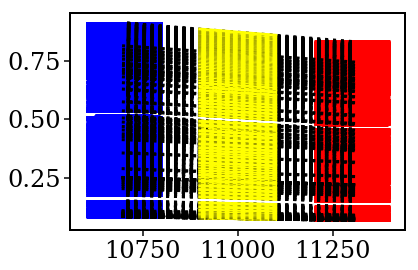

In [14]:
# def smooth_model_spec(data_wave, data, data_err, model_wave, model, sampling_l_opt, delta_l_opt, sampling_l_NIR=50, delta_l_NIR=50/2.35):
#     from astropy.convolution import Gaussian1DKernel, convolve

#     mask = (model_wave >= data_wave[0]) & (model_wave <= data_wave[-1])
    
#     # flux_radius_opt = int(np.sqrt((df_photometry.iloc[ID-1].flux_radius*23.25)**2
#     #                               -(delta_l_opt*(1+redshift_1))**2)/(sampling_l_opt*(1+redshift_1))+0.5)
#     flux_radius_opt = int(np.sqrt((RADIUS*23.25)**2
#                                   -(delta_l_opt*(1+redshift_1))**2)/(sampling_l_opt*(1+redshift_1))+0.5)
#     # print('optical kernel:',flux_radius_opt)
#     gauss_kernel_opt = Gaussian1DKernel(flux_radius_opt)
    
#     # flux_radius_NIR = int(np.sqrt((df_photometry.iloc[ID-1].flux_radius*23.25)**2
#     #                               -(delta_l_NIR*(1+redshift_1))**2)/(sampling_l_NIR*(1+redshift_1))+0.5)
#     flux_radius_NIR = int(np.sqrt((RADIUS*23.25)**2
#                                   -(delta_l_NIR*(1+redshift_1))**2)/(sampling_l_NIR*(1+redshift_1))+0.5)
#     # print('NIR kernel:',flux_radius_NIR)
#     gauss_kernel_NIR = Gaussian1DKernel(flux_radius_NIR)

#     data_wave = data_wave*(1+redshift_1)
#     model_wave = model_wave*(1+redshift_1)
    
#     model_opt = convolve(model, gauss_kernel_opt)
#     model_flux_f_opt = interpolate.interp1d(model_wave, model_opt)
    
#     model_NIR = convolve(model, gauss_kernel_NIR)
#     model_flux_f_NIR = interpolate.interp1d(model_wave, model_NIR)

#     n=len(data_wave)
#     model_flux_smooth = np.zeros(n)
#     for i in range(n):
#         model_flux_interp = model_flux_f_NIR(data_wave[i])
#         model_flux_smooth[i]=model_flux_interp

#     return data_wave/(1+redshift_1), model_flux_smooth

Lick_index_list_Ma05 = np.zeros(len(df_Ma.Age.unique()))
# Lick_index_list_Ma05_69_AV0533 = np.zeros(len(df_Ma.Age.unique()))
# Lick_index_list_Ma05_13_AV0237 = np.zeros(len(df_Ma.Age.unique()))

Lick_index_list_Ma05_smoothed_min = np.zeros(len(df_Ma.Age.unique()))
Lick_index_list_Ma05_smoothed_max = np.zeros(len(df_Ma.Age.unique()))
# Lick_index_list_Ma05_69_AV0533_smoothed_6 = np.zeros(len(df_Ma.Age.unique()))
# Lick_index_list_Ma05_13_AV0237_smoothed_6 = np.zeros(len(df_Ma.Age.unique()))


Lick_index_list_Ma13 = np.zeros(len(df_M13.Age.unique()))
# Lick_index_list_Ma13_69_AV0533 = np.zeros(len(df_M13.Age.unique()))
# Lick_index_list_Ma13_13_AV0237 = np.zeros(len(df_M13.Age.unique()))

Lick_index_list_Ma13_smoothed_min = np.zeros(len(df_M13.Age.unique()))
Lick_index_list_Ma13_smoothed_max = np.zeros(len(df_M13.Age.unique()))
# Lick_index_list_Ma13_69_AV0533_smoothed_2 = np.zeros(len(df_M13.Age.unique()))
# Lick_index_list_Ma13_13_AV0237_smoothed_2 = np.zeros(len(df_M13.Age.unique()))

Lick_index_list_BC03 = np.zeros(len(BC03_age_list))
# Lick_index_list_BC03_69_AV0533 = np.zeros(len(BC03_age_list))
# Lick_index_list_BC03_13_AV0237 = np.zeros(len(BC03_age_list))

Lick_index_list_BC03_smoothed_min = np.zeros(len(BC03_age_list))
Lick_index_list_BC03_smoothed_max = np.zeros(len(BC03_age_list))
# Lick_index_list_BC03_69_AV0533_smoothed_3 = np.zeros(len(BC03_age_list))
# Lick_index_list_BC03_13_AV0237_smoothed_3 = np.zeros(len(BC03_age_list))
RADIUS = 3.455
for i in range(len(df_Ma.Age.unique())):
    from astropy.convolution import Gaussian1DKernel, convolve
    from scipy import interpolate

    age_index = i
    age_prior = df_Ma.Age.unique()[age_index]
    galaxy_age = age_prior
    galaxy_age_string = str(age_prior)
    split_galaxy_age_string = str(galaxy_age_string).split('.')

    if age_prior < 1:
        model1 = M05_model_list[age_index]
    elif age_prior == 1.5:
        if galaxy_age >=1.25 and galaxy_age <1.5:
            model1 = 2.*(1.5-galaxy_age)*M05_model_list[30] + 2.*(galaxy_age-1.0)*M05_model_list[31]
        elif galaxy_age >= 1.5 and galaxy_age <= 1.75:
            model1 = 2.*(2.0-galaxy_age)*M05_model_list[31] + 2.*(galaxy_age-1.5)*M05_model_list[32]
    elif len(split_galaxy_age_string[1])==1:
        if galaxy_age >= 1.0 and galaxy_age < 1.25:
            model1 = 2.*(1.5-galaxy_age)*M05_model_list[30] + 2.*(galaxy_age-1.0)*M05_model_list[31]
        elif galaxy_age >=1.75 and galaxy_age < 2.0:
            model1 = 2.*(2.0-galaxy_age)*M05_model_list[31] + 2.*(galaxy_age-1.5)*M05_model_list[32]
        elif galaxy_age >= 2.0 and galaxy_age < 3.0:
            model1 = (3.0-galaxy_age)*M05_model_list[32] + (galaxy_age-2.0)*M05_model_list[33]
        elif galaxy_age >= 3.0 and galaxy_age < 4.0:
            model1 = (4.0-galaxy_age)*M05_model_list[33] + (galaxy_age-3.0)*M05_model_list[34]
        elif galaxy_age >= 4.0 and galaxy_age < 5.0:
            model1 = (5.0-galaxy_age)*M05_model_list[34] + (galaxy_age-4.0)*M05_model_list[35]
        elif galaxy_age >= 5.0 and galaxy_age < 6.0:
            model1 = (6.0-galaxy_age)*M05_model_list[35] + (galaxy_age-5.0)*M05_model_list[36]
        elif galaxy_age >= 6.0 and galaxy_age < 7.0:
            model1 = (7.0-galaxy_age)*M05_model_list[36] + (galaxy_age-6.0)*M05_model_list[37]
        elif galaxy_age >= 7.0 and galaxy_age < 8.0:
            model1 = (8.0-galaxy_age)*M05_model_list[37] + (galaxy_age-7.0)*M05_model_list[38]
        elif galaxy_age >= 8.0 and galaxy_age < 9.0:
            model1 = (9.0-galaxy_age)*M05_model_list[38] + (galaxy_age-8.0)*M05_model_list[39]
        elif galaxy_age >= 9.0 and galaxy_age < 10.0:
            model1 = (10.0-galaxy_age)*M05_model_list[39] + (galaxy_age-9.0)*M05_model_list[40]
        elif galaxy_age >= 10.0 and galaxy_age < 11.0:
            model1 = (11.0-galaxy_age)*M05_model_list[40] + (galaxy_age-10.0)*M05_model_list[41]
        elif galaxy_age >= 11.0 and galaxy_age < 12.0:
            model1 = (12.0-galaxy_age)*M05_model_list[41] + (galaxy_age-11.0)*M05_model_list[42]
        elif galaxy_age >= 12.0 and galaxy_age < 13.0:
            model1 = (13.0-galaxy_age)*M05_model_list[42] + (galaxy_age-12.0)*M05_model_list[43]
        elif galaxy_age >= 13.0 and galaxy_age < 14.0:
            model1 = (14.0-galaxy_age)*M05_model_list[43] + (galaxy_age-13.0)*M05_model_list[44]
        elif galaxy_age >= 14.0 and galaxy_age < 15.0:
            model1 = (15.0-galaxy_age)*M05_model_list[44] + (galaxy_age-14.0)*M05_model_list[45]
        else:
            model1 = M05_model_list[age_index]

    M05_flux_center = model1[1,:]
    F_M05_index=700
    Flux_M05_norm_new = M05_flux_center[F_M05_index]
    smooth_Flux_Ma_1Gyr_new = M05_flux_center/Flux_M05_norm_new
    Lick_index_list_Ma05[age_index]=Lick_index_ratio_new(model1[0,:], smooth_Flux_Ma_1Gyr_new)
    
    # Smooth the model
    delta_l_opt = 20/2.35
    sampling_l_opt = 5
    sampling_l_NIR = 5 
    delta_l_NIR = 50/2.35
    flux_radius_opt = int(np.sqrt((RADIUS*23.25)**2-(delta_l_opt)**2)/(sampling_l_opt)+0.5)
    gauss_kernel_opt = Gaussian1DKernel(flux_radius_opt)
    
    flux_radius_NIR = int(np.sqrt((RADIUS*23.25)**2-(delta_l_NIR)**2)/(sampling_l_NIR)+0.5)
    gauss_kernel_NIR = Gaussian1DKernel(flux_radius_NIR)
    
    model_NIR = convolve(smooth_Flux_Ma_1Gyr_new, gauss_kernel_NIR)
    
    Lick_index_list_Ma05_smoothed_min[age_index]=Lick_index_ratio_new(model1[0,:], model_NIR)    
for i in range(1, len(df_M13.Age.unique())):
    age_index = i
    age_prior = df_M13.Age.unique()[age_index]
    galaxy_age = age_prior
    galaxy_age_string = str(age_prior)
    split_galaxy_age_string = str(galaxy_age_string).split('.')

    if age_prior < 1e-5:
        model2 = M13_model_list[0]
    elif age_prior >= 1e-5 and age_prior < 1:
        if galaxy_age < age_prior:
            model2 = (M13_model_list[age_index]*(galaxy_age-df_M13.Age.unique()[age_index-1]) \
                + M13_model_list[age_index-1]*(age_prior-galaxy_age))/(df_M13.Age.unique()[age_index]-df_M13.Age.unique()[age_index-1])
        elif galaxy_age > age_prior:
            model2 = (M13_model_list[age_index]*(df_M13.Age.unique()[age_index+1]-galaxy_age) \
                + M13_model_list[age_index+1]*(galaxy_age-age_prior))/(df_M13.Age.unique()[age_index+1]-df_M13.Age.unique()[age_index])
        elif galaxy_age == age_prior:
            model2 = M13_model_list[age_index] 
    elif age_prior == 1.5:
        if galaxy_age >=1.25 and galaxy_age <1.5:
            model2 = 2.*(1.5-galaxy_age)*M13_model_list[51] + 2.*(galaxy_age-1.0)*M13_model_list[52]
        elif galaxy_age >= 1.5 and galaxy_age <= 1.75:
            model2 = 2.*(2.0-galaxy_age)*M13_model_list[52] + 2.*(galaxy_age-1.5)*M13_model_list[53]
    elif len(split_galaxy_age_string[1])==1:
        if galaxy_age >= 1.0 and galaxy_age < 1.25:
            model2 = 2.*(1.5-galaxy_age)*M13_model_list[51] + 2.*(galaxy_age-1.0)*M13_model_list[52]
        elif galaxy_age >=1.75 and galaxy_age < 2.0:
            model2 = 2.*(2.0-galaxy_age)*M13_model_list[52] + 2.*(galaxy_age-1.5)*M13_model_list[53]
        elif galaxy_age >= 2.0 and galaxy_age < 3.0:
            model2 = (3.0-galaxy_age)*M13_model_list[53] + (galaxy_age-2.0)*M13_model_list[54]
        elif galaxy_age >= 3.0 and galaxy_age < 4.0:
            model2 = (4.0-galaxy_age)*M13_model_list[54] + (galaxy_age-3.0)*M13_model_list[55]
        elif galaxy_age >= 4.0 and galaxy_age < 5.0:
            model2 = (5.0-galaxy_age)*M13_model_list[55] + (galaxy_age-4.0)*M13_model_list[56]
        elif galaxy_age >= 5.0 and galaxy_age < 6.0:
            model2 = (6.0-galaxy_age)*M13_model_list[56] + (galaxy_age-5.0)*M13_model_list[57]
        elif galaxy_age >= 6.0 and galaxy_age < 7.0:
            model2 = (7.0-galaxy_age)*M13_model_list[57] + (galaxy_age-6.0)*M13_model_list[58]
        elif galaxy_age >= 7.0 and galaxy_age < 8.0:
            model2 = (8.0-galaxy_age)*M13_model_list[58] + (galaxy_age-7.0)*M13_model_list[59]
        elif galaxy_age >= 8.0 and galaxy_age < 9.0:
            model2 = (9.0-galaxy_age)*M13_model_list[59] + (galaxy_age-8.0)*M13_model_list[60]
        elif galaxy_age >= 9.0 and galaxy_age < 10.0:
            model2 = (10.0-galaxy_age)*M13_model_list[60] + (galaxy_age-9.0)*M13_model_list[61]
        elif galaxy_age >= 10.0 and galaxy_age < 11.0:
            model2 = (11.0-galaxy_age)*M13_model_list[61] + (galaxy_age-10.0)*M13_model_list[62]
        elif galaxy_age >= 11.0 and galaxy_age < 12.0:
            model2 = (12.0-galaxy_age)*M13_model_list[62] + (galaxy_age-11.0)*M13_model_list[63]
        elif galaxy_age >= 12.0 and galaxy_age < 13.0:
            model2 = (13.0-galaxy_age)*M13_model_list[63] + (galaxy_age-12.0)*M13_model_list[64]
        elif galaxy_age >= 13.0 and galaxy_age < 14.0:
            model2 = (14.0-galaxy_age)*M13_model_list[64] + (galaxy_age-13.0)*M13_model_list[65]
        elif galaxy_age >= 14.0 and galaxy_age < 15.0:
            model2 = (15.0-galaxy_age)*M13_model_list[65] + (galaxy_age-14.0)*M13_model_list[66]
        else:
            model2 = M13_model_list[age_index]

    M13_flux_center = model2[1,:]#*spectra_flux_correction
    F_M13_index = 326#126
    Flux_M13_norm_new = M13_flux_center[F_M13_index]
    smooth_Flux_M13_1Gyr_new = M13_flux_center/Flux_M13_norm_new
    Lick_index_list_Ma13[age_index]=Lick_index_ratio_new(model2[0,:], smooth_Flux_M13_1Gyr_new)

    
    delta_l_opt = 20/2.35
    sampling_l_opt = 20
    delta_l_NIR = 50/2.35
    sampling_l_NIR = 50
    flux_radius_opt = int(np.sqrt((RADIUS*23.25)**2
                                  -(delta_l_opt)**2)/(sampling_l_opt)+0.5)
    gauss_kernel_opt = Gaussian1DKernel(flux_radius_opt)
    
    flux_radius_NIR = int(np.sqrt((RADIUS*23.25)**2
                                  -(delta_l_NIR)**2)/(sampling_l_NIR)+0.5)
    gauss_kernel_NIR = Gaussian1DKernel(flux_radius_NIR)
#     print('M13 kernels:',flux_radius_opt,flux_radius_NIR)
    
    model_wave_interp = np.zeros(850)
    model_flux_interp = np.zeros(850)
    model_wave_interp[:354] = model2[0,198:552]
    model_flux_interp[:354] = smooth_Flux_M13_1Gyr_new[198:552]
    
    x_data = model2[0,552:670]
    y_data = smooth_Flux_M13_1Gyr_new[552:670]
    t = np.linspace(0, 1, len(x_data))
    num = int(len(x_data)/(flux_radius_NIR/flux_radius_opt)+0.5)
#     print('interpolated between 1e4 to 1.6e4 with original 118 points:',num)
    t2 = np.linspace(0, 1, num)
    x2 = np.interp(t2, t, x_data)
    y2 = np.interp(t2, t, y_data)
    model_wave_interp[354:354+num]=x2
    model_flux_interp[354:354+num]=y2

    model_opt = convolve(model_flux_interp, gauss_kernel_opt)
    Lick_index_list_Ma13_smoothed_min[age_index]=Lick_index_ratio_new(model_wave_interp, model_opt)
for i in range(len(BC03_age_list_num)):
    age_index = i
    age_prior = BC03_age_list_num[age_index]
    galaxy_age = age_prior

    if galaxy_age == age_prior:
        model3_flux = BC03_flux_array[age_index, :7125]
    elif galaxy_age < age_prior:
        age_interval = BC03_age_list_num[age_index+1] - BC03_age_list_num[age_index]
        model3_flux = (BC03_flux_array[age_index, :7125]*(BC03_age_list_num[age_index+1]-galaxy_age) + BC03_flux_array[age_index+1, :7125]*(galaxy_age-BC03_age_list_num[age_index]))*1./age_interval
    elif galaxy_age > age_prior:
        age_interval = BC03_age_list_num[age_index] - BC03_age_list_num[age_index-1]
        model3_flux = (BC03_flux_array[age_index, :7125]*(BC03_age_list_num[age_index]-galaxy_age) + BC03_flux_array[age_index+1, :7125]*(galaxy_age-BC03_age_list_num[age_index-1]))*1./age_interval   

    BC03_flux_attenuated = model3_flux#*spectra_flux_correction
    BC03_flux_norm = BC03_flux_attenuated[2556]
    BC03_flux_attenuated = BC03_flux_attenuated/BC03_flux_norm
    Lick_index_list_BC03[age_index]=Lick_index_ratio_new(BC03_wave_list_num, BC03_flux_attenuated)

    delta_l_opt = 3/2.35
    sampling_l_opt = 1
    sampling_l_opt_2 = 16.7
    delta_l_NIR = 50/2.35
    sampling_l_NIR = 33.3
    flux_radius_opt_1 = int(np.sqrt((RADIUS*23.25)**2-
                                    (delta_l_opt)**2)/(sampling_l_opt)+0.5)
    gauss_kernel_opt_1 = Gaussian1DKernel(flux_radius_opt_1)
    
    flux_radius_opt_2 = int(np.sqrt((RADIUS*23.25)**2-
                                    (delta_l_opt)**2)/(sampling_l_opt_2)+0.5)
    gauss_kernel_opt_2 = Gaussian1DKernel(flux_radius_opt_2)
    
    flux_radius_NIR = int(np.sqrt((RADIUS*23.25)**2-
                                  (delta_l_NIR)**2)/(sampling_l_NIR)+0.5)
    gauss_kernel_NIR = Gaussian1DKernel(flux_radius_NIR)
    
    model_wave_interp = np.zeros(15000)
    model_flux_interp = np.zeros(15000)
    model_wave_interp[:2750] = BC03_wave_list_num[3056:5806]
    model_flux_interp[:2750] = BC03_flux_attenuated[3056:5806]
    
    x_data = BC03_wave_list_num[5806:5881]
    y_data = BC03_flux_attenuated[5806:5881]
    t = np.linspace(0, 1, len(x_data))
    num1 = int(len(x_data)/(flux_radius_opt_2/flux_radius_opt_1)+0.5)
#     print('BC model interpolated between 8750 to 1e4 with original 75 points:',num1)
    t2 = np.linspace(0, 1, num1)
    x2 = np.interp(t2, t, x_data)
    y2 = np.interp(t2, t, y_data)
    model_wave_interp[2750:2750+num1]=x2
    model_flux_interp[2750:2750+num1]=y2
    
    x_data = BC03_wave_list_num[5881:6062]
    y_data = BC03_flux_attenuated[5881:6062]
    t = np.linspace(0, 1, len(x_data))
    num2 = int(len(x_data)/(flux_radius_NIR/flux_radius_opt_1)+0.5)
#     print('BC model interpolated between 1e4 to 1.6e4 with original 181 points:',num2)
    t2 = np.linspace(0, 1, num2)
    x2 = np.interp(t2, t, x_data)
    y2 = np.interp(t2, t, y_data)
    model_wave_interp[2750+num1:2750+num1+num2]=x2
    model_flux_interp[2750+num1:2750+num1+num2]=y2
    
    model_opt = convolve(model_flux_interp, gauss_kernel_opt_1)
    
    Lick_index_list_BC03_smoothed_min[age_index]=Lick_index_ratio_new(model_wave_interp, model_opt)
RADIUS = 17.356
for i in range(len(df_Ma.Age.unique())):
    from astropy.convolution import Gaussian1DKernel, convolve
    from scipy import interpolate

    age_index = i
    age_prior = df_Ma.Age.unique()[age_index]
    galaxy_age = age_prior
    galaxy_age_string = str(age_prior)
    split_galaxy_age_string = str(galaxy_age_string).split('.')

    if age_prior < 1:
        model1 = M05_model_list[age_index]
    elif age_prior == 1.5:
        if galaxy_age >=1.25 and galaxy_age <1.5:
            model1 = 2.*(1.5-galaxy_age)*M05_model_list[30] + 2.*(galaxy_age-1.0)*M05_model_list[31]
        elif galaxy_age >= 1.5 and galaxy_age <= 1.75:
            model1 = 2.*(2.0-galaxy_age)*M05_model_list[31] + 2.*(galaxy_age-1.5)*M05_model_list[32]
    elif len(split_galaxy_age_string[1])==1:
        if galaxy_age >= 1.0 and galaxy_age < 1.25:
            model1 = 2.*(1.5-galaxy_age)*M05_model_list[30] + 2.*(galaxy_age-1.0)*M05_model_list[31]
        elif galaxy_age >=1.75 and galaxy_age < 2.0:
            model1 = 2.*(2.0-galaxy_age)*M05_model_list[31] + 2.*(galaxy_age-1.5)*M05_model_list[32]
        elif galaxy_age >= 2.0 and galaxy_age < 3.0:
            model1 = (3.0-galaxy_age)*M05_model_list[32] + (galaxy_age-2.0)*M05_model_list[33]
        elif galaxy_age >= 3.0 and galaxy_age < 4.0:
            model1 = (4.0-galaxy_age)*M05_model_list[33] + (galaxy_age-3.0)*M05_model_list[34]
        elif galaxy_age >= 4.0 and galaxy_age < 5.0:
            model1 = (5.0-galaxy_age)*M05_model_list[34] + (galaxy_age-4.0)*M05_model_list[35]
        elif galaxy_age >= 5.0 and galaxy_age < 6.0:
            model1 = (6.0-galaxy_age)*M05_model_list[35] + (galaxy_age-5.0)*M05_model_list[36]
        elif galaxy_age >= 6.0 and galaxy_age < 7.0:
            model1 = (7.0-galaxy_age)*M05_model_list[36] + (galaxy_age-6.0)*M05_model_list[37]
        elif galaxy_age >= 7.0 and galaxy_age < 8.0:
            model1 = (8.0-galaxy_age)*M05_model_list[37] + (galaxy_age-7.0)*M05_model_list[38]
        elif galaxy_age >= 8.0 and galaxy_age < 9.0:
            model1 = (9.0-galaxy_age)*M05_model_list[38] + (galaxy_age-8.0)*M05_model_list[39]
        elif galaxy_age >= 9.0 and galaxy_age < 10.0:
            model1 = (10.0-galaxy_age)*M05_model_list[39] + (galaxy_age-9.0)*M05_model_list[40]
        elif galaxy_age >= 10.0 and galaxy_age < 11.0:
            model1 = (11.0-galaxy_age)*M05_model_list[40] + (galaxy_age-10.0)*M05_model_list[41]
        elif galaxy_age >= 11.0 and galaxy_age < 12.0:
            model1 = (12.0-galaxy_age)*M05_model_list[41] + (galaxy_age-11.0)*M05_model_list[42]
        elif galaxy_age >= 12.0 and galaxy_age < 13.0:
            model1 = (13.0-galaxy_age)*M05_model_list[42] + (galaxy_age-12.0)*M05_model_list[43]
        elif galaxy_age >= 13.0 and galaxy_age < 14.0:
            model1 = (14.0-galaxy_age)*M05_model_list[43] + (galaxy_age-13.0)*M05_model_list[44]
        elif galaxy_age >= 14.0 and galaxy_age < 15.0:
            model1 = (15.0-galaxy_age)*M05_model_list[44] + (galaxy_age-14.0)*M05_model_list[45]
        else:
            model1 = M05_model_list[age_index]

    M05_flux_center = model1[1,:]
    F_M05_index=700
    Flux_M05_norm_new = M05_flux_center[F_M05_index]
    smooth_Flux_Ma_1Gyr_new = M05_flux_center/Flux_M05_norm_new
    Lick_index_list_Ma05[age_index]=Lick_index_ratio_new(model1[0,:], smooth_Flux_Ma_1Gyr_new)
    
    # Smooth the model
    delta_l_opt = 20/2.35
    sampling_l_opt = 5
    sampling_l_NIR = 5 
    delta_l_NIR = 50/2.35
    flux_radius_opt = int(np.sqrt((RADIUS*23.25)**2-(delta_l_opt)**2)/(sampling_l_opt)+0.5)
    gauss_kernel_opt = Gaussian1DKernel(flux_radius_opt)
    
    flux_radius_NIR = int(np.sqrt((RADIUS*23.25)**2-(delta_l_NIR)**2)/(sampling_l_NIR)+0.5)
    gauss_kernel_NIR = Gaussian1DKernel(flux_radius_NIR)
    
    model_NIR = convolve(smooth_Flux_Ma_1Gyr_new, gauss_kernel_NIR)
    
    Lick_index_list_Ma05_smoothed_max[age_index]=Lick_index_ratio_new(model1[0,:], model_NIR)    
for i in range(1, len(df_M13.Age.unique())):
    age_index = i
    age_prior = df_M13.Age.unique()[age_index]
    galaxy_age = age_prior
    galaxy_age_string = str(age_prior)
    split_galaxy_age_string = str(galaxy_age_string).split('.')

    if age_prior < 1e-5:
        model2 = M13_model_list[0]
    elif age_prior >= 1e-5 and age_prior < 1:
        if galaxy_age < age_prior:
            model2 = (M13_model_list[age_index]*(galaxy_age-df_M13.Age.unique()[age_index-1]) \
                + M13_model_list[age_index-1]*(age_prior-galaxy_age))/(df_M13.Age.unique()[age_index]-df_M13.Age.unique()[age_index-1])
        elif galaxy_age > age_prior:
            model2 = (M13_model_list[age_index]*(df_M13.Age.unique()[age_index+1]-galaxy_age) \
                + M13_model_list[age_index+1]*(galaxy_age-age_prior))/(df_M13.Age.unique()[age_index+1]-df_M13.Age.unique()[age_index])
        elif galaxy_age == age_prior:
            model2 = M13_model_list[age_index] 
    elif age_prior == 1.5:
        if galaxy_age >=1.25 and galaxy_age <1.5:
            model2 = 2.*(1.5-galaxy_age)*M13_model_list[51] + 2.*(galaxy_age-1.0)*M13_model_list[52]
        elif galaxy_age >= 1.5 and galaxy_age <= 1.75:
            model2 = 2.*(2.0-galaxy_age)*M13_model_list[52] + 2.*(galaxy_age-1.5)*M13_model_list[53]
    elif len(split_galaxy_age_string[1])==1:
        if galaxy_age >= 1.0 and galaxy_age < 1.25:
            model2 = 2.*(1.5-galaxy_age)*M13_model_list[51] + 2.*(galaxy_age-1.0)*M13_model_list[52]
        elif galaxy_age >=1.75 and galaxy_age < 2.0:
            model2 = 2.*(2.0-galaxy_age)*M13_model_list[52] + 2.*(galaxy_age-1.5)*M13_model_list[53]
        elif galaxy_age >= 2.0 and galaxy_age < 3.0:
            model2 = (3.0-galaxy_age)*M13_model_list[53] + (galaxy_age-2.0)*M13_model_list[54]
        elif galaxy_age >= 3.0 and galaxy_age < 4.0:
            model2 = (4.0-galaxy_age)*M13_model_list[54] + (galaxy_age-3.0)*M13_model_list[55]
        elif galaxy_age >= 4.0 and galaxy_age < 5.0:
            model2 = (5.0-galaxy_age)*M13_model_list[55] + (galaxy_age-4.0)*M13_model_list[56]
        elif galaxy_age >= 5.0 and galaxy_age < 6.0:
            model2 = (6.0-galaxy_age)*M13_model_list[56] + (galaxy_age-5.0)*M13_model_list[57]
        elif galaxy_age >= 6.0 and galaxy_age < 7.0:
            model2 = (7.0-galaxy_age)*M13_model_list[57] + (galaxy_age-6.0)*M13_model_list[58]
        elif galaxy_age >= 7.0 and galaxy_age < 8.0:
            model2 = (8.0-galaxy_age)*M13_model_list[58] + (galaxy_age-7.0)*M13_model_list[59]
        elif galaxy_age >= 8.0 and galaxy_age < 9.0:
            model2 = (9.0-galaxy_age)*M13_model_list[59] + (galaxy_age-8.0)*M13_model_list[60]
        elif galaxy_age >= 9.0 and galaxy_age < 10.0:
            model2 = (10.0-galaxy_age)*M13_model_list[60] + (galaxy_age-9.0)*M13_model_list[61]
        elif galaxy_age >= 10.0 and galaxy_age < 11.0:
            model2 = (11.0-galaxy_age)*M13_model_list[61] + (galaxy_age-10.0)*M13_model_list[62]
        elif galaxy_age >= 11.0 and galaxy_age < 12.0:
            model2 = (12.0-galaxy_age)*M13_model_list[62] + (galaxy_age-11.0)*M13_model_list[63]
        elif galaxy_age >= 12.0 and galaxy_age < 13.0:
            model2 = (13.0-galaxy_age)*M13_model_list[63] + (galaxy_age-12.0)*M13_model_list[64]
        elif galaxy_age >= 13.0 and galaxy_age < 14.0:
            model2 = (14.0-galaxy_age)*M13_model_list[64] + (galaxy_age-13.0)*M13_model_list[65]
        elif galaxy_age >= 14.0 and galaxy_age < 15.0:
            model2 = (15.0-galaxy_age)*M13_model_list[65] + (galaxy_age-14.0)*M13_model_list[66]
        else:
            model2 = M13_model_list[age_index]

    M13_flux_center = model2[1,:]#*spectra_flux_correction
    F_M13_index = 326#126
    Flux_M13_norm_new = M13_flux_center[F_M13_index]
    smooth_Flux_M13_1Gyr_new = M13_flux_center/Flux_M13_norm_new
    Lick_index_list_Ma13[age_index]=Lick_index_ratio_new(model2[0,:], smooth_Flux_M13_1Gyr_new)

    
    delta_l_opt = 20/2.35
    sampling_l_opt = 20
    delta_l_NIR = 50/2.35
    sampling_l_NIR = 50
    flux_radius_opt = int(np.sqrt((RADIUS*23.25)**2
                                  -(delta_l_opt)**2)/(sampling_l_opt)+0.5)
    gauss_kernel_opt = Gaussian1DKernel(flux_radius_opt)
    
    flux_radius_NIR = int(np.sqrt((RADIUS*23.25)**2
                                  -(delta_l_NIR)**2)/(sampling_l_NIR)+0.5)
    gauss_kernel_NIR = Gaussian1DKernel(flux_radius_NIR)
#     print('M13 kernels:',flux_radius_opt,flux_radius_NIR)
    
    model_wave_interp = np.zeros(850)
    model_flux_interp = np.zeros(850)
    model_wave_interp[:354] = model2[0,198:552]
    model_flux_interp[:354] = smooth_Flux_M13_1Gyr_new[198:552]
    
    x_data = model2[0,552:670]
    y_data = smooth_Flux_M13_1Gyr_new[552:670]
    t = np.linspace(0, 1, len(x_data))
    num = int(len(x_data)/(flux_radius_NIR/flux_radius_opt)+0.5)
#     print('interpolated between 1e4 to 1.6e4 with original 118 points:',num)
    t2 = np.linspace(0, 1, num)
    x2 = np.interp(t2, t, x_data)
    y2 = np.interp(t2, t, y_data)
    model_wave_interp[354:354+num]=x2
    model_flux_interp[354:354+num]=y2

    model_opt = convolve(model_flux_interp, gauss_kernel_opt)
    Lick_index_list_Ma13_smoothed_max[age_index]=Lick_index_ratio_new(model_wave_interp, model_opt)
for i in range(len(BC03_age_list_num)):
    age_index = i
    age_prior = BC03_age_list_num[age_index]
    galaxy_age = age_prior

    if galaxy_age == age_prior:
        model3_flux = BC03_flux_array[age_index, :7125]
    elif galaxy_age < age_prior:
        age_interval = BC03_age_list_num[age_index+1] - BC03_age_list_num[age_index]
        model3_flux = (BC03_flux_array[age_index, :7125]*(BC03_age_list_num[age_index+1]-galaxy_age) + BC03_flux_array[age_index+1, :7125]*(galaxy_age-BC03_age_list_num[age_index]))*1./age_interval
    elif galaxy_age > age_prior:
        age_interval = BC03_age_list_num[age_index] - BC03_age_list_num[age_index-1]
        model3_flux = (BC03_flux_array[age_index, :7125]*(BC03_age_list_num[age_index]-galaxy_age) + BC03_flux_array[age_index+1, :7125]*(galaxy_age-BC03_age_list_num[age_index-1]))*1./age_interval   

    BC03_flux_attenuated = model3_flux#*spectra_flux_correction
    BC03_flux_norm = BC03_flux_attenuated[2556]
    BC03_flux_attenuated = BC03_flux_attenuated/BC03_flux_norm
    Lick_index_list_BC03[age_index]=Lick_index_ratio_new(BC03_wave_list_num, BC03_flux_attenuated)

    delta_l_opt = 3/2.35
    sampling_l_opt = 1
    sampling_l_opt_2 = 16.7
    delta_l_NIR = 50/2.35
    sampling_l_NIR = 33.3
    flux_radius_opt_1 = int(np.sqrt((RADIUS*23.25)**2-
                                    (delta_l_opt)**2)/(sampling_l_opt)+0.5)
    gauss_kernel_opt_1 = Gaussian1DKernel(flux_radius_opt_1)
    
    flux_radius_opt_2 = int(np.sqrt((RADIUS*23.25)**2-
                                    (delta_l_opt)**2)/(sampling_l_opt_2)+0.5)
    gauss_kernel_opt_2 = Gaussian1DKernel(flux_radius_opt_2)
    
    flux_radius_NIR = int(np.sqrt((RADIUS*23.25)**2-
                                  (delta_l_NIR)**2)/(sampling_l_NIR)+0.5)
    gauss_kernel_NIR = Gaussian1DKernel(flux_radius_NIR)
    
    model_wave_interp = np.zeros(15000)
    model_flux_interp = np.zeros(15000)
    model_wave_interp[:2750] = BC03_wave_list_num[3056:5806]
    model_flux_interp[:2750] = BC03_flux_attenuated[3056:5806]
    
    x_data = BC03_wave_list_num[5806:5881]
    y_data = BC03_flux_attenuated[5806:5881]
    t = np.linspace(0, 1, len(x_data))
    num1 = int(len(x_data)/(flux_radius_opt_2/flux_radius_opt_1)+0.5)
#     print('BC model interpolated between 8750 to 1e4 with original 75 points:',num1)
    t2 = np.linspace(0, 1, num1)
    x2 = np.interp(t2, t, x_data)
    y2 = np.interp(t2, t, y_data)
    model_wave_interp[2750:2750+num1]=x2
    model_flux_interp[2750:2750+num1]=y2
    
    x_data = BC03_wave_list_num[5881:6062]
    y_data = BC03_flux_attenuated[5881:6062]
    t = np.linspace(0, 1, len(x_data))
    num2 = int(len(x_data)/(flux_radius_NIR/flux_radius_opt_1)+0.5)
#     print('BC model interpolated between 1e4 to 1.6e4 with original 181 points:',num2)
    t2 = np.linspace(0, 1, num2)
    x2 = np.interp(t2, t, x_data)
    y2 = np.interp(t2, t, y_data)
    model_wave_interp[2750+num1:2750+num1+num2]=x2
    model_flux_interp[2750+num1:2750+num1+num2]=y2
    
    model_opt = convolve(model_flux_interp, gauss_kernel_opt_1)
    
    Lick_index_list_BC03_smoothed_max[age_index]=Lick_index_ratio_new(model_wave_interp, model_opt)

In [15]:
### Read the catalog and drop some targets from the list.
CN_list_new = pd.read_csv('/Volumes/My Passport/TPAGB/database/CN_selected_20200712_69.csv')#('/Volumes/My Passport/TPAGB/database/CN_selected_20200409_new_model_62.csv')
print(len(CN_list_new))
# print(CN_list_new.ID.values[2])
# print(CN_list_new.columns)
CN_list_new = CN_list_new.drop([2])#17857	3	aegis, dropped due to emission line contamination
CN_list_new = CN_list_new.drop(columns='Unnamed: 0')
CN_list_new = CN_list_new.reset_index(drop=True)
# print(CN_list_new)
# print(np.min(CN_list_new.flux_ratio_AV_corr),np.max(CN_list_new.flux_ratio_AV_corr))


## 20200412
### Without full spectral coverage.
#16: cosmos-01-21739, 50: goodsn-26-28082, 57:uds-1-33214, 58: uds-1-34421
# print(CN_list_new.iloc([16,50,57,58]))
CN_list_new = CN_list_new.drop([16,50,57,58])
CN_list_new = CN_list_new.reset_index(drop=True)

## low SNR
#30: cosmos-15-25830, 41: cosmos-25-19926, 56: uds-4-32796
CN_list_new = CN_list_new.drop([41,56])
CN_list_new = CN_list_new.reset_index(drop=True)

CN_list_new = CN_list_new.drop(columns='flux_ratio_err_AV_corr')
CN_list_new = CN_list_new.drop(columns='flux_ratio_AV_corr')
CN_list_new.columns

69


Index(['ID', 'region', 'field', 'M05_age_opt', 'M05_AV_opt', 'M13_age_opt',
       'M13_AV_opt', 'BC_age_opt', 'BC_AV_opt', 'x2_spectra_M05_opt',
       'x2_photo_M05_opt', 'x2_spectra_M13_opt', 'x2_photo_M13_opt',
       'x2_spectra_BC_opt', 'x2_photo_BC_opt', 'M05_age_MCMC50', 'M05_age_std',
       'M05_AV_MCMC50', 'M05_AV_std', 'M13_age_MCMC50', 'M13_age_std',
       'M13_AV_MCMC50', 'M13_AV_std', 'BC_age_MCMC50', 'BC_age_std',
       'BC_AV_MCMC50', 'BC_AV_std', 'x2_spectra_M05_MCMC50',
       'x2_photo_M05_MCMC50', 'x2_spectra_M13_MCMC50', 'x2_photo_M13_MCMC50',
       'x2_spectra_BC_MCMC50', 'x2_photo_BC_MCMC50', 'x2_M05_opt',
       'x2_M13_opt', 'x2_BC_opt', 'x2_M05_MCMC50', 'x2_M13_MCMC50',
       'x2_BC_MCMC50', 'min_2', 'model', 'min_spec_chi2', 'model_spec',
       'grism_index', 'grism_index_AV_corr', 'age_opt', 'age_opt_std',
       'AV_opt', 'AV_opt_std', 'M_K', 'BC_ML', 'BC_mass', 'M05_ML', 'M05_mass',
       'M13_mass', 'best_mass', 'radius', 'use_phot', 'z_best', 'z_t

In [64]:
CN_list_new_sub = Flux_ratio_AV_corr_20200712_EW(CN_list_new)
print(len(CN_list_new_sub))

0 aegis 1 26380 0.264
Time running the reading the data and run the catalog: 0.0657498836517334
Original EW_AV_corr: -4.435087048099703
MC result: -4.34748753470893 1.234570664551323
Time runninng the fit: 12.370844841003418
EW AV corrected: -4.435087048099703 1.234570664551323
Radius: 6.546
1 aegis 2 14044 0.436
Time running the reading the data and run the catalog: 0.5832798480987549
Original EW_AV_corr: -1.1104911075895896
MC result: -1.0667073329617947 0.7470112049402876
Time runninng the fit: 12.507842063903809
EW AV corrected: -1.1104911075895896 0.7470112049402876
Radius: 9.935
2 aegis 3 19820 0.4197
Time running the reading the data and run the catalog: 0.37781500816345215
Original EW_AV_corr: -2.7231325234623904
MC result: -2.72313645697369 0.5897435152669198
Time runninng the fit: 12.976364135742188
EW AV corrected: -2.7231325234623904 0.5897435152669198
[1.02255755 1.0445436 ]
interpolated between 1e4 to 1.6e4 with original 118 points: 275
interpolated between 1e4 to 1.6e4 w

23 cosmos 7 25888 0.2371
Time running the reading the data and run the catalog: 0.1450350284576416
Original EW_AV_corr: 0.9737493585100079
MC result: 0.8216037168171185 2.23552786602772
Time runninng the fit: 12.707507848739624
EW AV corrected: 0.9737493585100079 2.23552786602772
[0.9645243  0.30668215]
interpolated between 1e4 to 1.6e4 with original 118 points: 354
interpolated between 1e4 to 1.6e4 with original 118 points: 354
Radius: 6.018
24 cosmos 10 14034 0.3743
Time running the reading the data and run the catalog: 0.2165241241455078
Original EW_AV_corr: 4.225413886460622
MC result: 4.231049033371271 0.5705749956311188
Time runninng the fit: 13.450032711029053
EW AV corrected: 4.225413886460622 0.5705749956311188
[0.97102217 0.9059654 ]
interpolated between 1e4 to 1.6e4 with original 118 points: 275
interpolated between 1e4 to 1.6e4 with original 118 points: 275
Radius: 16.932000000000002
25 cosmos 10 16377 0.2235
Time running the reading the data and run the catalog: 0.41149163

limit_output extension: Maximum message size of 10000 exceeded with 10019 characters

In [16]:
# CN_list_new.to_csv('/Volumes/My Passport/TAPS/database/CN_list_61_20200712_EW.csv')
CN_list_new=pd.read_csv('/Volumes/My Passport/TAPS/database/CN_list_61_20200712_EW.csv')

In [68]:
np.max(CN_61.flux_ratio_AV_corr_2-CN_61.flux_ratio_AV_corr)
np.argmin(CN_list_new_sub.flux_ratio_AV_corr)#.iloc[61]#
CN_list_new.iloc[34]#.flux_ratio_AV_corr
# CN_list_new.columns
print(CN_61.iloc[59])#.flux_ratio_AV_corr_2

AttributeError: 'DataFrame' object has no attribute 'flux_ratio_AV_corr'

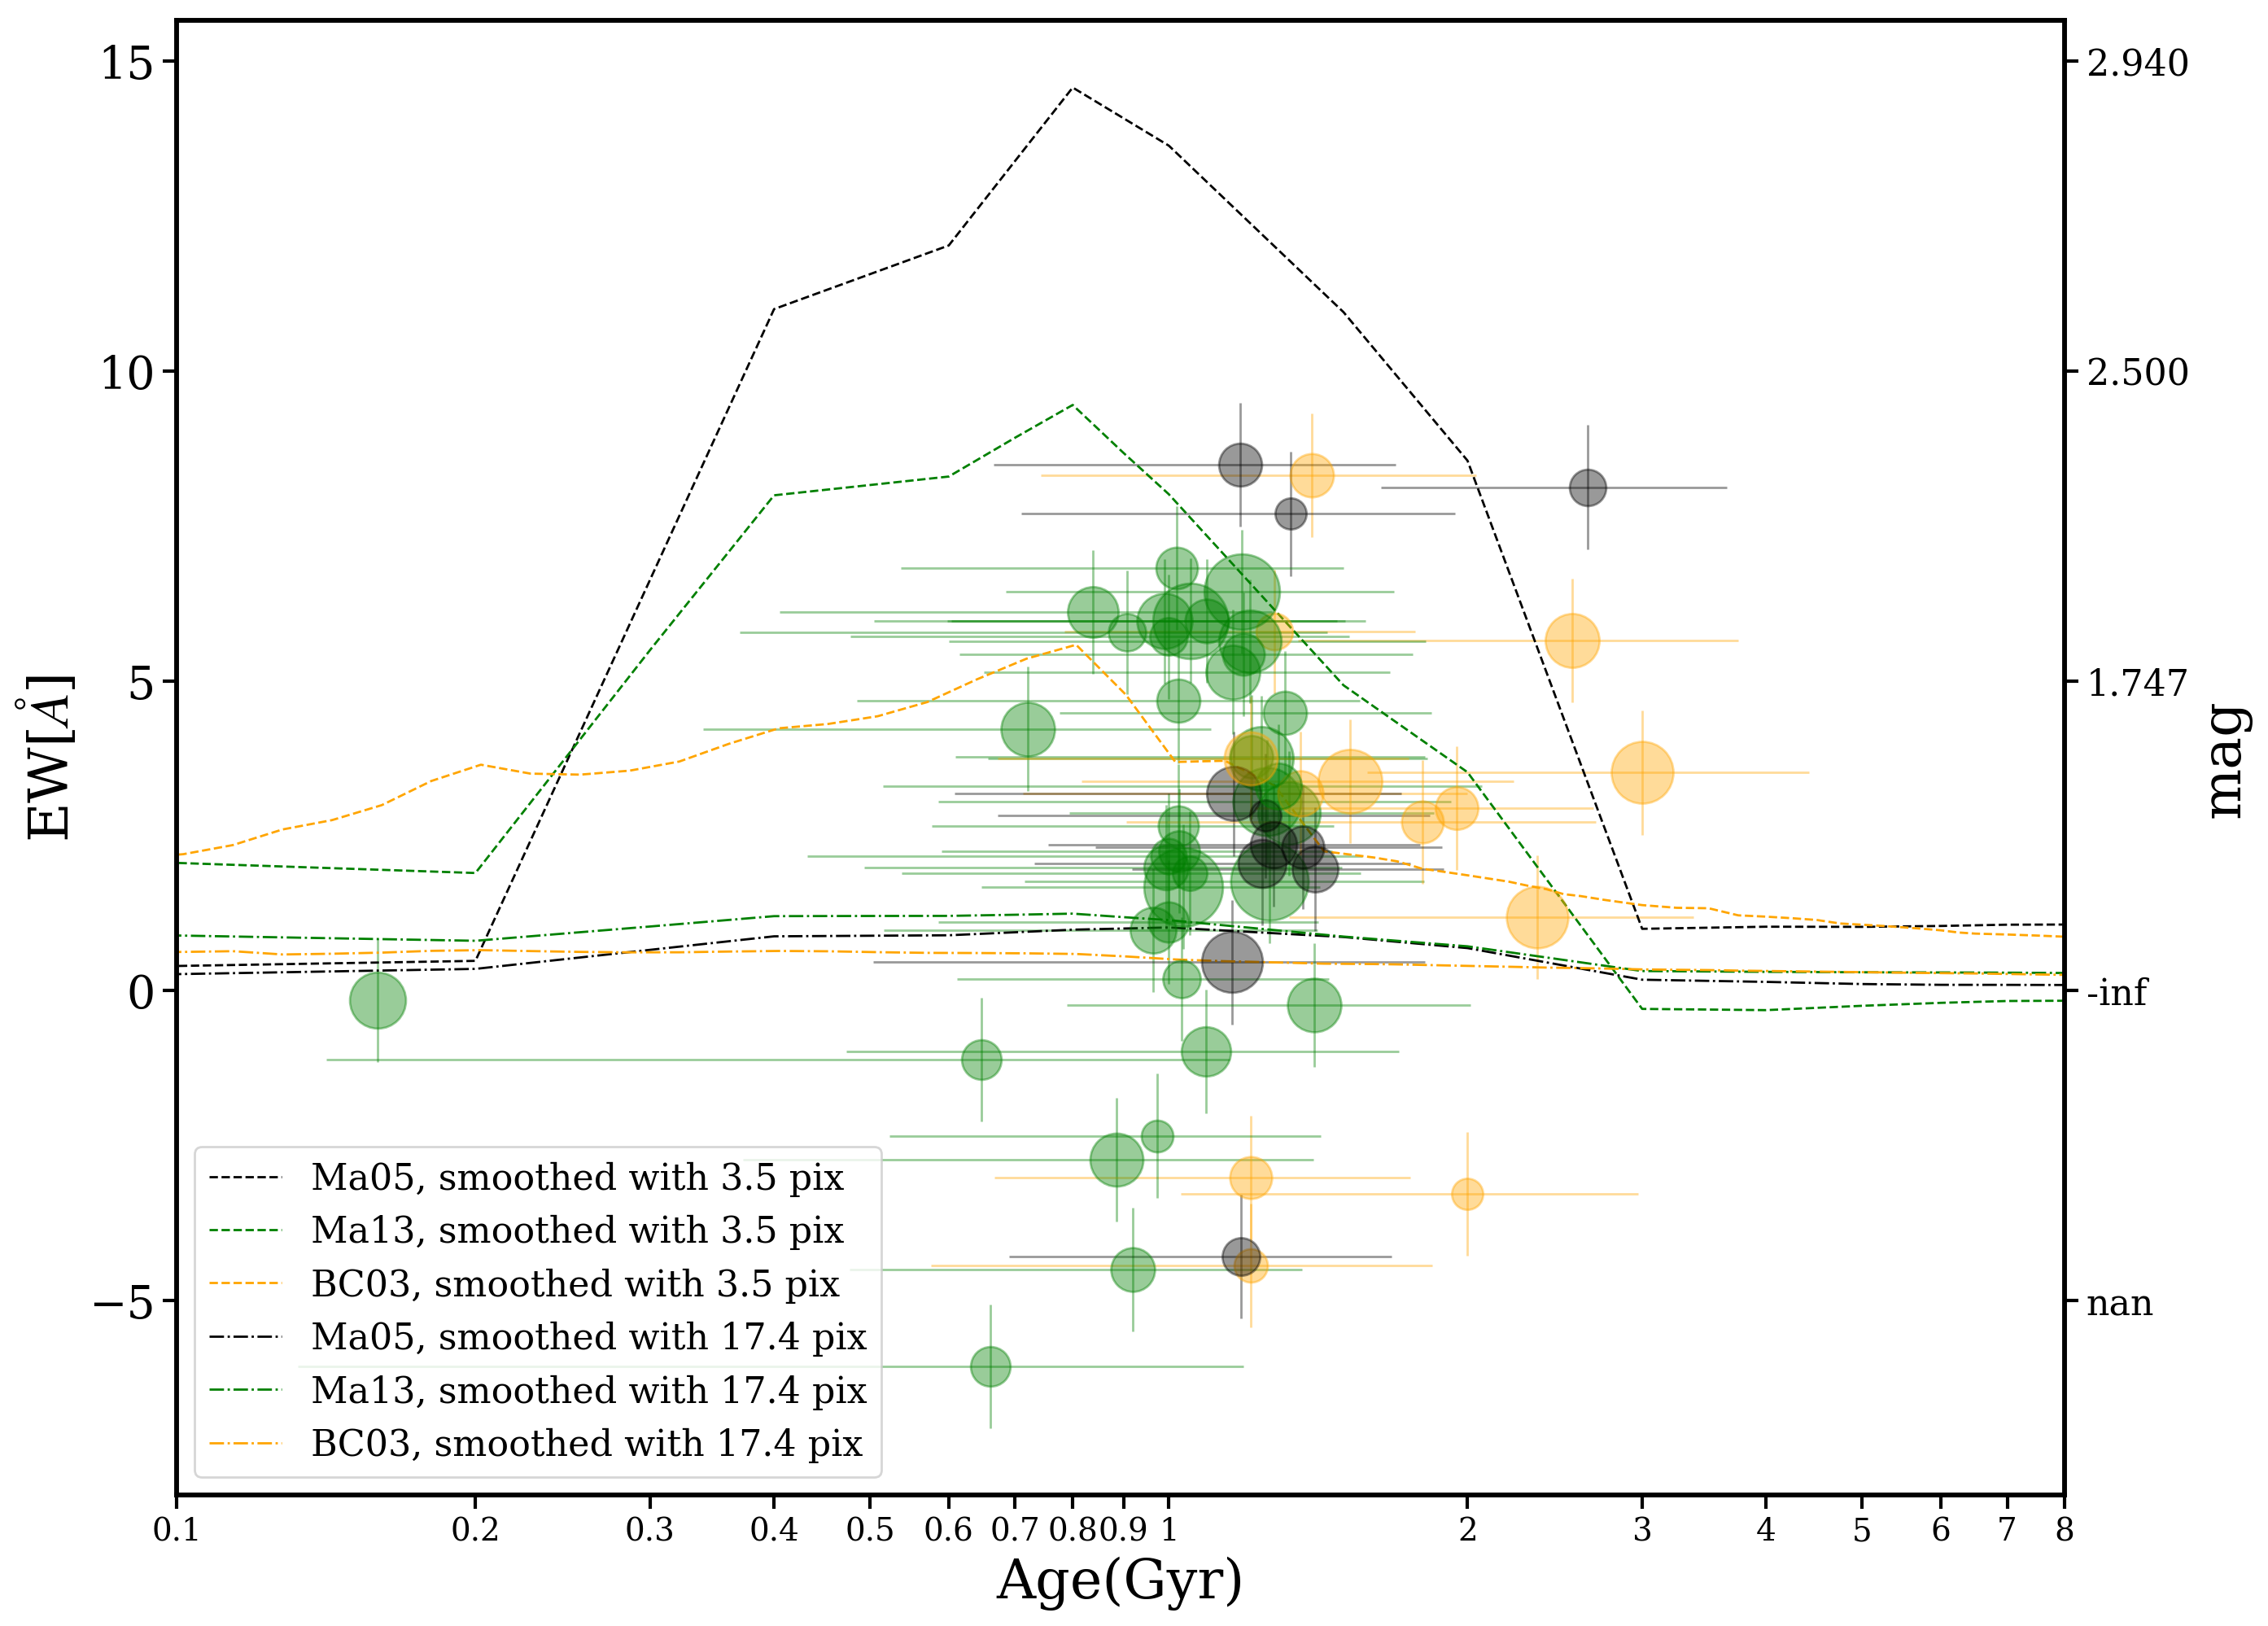

In [17]:
### CN_age plot based on new_model: scatter points
date='20200712'
fig=plt.figure(figsize=(16,12),dpi=200)
plt.rc('lines', linewidth=1, markersize=2)
plt.rc('font', size=24, family='serif', weight=300)
plt.rc('mathtext', fontset='stix')
plt.rc('axes', linewidth=2)
plt.rc('xtick.major', width=1.5, size=6)
plt.rc('ytick.major', width=1.5, size=6)
plt.tick_params(axis='both', which='major', labelsize=20)
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
CN_61 = CN_list_new
CN_61 = CN_61.drop([34])
CN_61 = CN_61.reset_index(drop=True)

colorset=['indigo','k','g','orange']
fmtset = ['*','o','o','o']

for i in range(len(CN_61)):
#     print(i)
    c = CN_61.model.values.astype(int)[i]
    ax1.errorbar(CN_61.iloc[i].age_opt,\
             CN_61.iloc[i].EW_AV_corr,\
             xerr=CN_61.iloc[i].age_opt_std,\
             yerr=CN_61.iloc[i].EW_err_AV_corr,\
             color=colorset[c],\
             markersize=CN_61.iloc[i].FWHM*3,\
             alpha=0.4,\
#              zorder=1,\
             fmt=fmtset[c])

ax1.plot(df_Ma.Age.unique(), Lick_index_list_Ma05_smoothed_min, label='Ma05, smoothed with 3.5 pix', color='k', linestyle='--')
ax1.plot(df_M13.Age.unique()[1:], Lick_index_list_Ma13_smoothed_min[1:], label='Ma13, smoothed with 3.5 pix', color='green', linestyle='--')
ax1.plot(BC03_age_list_num, Lick_index_list_BC03_smoothed_min, label='BC03, smoothed with 3.5 pix', color='orange', linestyle='--')

ax1.plot(df_Ma.Age.unique(), Lick_index_list_Ma05_smoothed_max, label='Ma05, smoothed with 17.4 pix', color='k', linestyle='-.')
ax1.plot(df_M13.Age.unique()[1:], Lick_index_list_Ma13_smoothed_max[1:], label='Ma13, smoothed with 17.4 pix', color='green', linestyle='-.')
ax1.plot(BC03_age_list_num, Lick_index_list_BC03_smoothed_max, label='BC03, smoothed with 17.4 pix', color='orange', linestyle='-.')


ax1Ys = ax1.get_yticks()
ax2Ys = []
for Y in ax1Ys:
    tick = "{0:.3f}".format(2.5*np.log10(Y))
    ax2Ys.append(tick)

ax2.set_yticks(ax1Ys)
ax2.set_ybound(ax1.get_ybound())
ax2.set_yticklabels(ax2Ys)
ax2.yaxis.set_tick_params(labelsize=16)
ax1.legend(prop={'size':16}, loc='lower left')
tick_labels=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,\
             3,4,5,6,7,8]





# ax1Ys = ax1.get_yticks()
# ax2Ys = []
# for Y in ax1Ys:
#     tick = "{0:.3f}".format(2.5*np.log10(Y))
#     ax2Ys.append(tick)

# ax2.set_yticks(ax1Ys)
# ax2.set_ybound(ax1.get_ybound())
# ax2.set_yticklabels(ax2Ys)

# ax1.legend(prop={'size':14}, loc='lower left')

# ax1.legend(prop={'size':16}, loc='lower left')
# tick_labels=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,\
#              3,4,5,6,7,8,9]

fig.subplots_adjust(right=0.85)
ax1.set_xlim(0.1,8)
ax1.semilogx()
ax1.set_xticks(tick_labels)
ax1.set_xticklabels(tick_labels,fontsize=14)
ax1.set_xlabel('Age(Gyr)')
ax1.set_ylabel(r'EW[$\AA$]')
ax2.set_ylabel('mag')




# fig.subplots_adjust(right=0.85)
# ax1.set_xlim(0.1,9)
# ax1.set_ylim([1.03, 1.24])


# ax1.semilogx()
# ax1.set_xticks(tick_labels)
# ax1.set_xticklabels(tick_labels,fontsize=14)
# ax1.set_xlabel('Age(Gyr)')
# ax1.set_ylabel('Flux ratio')
# ax2.set_ylabel('mag')

# ax1.set_ylim([1.05, 1.22])



fn_fig = current_dir+outcome_dir+plot_dir+'EW_CN_age_'+date+'.png'
fig.savefig(fn_fig)


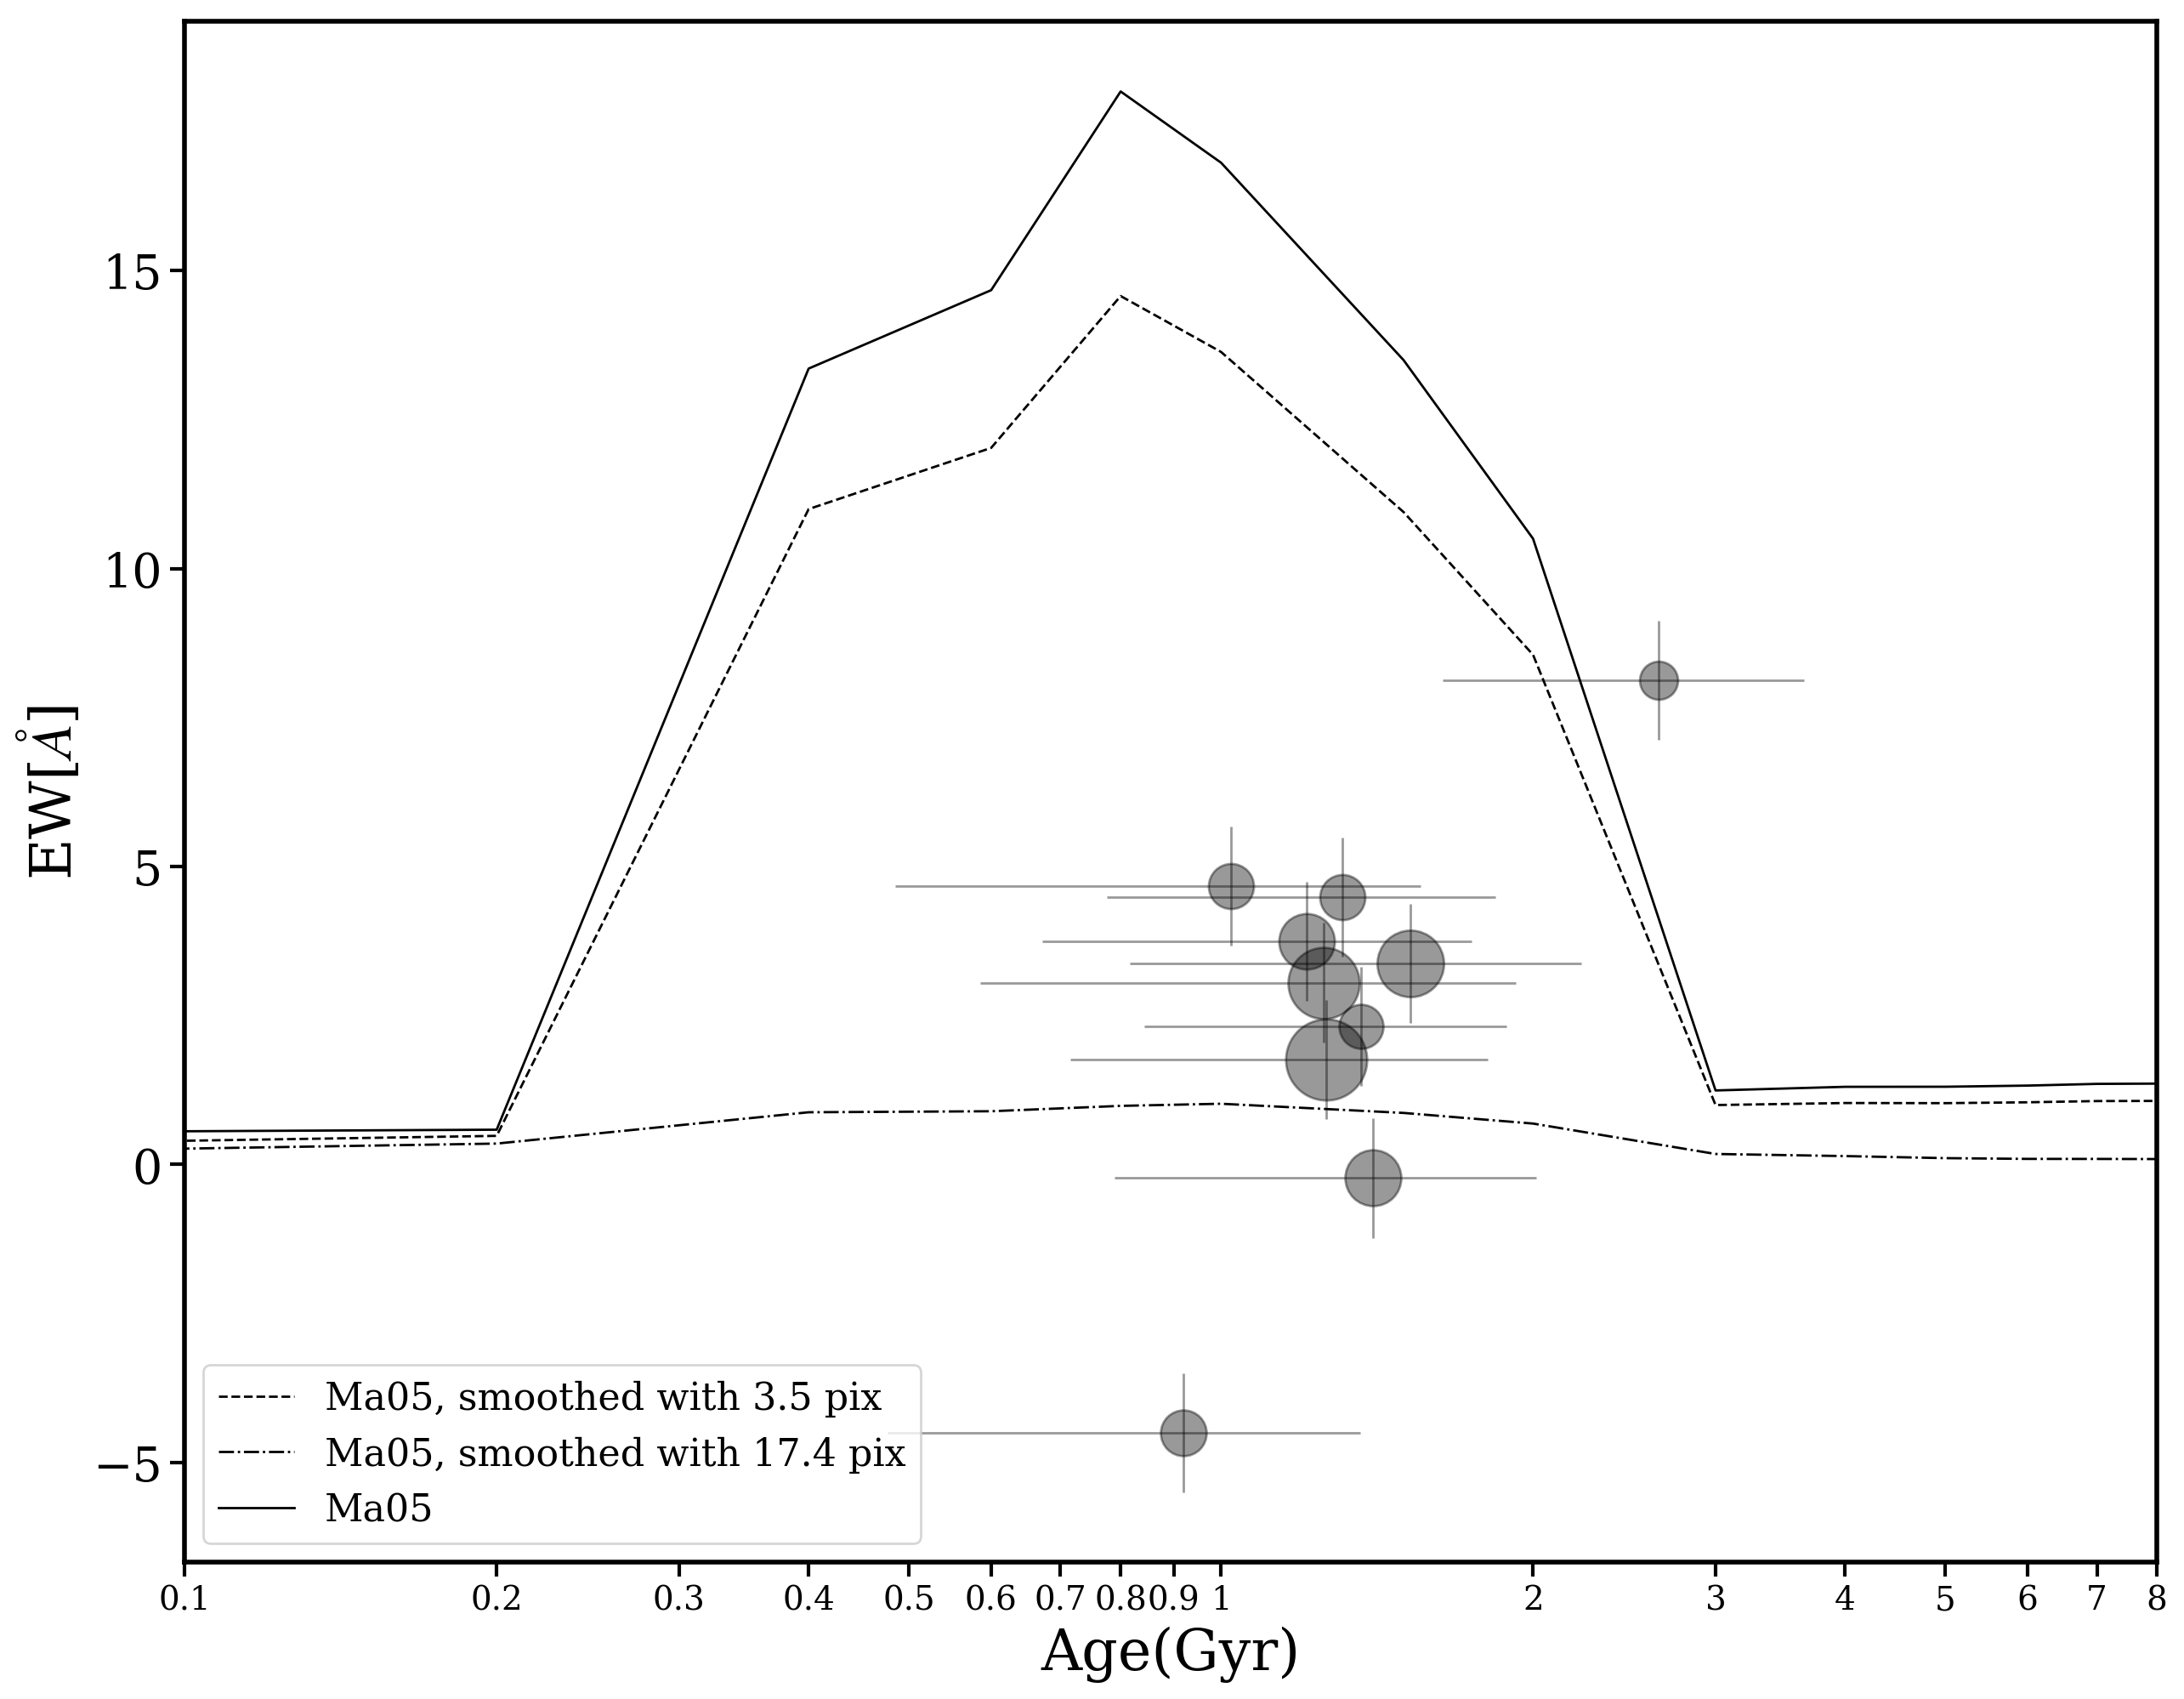

In [100]:


### CN_age plot based on new_model: scatter points
# date='20200709'
fig=plt.figure(figsize=(16,12),dpi=200)
plt.rc('lines', linewidth=1, markersize=2)
plt.rc('font', size=24, family='serif', weight=300)
plt.rc('mathtext', fontset='stix')
plt.rc('axes', linewidth=2)
plt.rc('xtick.major', width=1.5, size=6)
plt.rc('ytick.major', width=1.5, size=6)
plt.tick_params(axis='both', which='major', labelsize=20)
ax1 = fig.add_subplot(111)
# ax2 = ax1.twinx()
CN_61 = CN_list_new
CN_61 = CN_61.drop([34])
CN_61 = CN_61.reset_index(drop=True)

colorset=['indigo','k','g','orange']
fmtset = ['*','o','o','o']

for i in range(len(CN_61)):
#     print(i) 
    if CN_61.model_spec.values.astype(int)[i]==1:
        c = CN_61.model_spec.values.astype(int)[i]
        ax1.errorbar(CN_61.iloc[i].age_opt,\
                 CN_61.iloc[i].EW_AV_corr,\
                 xerr=CN_61.iloc[i].age_opt_std,\
                 yerr=CN_61.iloc[i].EW_err_AV_corr,\
                 color=colorset[c],\
                 markersize=CN_61.iloc[i].FWHM*3,\
                 alpha=0.4,\
    #              zorder=1,\
                 fmt=fmtset[c])

ax1.plot(df_Ma.Age.unique(), Lick_index_list_Ma05_smoothed_min, label='Ma05, smoothed with 3.5 pix', color='k', linestyle='--')
# ax1.plot(df_M13.Age.unique()[1:], Lick_index_list_Ma13_smoothed_min[1:], label='Ma13, smoothed with 3.5 pix', color='green', linestyle='--')
# ax1.plot(BC03_age_list_num, Lick_index_list_BC03_smoothed_min, label='BC03, smoothed with 3.5 pix', color='orange', linestyle='--')

ax1.plot(df_Ma.Age.unique(), Lick_index_list_Ma05_smoothed_max, label='Ma05, smoothed with 17.4 pix', color='k', linestyle='-.')
# ax1.plot(df_M13.Age.unique()[1:], Lick_index_list_Ma13_smoothed_max[1:], label='Ma13, smoothed with 17.4 pix', color='green', linestyle='-.')
# ax1.plot(BC03_age_list_num, Lick_index_list_BC03_smoothed_max, label='BC03, smoothed with 17.4 pix', color='orange', linestyle='-.')

ax1.plot(df_Ma.Age.unique(), Lick_index_list_Ma05, label='Ma05', color='k')
# ax1.plot(df_M13.Age.unique()[1:], Lick_index_list_Ma13[1:], label='Ma13', color='green')
# ax1.plot(BC03_age_list_num, Lick_index_list_BC03, label='BC03', color='orange')


# ax1.set_ylim([1.05, 1.22])

ax1Ys = ax1.get_yticks()
# ax2Ys = []
# for Y in ax1Ys:
#     tick = "{0:.3f}".format(2.5*np.log10(Y))
#     ax2Ys.append(tick)

# ax2.set_yticks(ax1Ys)
# ax2.set_ybound(ax1.get_ybound())
# ax2.set_yticklabels(ax2Ys)
# ax2.yaxis.set_tick_params(labelsize=16)
ax1.legend(prop={'size':16}, loc='lower left')
tick_labels=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,\
             3,4,5,6,7,8]



fig.subplots_adjust(right=0.85)
ax1.set_xlim(0.1,8)
ax1.semilogx()
ax1.set_xticks(tick_labels)
ax1.set_xticklabels(tick_labels,fontsize=14)
ax1.set_xlabel('Age(Gyr)')
ax1.set_ylabel(r'EW[$\AA$]')
# ax2.set_ylabel('mag')



fn_fig = current_dir+outcome_dir+plot_dir+'EW_CN_M05_'+date+'.png'
fig.savefig(fn_fig)


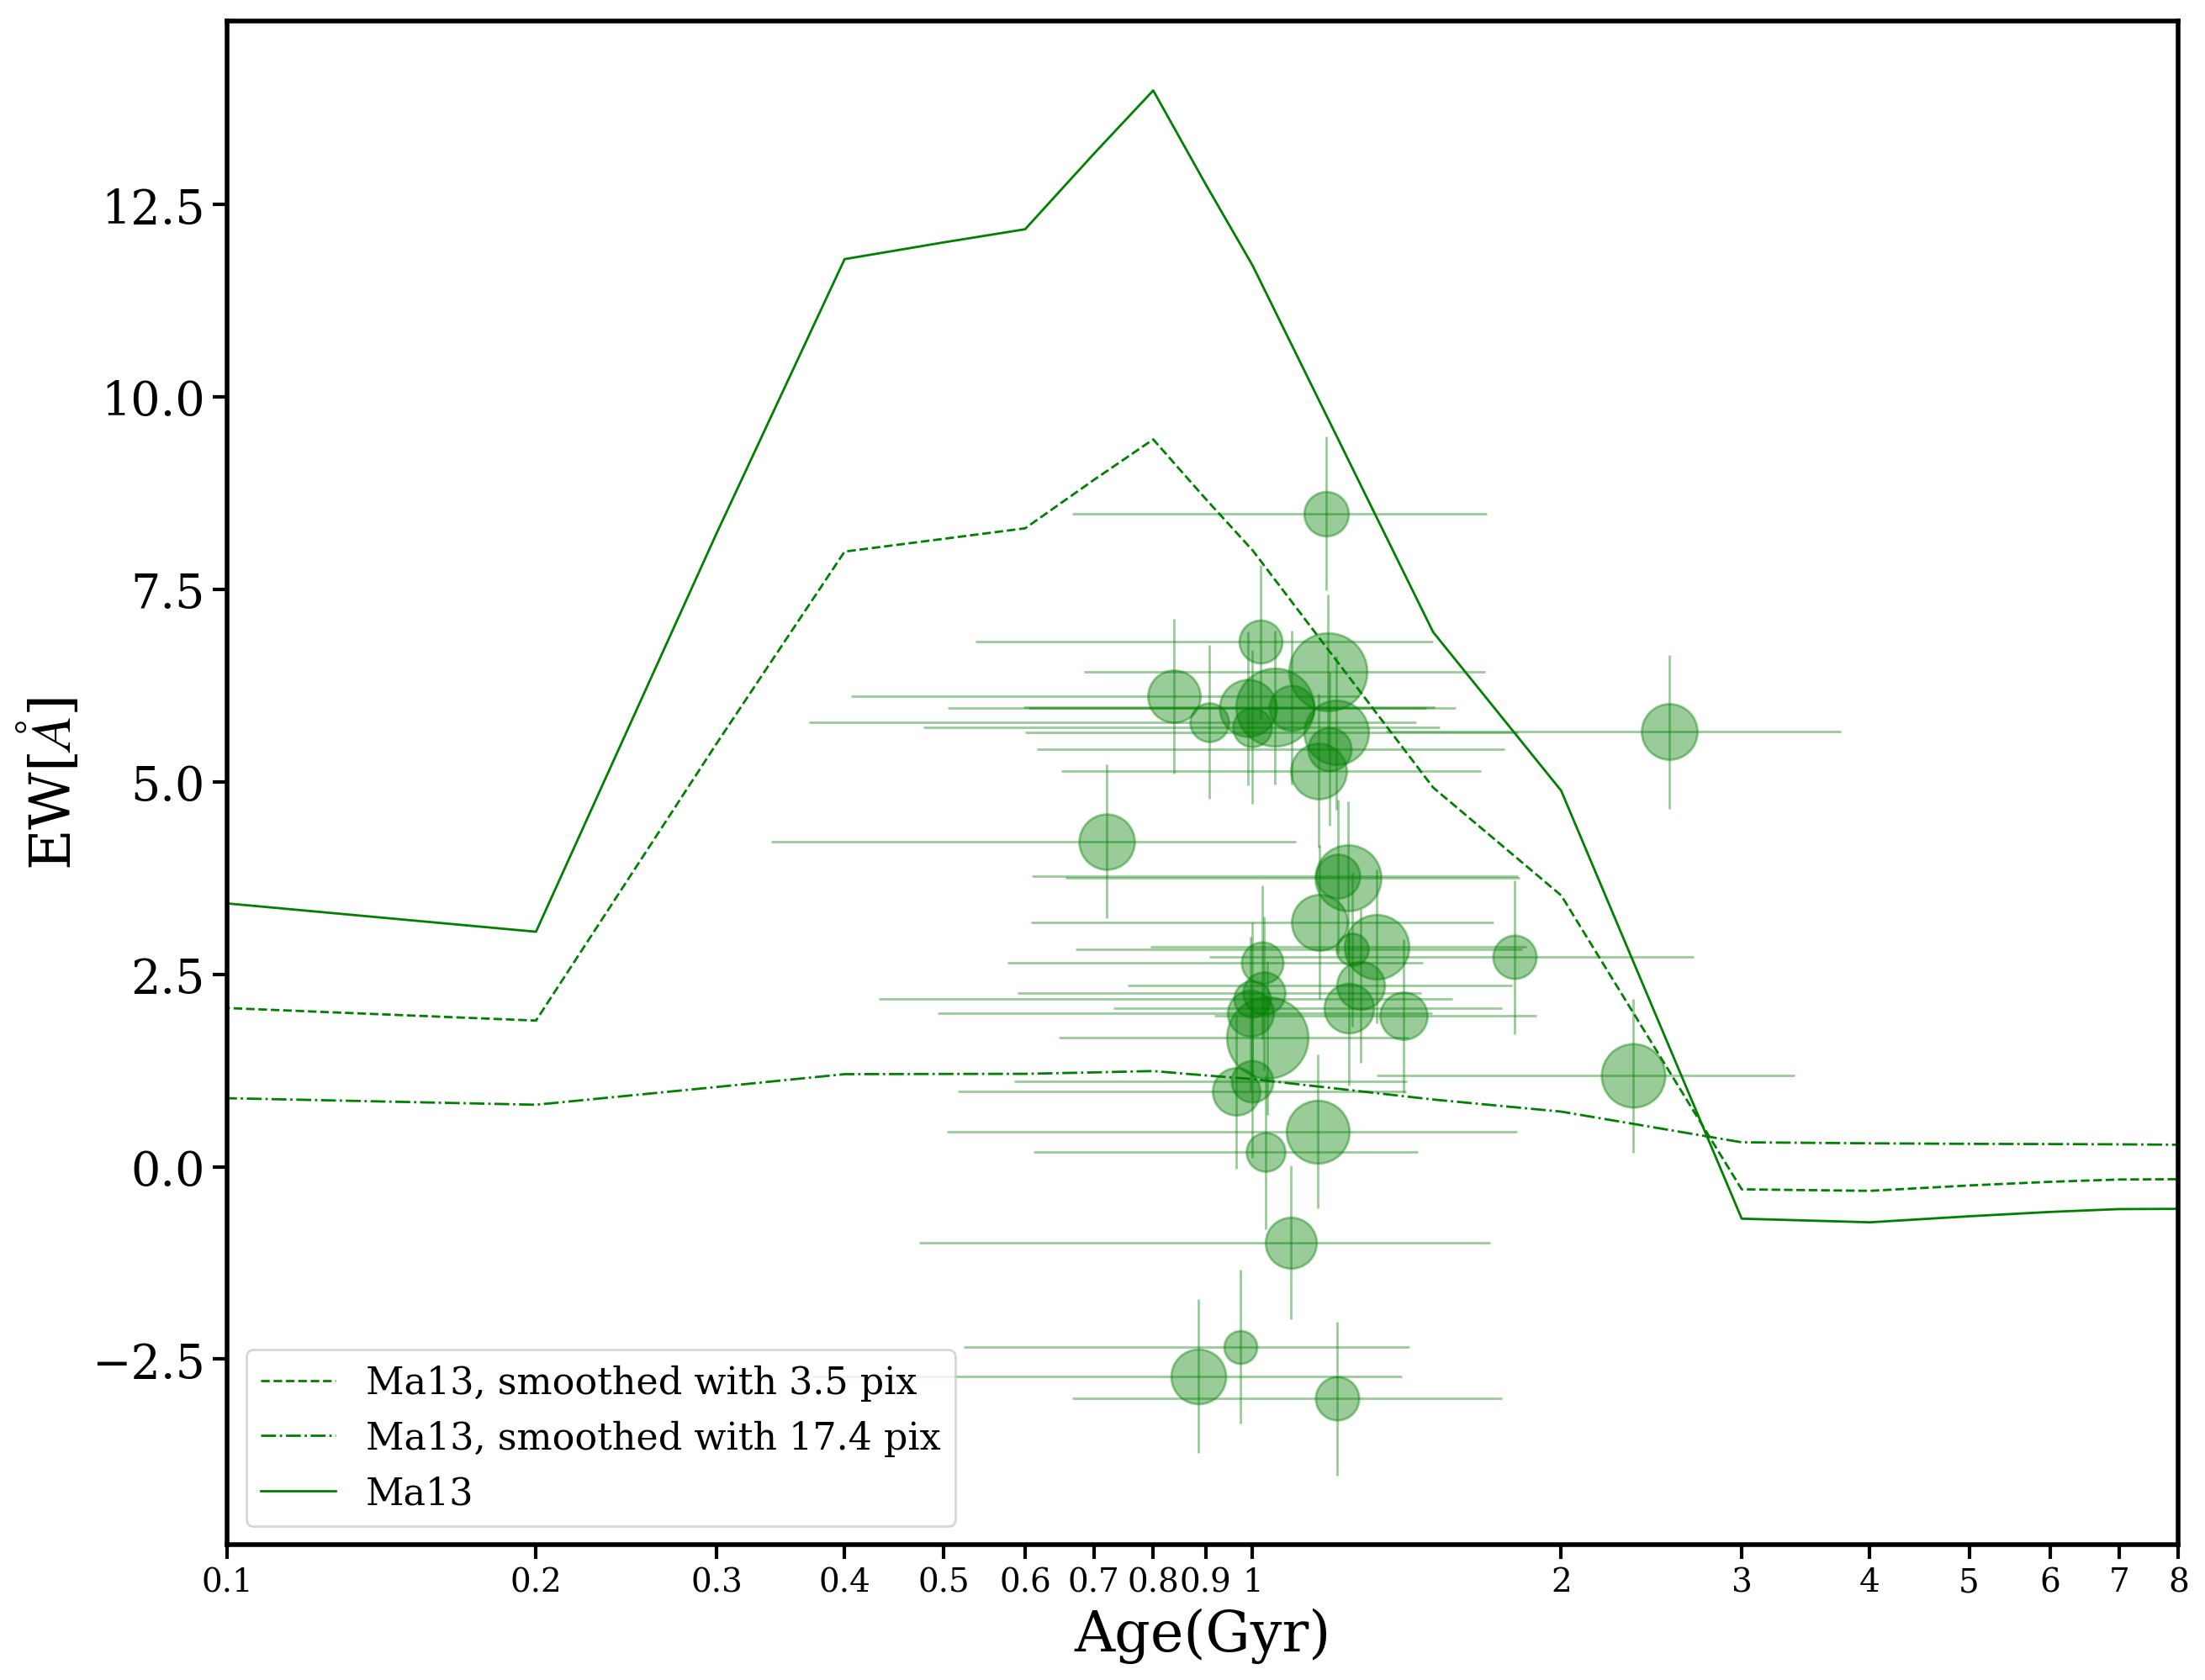

In [101]:
### CN_age plot based on new_model: scatter points
# date='20200709'
fig=plt.figure(figsize=(16,12),dpi=200)
plt.rc('lines', linewidth=1, markersize=2)
plt.rc('font', size=24, family='serif', weight=300)
plt.rc('mathtext', fontset='stix')
plt.rc('axes', linewidth=2)
plt.rc('xtick.major', width=1.5, size=6)
plt.rc('ytick.major', width=1.5, size=6)
plt.tick_params(axis='both', which='major', labelsize=20)
ax1 = fig.add_subplot(111)
# ax2 = ax1.twinx()
CN_61 = CN_list_new
CN_61 = CN_61.drop([34])
CN_61 = CN_61.reset_index(drop=True)

colorset=['indigo','k','g','orange']
fmtset = ['*','o','o','o']

for i in range(len(CN_61)):
#     print(i) 
    if CN_61.model_spec.values.astype(int)[i]==2:
        c = CN_61.model_spec.values.astype(int)[i]
        ax1.errorbar(CN_61.iloc[i].age_opt,\
                 CN_61.iloc[i].EW_AV_corr,\
                 xerr=CN_61.iloc[i].age_opt_std,\
                 yerr=CN_61.iloc[i].EW_err_AV_corr,\
                 color=colorset[c],\
                 markersize=CN_61.iloc[i].FWHM*3,\
                 alpha=0.4,\
    #              zorder=1,\
                 fmt=fmtset[c])

# ax1.plot(df_Ma.Age.unique(), Lick_index_list_Ma05_smoothed_min, label='Ma05, smoothed with 3.5 pix', color='k', linestyle='--')
ax1.plot(df_M13.Age.unique()[1:], Lick_index_list_Ma13_smoothed_min[1:], label='Ma13, smoothed with 3.5 pix', color='green', linestyle='--')
# ax1.plot(BC03_age_list_num, Lick_index_list_BC03_smoothed_min, label='BC03, smoothed with 3.5 pix', color='orange', linestyle='--')

# ax1.plot(df_Ma.Age.unique(), Lick_index_list_Ma05_smoothed_max, label='Ma05, smoothed with 17.4 pix', color='k', linestyle='-.')
ax1.plot(df_M13.Age.unique()[1:], Lick_index_list_Ma13_smoothed_max[1:], label='Ma13, smoothed with 17.4 pix', color='green', linestyle='-.')
# ax1.plot(BC03_age_list_num, Lick_index_list_BC03_smoothed_max, label='BC03, smoothed with 17.4 pix', color='orange', linestyle='-.')

# ax1.plot(df_Ma.Age.unique(), Lick_index_list_Ma05, label='Ma05', color='k')
ax1.plot(df_M13.Age.unique()[1:], Lick_index_list_Ma13[1:], label='Ma13', color='green')
# ax1.plot(BC03_age_list_num, Lick_index_list_BC03, label='BC03', color='orange')

# ax1.set_ylim([1.05, 1.22])


ax1Ys = ax1.get_yticks()
# ax2Ys = []
# for Y in ax1Ys:
#     tick = "{0:.3f}".format(2.5*np.log10(Y))
#     ax2Ys.append(tick)

# ax2.set_yticks(ax1Ys)
# ax2.set_ybound(ax1.get_ybound())
# ax2.set_yticklabels(ax2Ys)
# ax2.yaxis.set_tick_params(labelsize=16)
ax1.legend(prop={'size':16}, loc='lower left')
tick_labels=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,\
             3,4,5,6,7,8]


fig.subplots_adjust(right=0.85)
ax1.set_xlim(0.1,8)
ax1.semilogx()
ax1.set_xticks(tick_labels)
ax1.set_xticklabels(tick_labels,fontsize=14)
ax1.set_xlabel('Age(Gyr)')
ax1.set_ylabel(r'EW[$\AA$]')
# ax2.set_ylabel('mag')

# ax1.set_ylim([1.05, 1.22])



fn_fig = current_dir+outcome_dir+plot_dir+'EW_CN_M13_'+date+'.png'
fig.savefig(fn_fig)


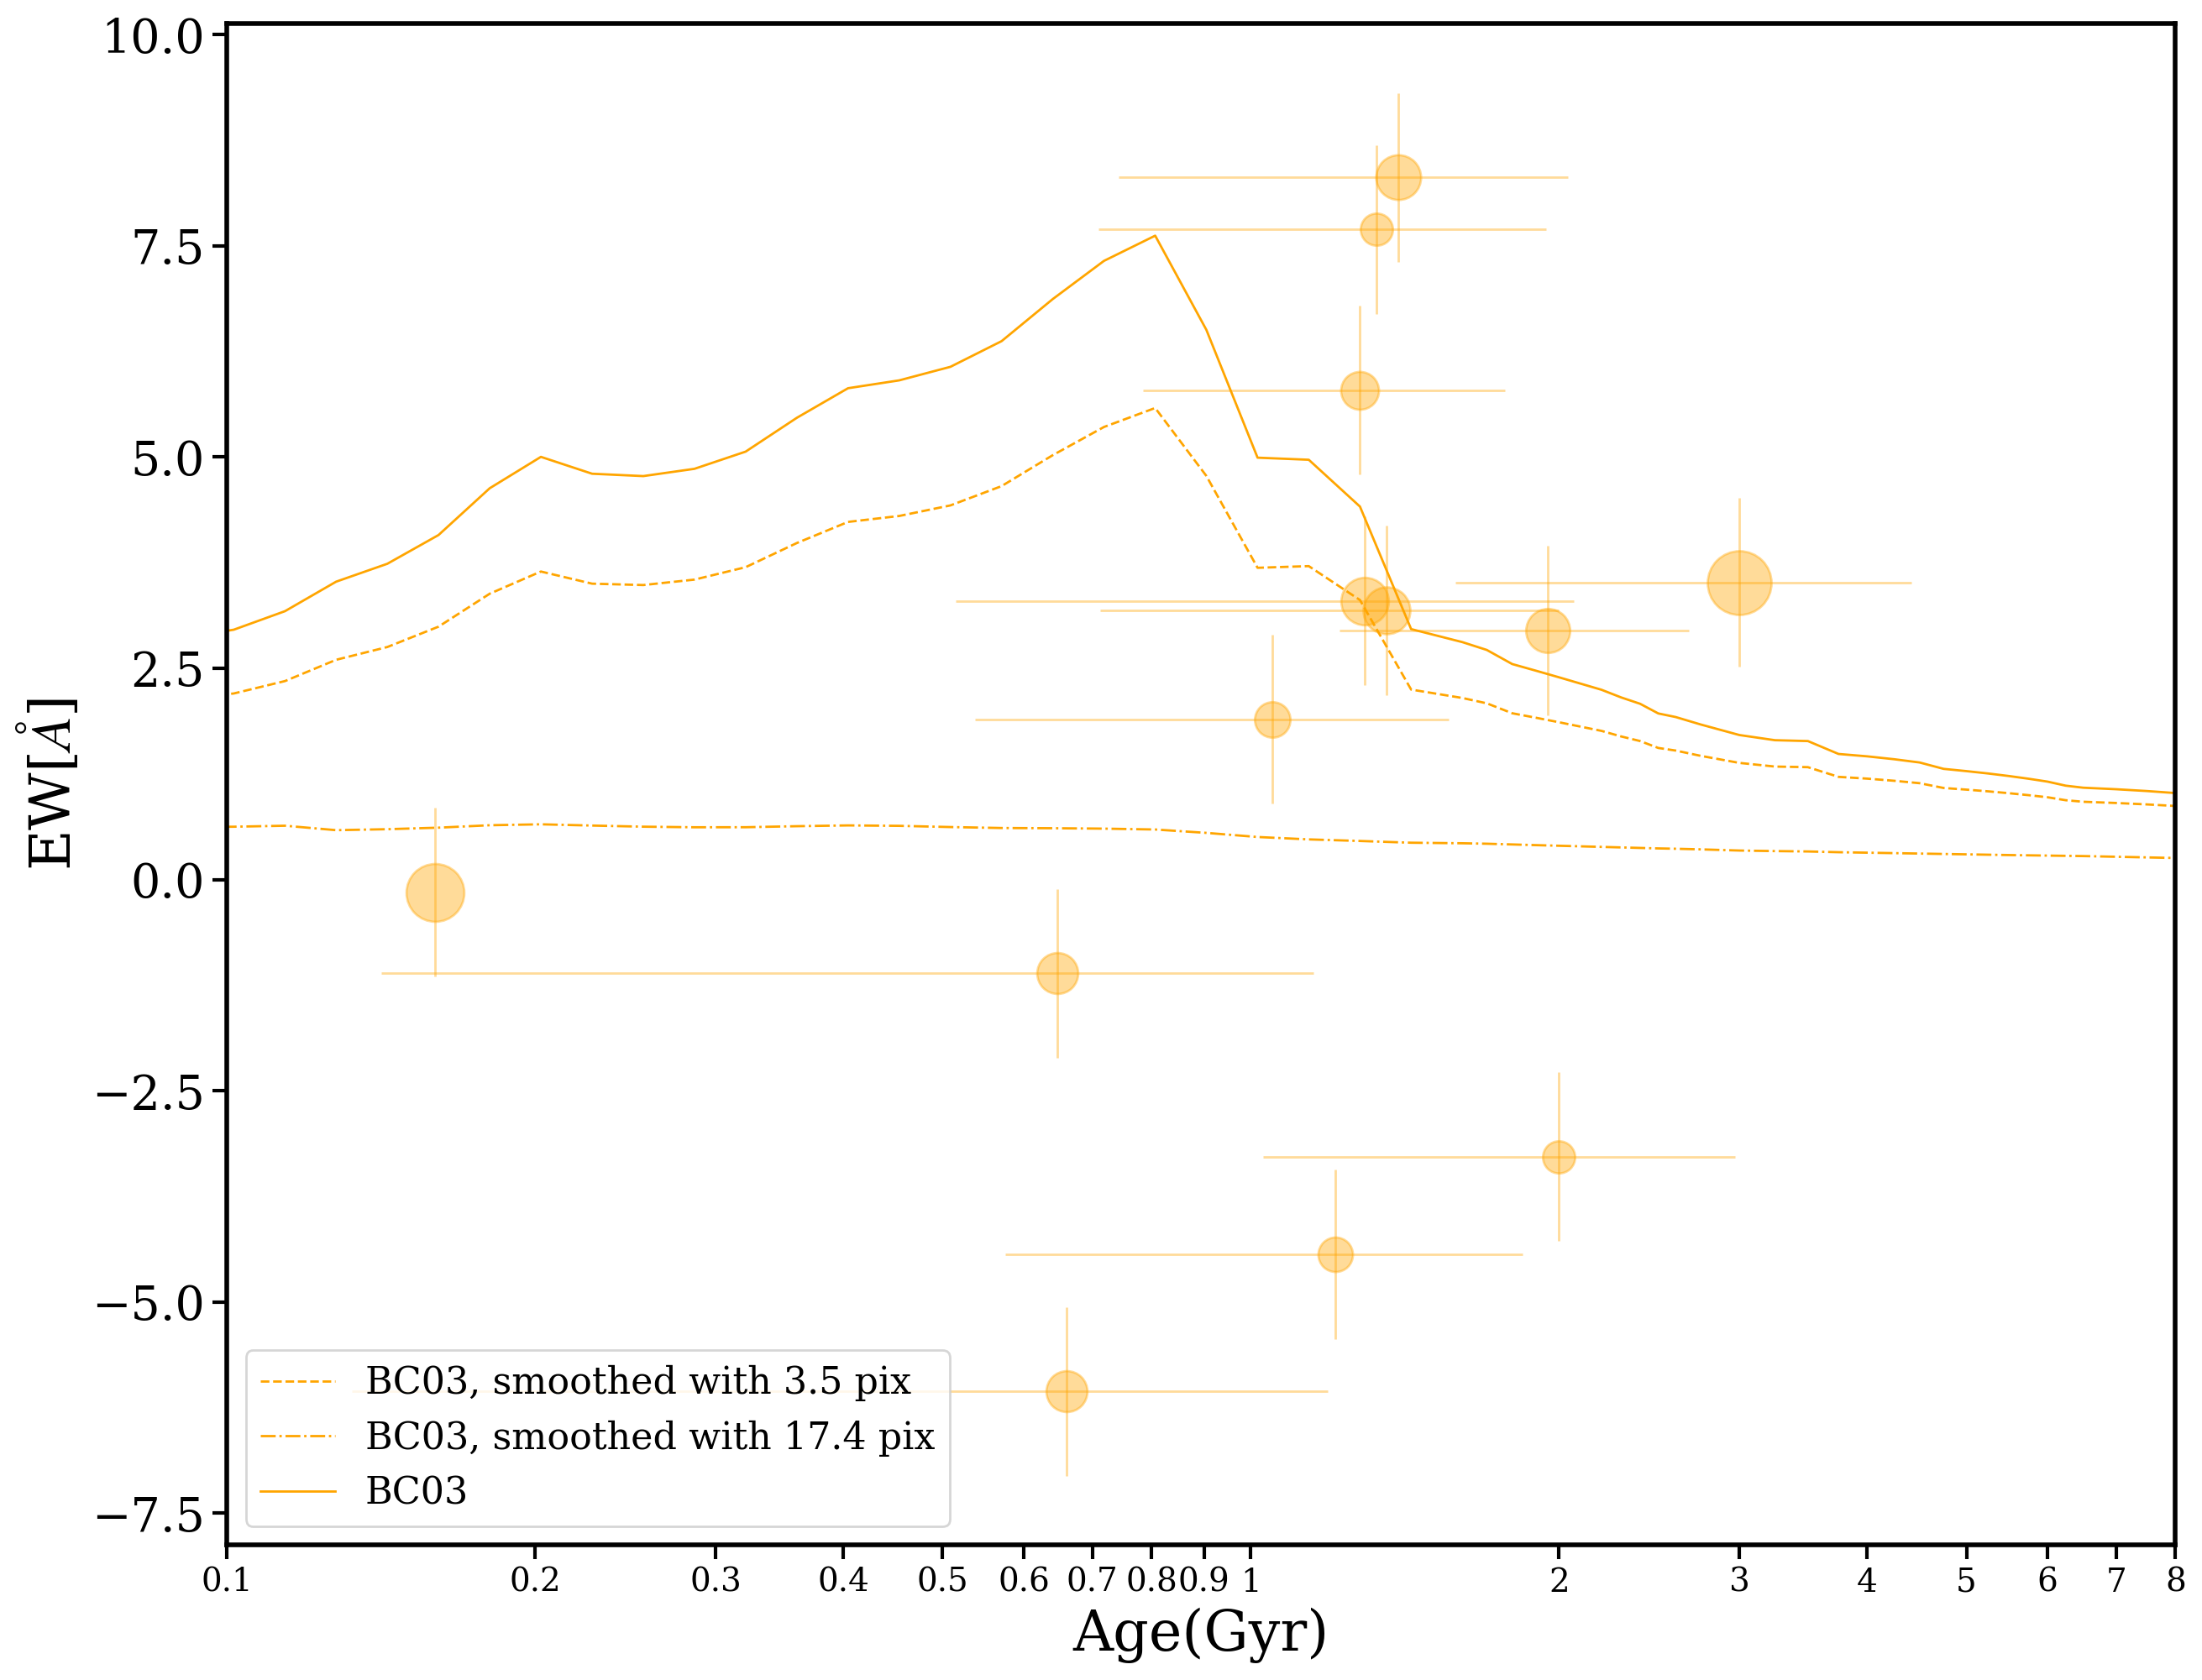

In [102]:
### CN_age plot based on new_model: scatter points
date='20200712'
fig=plt.figure(figsize=(16,12),dpi=200)
plt.rc('lines', linewidth=1, markersize=2)
plt.rc('font', size=24, family='serif', weight=300)
plt.rc('mathtext', fontset='stix')
plt.rc('axes', linewidth=2)
plt.rc('xtick.major', width=1.5, size=6)
plt.rc('ytick.major', width=1.5, size=6)
plt.tick_params(axis='both', which='major', labelsize=20)
ax1 = fig.add_subplot(111)
# ax2 = ax1.twinx()
CN_61 = CN_list_new
CN_61 = CN_61.drop([34])
CN_61 = CN_61.reset_index(drop=True)

colorset=['indigo','k','g','orange']
fmtset = ['*','o','o','o']

for i in range(len(CN_61)):
#     print(i) 
    if CN_61.model_spec.values.astype(int)[i]==3:
        c = CN_61.model_spec.values.astype(int)[i]
        ax1.errorbar(CN_61.iloc[i].age_opt,\
                 CN_61.iloc[i].EW_AV_corr,\
                 xerr=CN_61.iloc[i].age_opt_std,\
                 yerr=CN_61.iloc[i].EW_err_AV_corr,\
                 color=colorset[c],\
                 markersize=CN_61.iloc[i].FWHM*3,\
                 alpha=0.4,\
    #              zorder=1,\
                 fmt=fmtset[c])

# ax1.plot(df_Ma.Age.unique(), Lick_index_list_Ma05_smoothed_min, label='Ma05, smoothed with 3.5 pix', color='k', linestyle='--')
# ax1.plot(df_M13.Age.unique()[1:], Lick_index_list_Ma13_smoothed_min[1:], label='Ma13, smoothed with 3.5 pix', color='green', linestyle='--')
ax1.plot(BC03_age_list_num, Lick_index_list_BC03_smoothed_min, label='BC03, smoothed with 3.5 pix', color='orange', linestyle='--')

# ax1.plot(df_Ma.Age.unique(), Lick_index_list_Ma05_smoothed_max, label='Ma05, smoothed with 17.4 pix', color='k', linestyle='-.')
# ax1.plot(df_M13.Age.unique()[1:], Lick_index_list_Ma13_smoothed_max[1:], label='Ma13, smoothed with 17.4 pix', color='green', linestyle='-.')
ax1.plot(BC03_age_list_num, Lick_index_list_BC03_smoothed_max, label='BC03, smoothed with 17.4 pix', color='orange', linestyle='-.')

# ax1.plot(df_Ma.Age.unique(), Lick_index_list_Ma05, label='Ma05', color='k')
# ax1.plot(df_M13.Age.unique()[1:], Lick_index_list_Ma13[1:], label='Ma13', color='green')
ax1.plot(BC03_age_list_num, Lick_index_list_BC03, label='BC03', color='orange')

# ax1.set_ylim([1.05, 1.22])

ax1Ys = ax1.get_yticks()
# ax2Ys = []
# for Y in ax1Ys:
#     tick = "{0:.3f}".format(2.5*np.log10(Y))
#     ax2Ys.append(tick)

# ax2.set_yticks(ax1Ys)
# ax2.set_ybound(ax1.get_ybound())
# ax2.set_yticklabels(ax2Ys)
# ax2.yaxis.set_tick_params(labelsize=16)
ax1.legend(prop={'size':16}, loc='lower left')
tick_labels=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,\
             3,4,5,6,7,8]



fig.subplots_adjust(right=0.85)
ax1.set_xlim(0.1,8)
ax1.semilogx()
ax1.set_xticks(tick_labels)
ax1.set_xticklabels(tick_labels,fontsize=14)
ax1.set_xlabel('Age(Gyr)')
ax1.set_ylabel(r'EW[$\AA$]')
# ax2.set_ylabel('mag')




# ax1.set_ylim([1.05, 1.22])



fn_fig = current_dir+outcome_dir+plot_dir+'EW_CN_BC_'+date+'.png'
fig.savefig(fn_fig)


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/siqi/anaconda/envs/py37_origin/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-92-1286f87802e1>", line 26, in <module>
    CN_61.iloc[i].model_ratio_smoothed_unattenuated,\
  File "/Users/siqi/anaconda/envs/py37_origin/lib/python3.6/site-packages/pandas/core/generic.py", line 5274, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'Series' object has no attribute 'model_ratio_smoothed_unattenuated'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/siqi/anaconda/envs/py37_origin/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'AttributeError' object has no attribute '_render_traceback_'

During handling of the above exception, another

AttributeError: 'Series' object has no attribute 'model_ratio_smoothed_unattenuated'

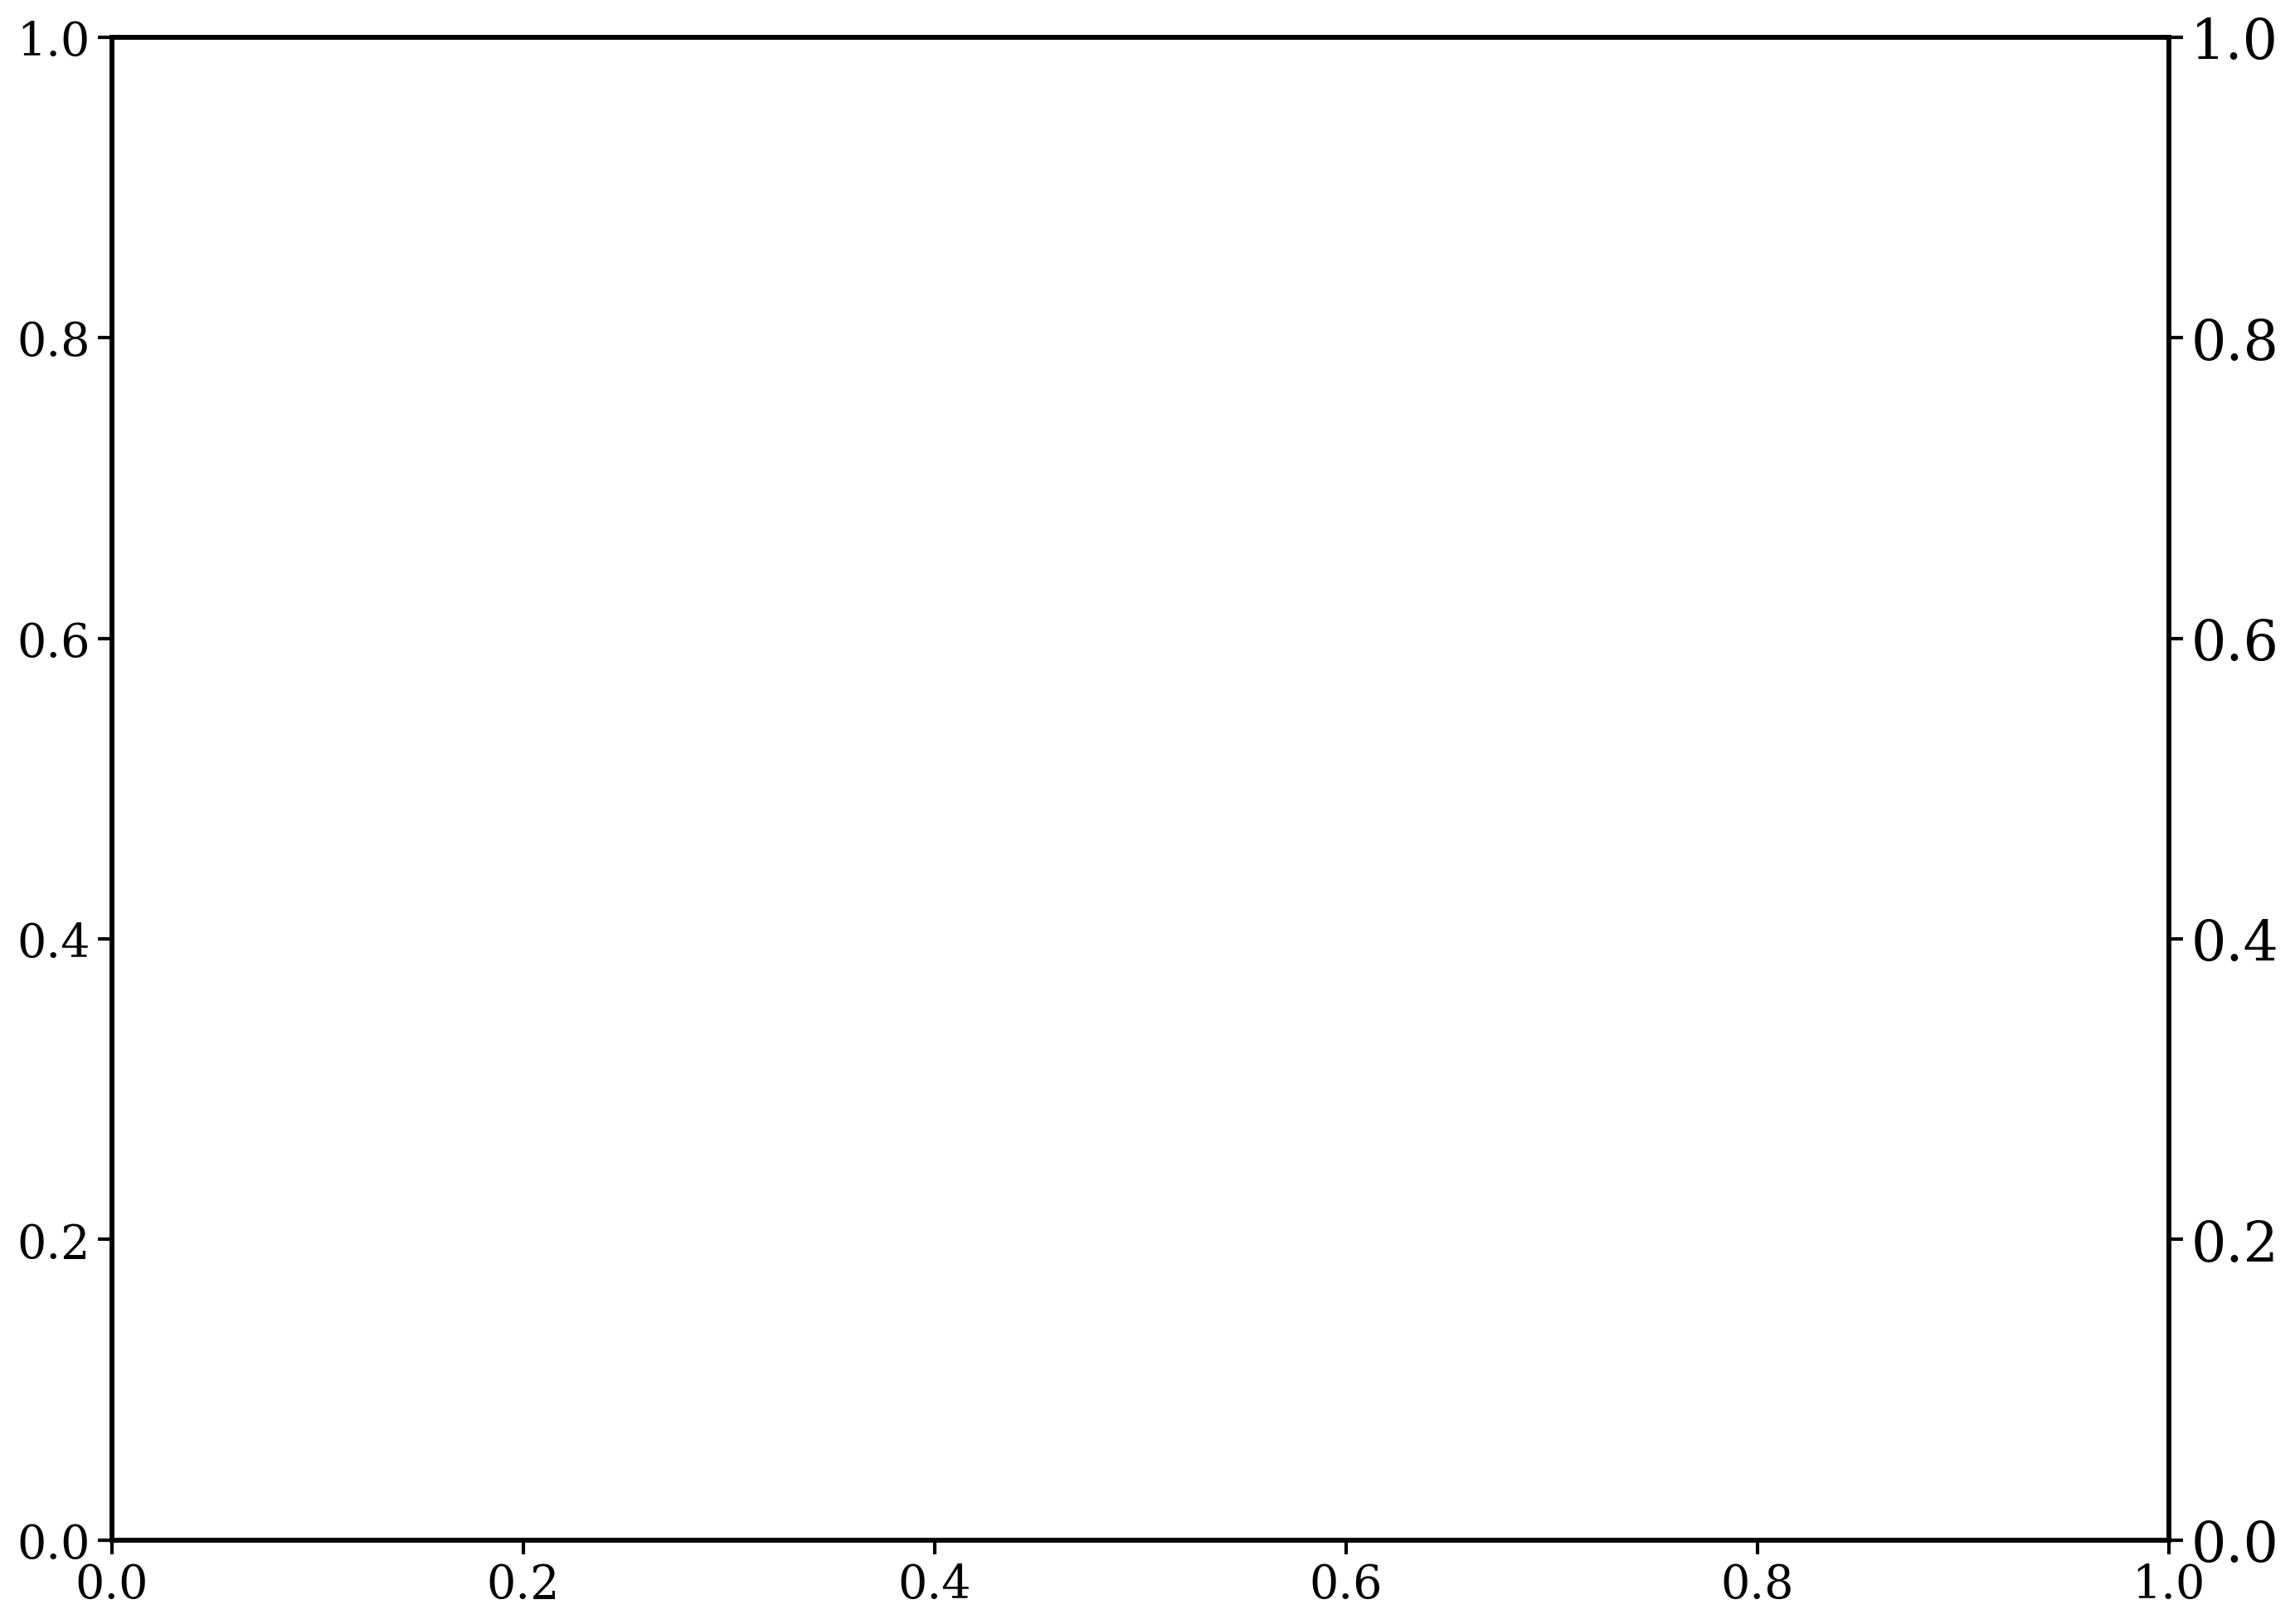

In [92]:
### CN_age plot based on new_model: scatter points of different values
# date='20200709'
fig=plt.figure(figsize=(16,12),dpi=200)
plt.rc('lines', linewidth=1, markersize=2)
plt.rc('font', size=24, family='serif', weight=300)
plt.rc('mathtext', fontset='stix')
plt.rc('axes', linewidth=2)
plt.rc('xtick.major', width=1.5, size=6)
plt.rc('ytick.major', width=1.5, size=6)
plt.tick_params(axis='both', which='major', labelsize=20)
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
CN_61 = CN_list_new_sub
CN_61 = CN_61.drop([34])
CN_61 = CN_61.reset_index(drop=True)

colorset=['indigo','k','g','orange']
fmtset = ['*','o','o','o']

#'model_ratio', 'model_ratio_unattenuated', 'model_ratio_smoothed',
#        'model_ratio_smoothed_unattenuated',
for i in range(len(CN_61)):
#     print(i)
    c = CN_61.model.values.astype(int)[i]
    ax1.errorbar(CN_61.iloc[i].age_opt,\
             CN_61.iloc[i].model_ratio_smoothed_unattenuated,\
             xerr=CN_61.iloc[i].age_opt_std,\
             yerr=CN_61.iloc[i].flux_ratio_err_AV_corr,\
             color=colorset[c],\
             markersize=10,\
             alpha=0.4,\
             zorder=10,\
             fmt=fmtset[c])

ax1.plot(df_Ma.Age.unique(), Lick_index_list_Ma05_smoothed_min, label='Ma05, smoothed with 3.5 pix', color='k', linestyle='--')
ax1.plot(df_M13.Age.unique()[1:], Lick_index_list_Ma13_smoothed_min[1:], label='Ma13, smoothed with 3.5 pix', color='green', linestyle='--')
ax1.plot(BC03_age_list_num, Lick_index_list_BC03_smoothed_min, label='BC03, smoothed with 3.5 pix', color='orange', linestyle='--')

# ax1.plot(df_Ma.Age.unique(), Lick_index_list_Ma05_smoothed_max, label='Ma05, smoothed with 17.4 pix', color='k', linestyle='-.')
# ax1.plot(df_M13.Age.unique()[1:], Lick_index_list_Ma13_smoothed_max[1:], label='Ma13, smoothed with 17.4 pix', color='green', linestyle='-.')
# ax1.plot(BC03_age_list_num, Lick_index_list_BC03_smoothed_max, label='BC03, smoothed with 17.4 pix', color='orange', linestyle='-.')

ax1.plot(df_Ma.Age.unique(), Lick_index_list_Ma05, label='Ma05', color='k')
ax1.plot(df_M13.Age.unique()[1:], Lick_index_list_Ma13[1:], label='Ma13', color='green')
ax1.plot(BC03_age_list_num, Lick_index_list_BC03, label='BC03', color='orange')



ax1Ys = ax1.get_yticks()
ax2Ys = []
for Y in ax1Ys:
    tick = "{0:.3f}".format(2.5*np.log10(Y))
    ax2Ys.append(tick)

ax2.set_yticks(ax1Ys)
ax2.set_ybound(ax1.get_ybound())
ax2.set_yticklabels(ax2Ys)
ax2.yaxis.set_tick_params(labelsize=16)
ax1.legend(prop={'size':16}, loc='lower left')
tick_labels=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,\
             3,4,5,6,7,8]


fig.subplots_adjust(right=0.85)
ax1.set_xlim(0.1,8)
ax1.semilogx()
ax1.set_xticks(tick_labels)
ax1.set_xticklabels(tick_labels,fontsize=14)
ax1.set_xlabel('Age(Gyr)')
ax1.set_ylabel('model_ratio_smoothed_unattenuated')
ax2.set_ylabel('mag')



fn_fig = current_dir+outcome_dir+plot_dir+'flux_ratio_age_mag_binned_smoothed_MC_error_'+date+'_model_ratio_smoothed_unattenuated.png'
fig.savefig(fn_fig)



In [358]:
M05 = CN_61[CN_61.model==1]
M13 = CN_61[CN_61.model==2]
BC03 = CN_61[CN_61.model==3]
TPAGB_heavy = pd.concat([M05,M13])
print(len(M05),len(M13),len(BC03),\
      len(TPAGB_heavy))

def bin_flux_ratio(group_data,bins=10):
    # the input group_data should be in the form of a dataframe
    data_cut,ret_bins = pd.qcut(group_data.age_opt.rank(method='first'),bins,retbins=True,duplicates='drop')
    print(ret_bins)
#     print(data_cut)
#     print(pd.qcut(group_data.age_opt.rank(method='first'),bins).value_counts())
    grp = group_data.groupby(by=data_cut) 
#     grp.boxplot()
#     print('grp',grp)
    ret = grp.aggregate(np.mean)  
    ret_std = grp.aggregate(np.std)
    return ret, ret_std, data_cut, ret_bins
# M05_ret, M05_std = bin_flux_ratio(M05,3)
# M13_ret, M13_std = bin_flux_ratio(M13,4)
# BC03_ret, BC03_std = bin_flux_ratio(BC03,2)
# # tot_ret, tot_std = bin_flux_ratio(CN_selected,6)
TPAGB_heavy_ret, TPAGB_heavy_std, TPAGB_heavy_data, TPAGB_heavy_bins= bin_flux_ratio(TPAGB_heavy,4)
# print(M13_ret.age_opt)
# print(M05_ret)


11 37 13 48
[ 1.   12.75 24.5  36.25 48.  ]


In [326]:
TPAGB_heavy_data

19     (36.25, 48.0]
28     (36.25, 48.0]
30     (36.25, 48.0]
33     (24.5, 36.25]
43     (24.5, 36.25]
48     (36.25, 48.0]
55     (36.25, 48.0]
56     (24.5, 36.25]
57     (36.25, 48.0]
58     (24.5, 36.25]
60     (24.5, 36.25]
1     (0.999, 12.75]
2     (0.999, 12.75]
6      (12.75, 24.5]
7     (0.999, 12.75]
8     (0.999, 12.75]
9      (12.75, 24.5]
10     (12.75, 24.5]
11    (0.999, 12.75]
12     (24.5, 36.25]
14     (12.75, 24.5]
16     (36.25, 48.0]
17     (24.5, 36.25]
18     (12.75, 24.5]
20     (36.25, 48.0]
21     (36.25, 48.0]
22     (36.25, 48.0]
23    (0.999, 12.75]
24    (0.999, 12.75]
25     (24.5, 36.25]
29     (12.75, 24.5]
31     (24.5, 36.25]
32     (12.75, 24.5]
34     (36.25, 48.0]
36     (24.5, 36.25]
38    (0.999, 12.75]
39     (12.75, 24.5]
40     (24.5, 36.25]
42     (24.5, 36.25]
44    (0.999, 12.75]
45    (0.999, 12.75]
46    (0.999, 12.75]
49     (12.75, 24.5]
50     (36.25, 48.0]
51     (12.75, 24.5]
52     (12.75, 24.5]
54     (12.75, 24.5]
59    (0.999,

In [357]:
TPAGB_heavy_ret.age_opt.values

array([0.80499561, 1.02834948, 1.1840022 , 1.42553318])

(0.5, 2)

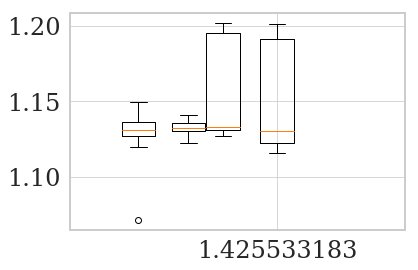

In [363]:
# type(TPAGB_heavy_data)
TPAGB_heavy['bins']=TPAGB_heavy_data
# TPAGB_heavy.bins
TPAGB_heavy_1 = TPAGB_heavy[TPAGB_heavy.bins==pd.Interval(left=0.999, right=12.75)]
TPAGB_heavy_2 = TPAGB_heavy[TPAGB_heavy.bins==pd.Interval(left=12.75, right=24.5)]
TPAGB_heavy_3 = TPAGB_heavy[TPAGB_heavy.bins==pd.Interval(left=24.5, right=36.25)]
TPAGB_heavy_4 = TPAGB_heavy[TPAGB_heavy.bins==pd.Interval(left=36.25, right=48.0)]
# plt.boxplot(TPAGB_heavy.model_ratio,positions=TPAGB_heavy.bins)
# plt.figure(figsize=(12,5),dpi=50)
# sns.boxplot(y='model_ratio', x='bins', data=TPAGB_heavy_1)
# TPAGB_heavy.bins.values[0]
# TPAGB_heavy_1
# TPAGB_heavy_1.boxplot()
# TPAGB_heavy_1.boxplot(column=['model_ratio'])
plt.boxplot(TPAGB_heavy_1.model_ratio.values,positions=np.array([TPAGB_heavy_ret.age_opt.values[0]]))
plt.boxplot(TPAGB_heavy_2.model_ratio.values,positions=np.array([TPAGB_heavy_ret.age_opt.values[1]]))
plt.boxplot(TPAGB_heavy_3.model_ratio.values,positions=np.array([TPAGB_heavy_ret.age_opt.values[2]]))
plt.boxplot(TPAGB_heavy_4.model_ratio.values,positions=np.array([TPAGB_heavy_ret.age_opt.values[3]]))


plt.xlim(0.5,2)
# plt.boxplot(TPAGB_heavy_1.model_ratio.values,0.80499561)

In [298]:
# M05_ret, M05_std = bin_flux_ratio(M05,3)
print(M05_ret.age_opt.values)
M05.groupby('age_opt')
pd.qcut(M05.age_opt.rank(method='first'),3,retbins=True,duplicates='drop')[1]
# M05['c'] = pd.qcut(M05.age_opt.rank(method='first'),3,retbins=True,duplicates='drop')
# M05_ret.boxplot(column="age_opt")

[1.17086394 1.25583704 1.68486837]


array([ 1.        ,  4.33333333,  7.66666667, 11.        ])

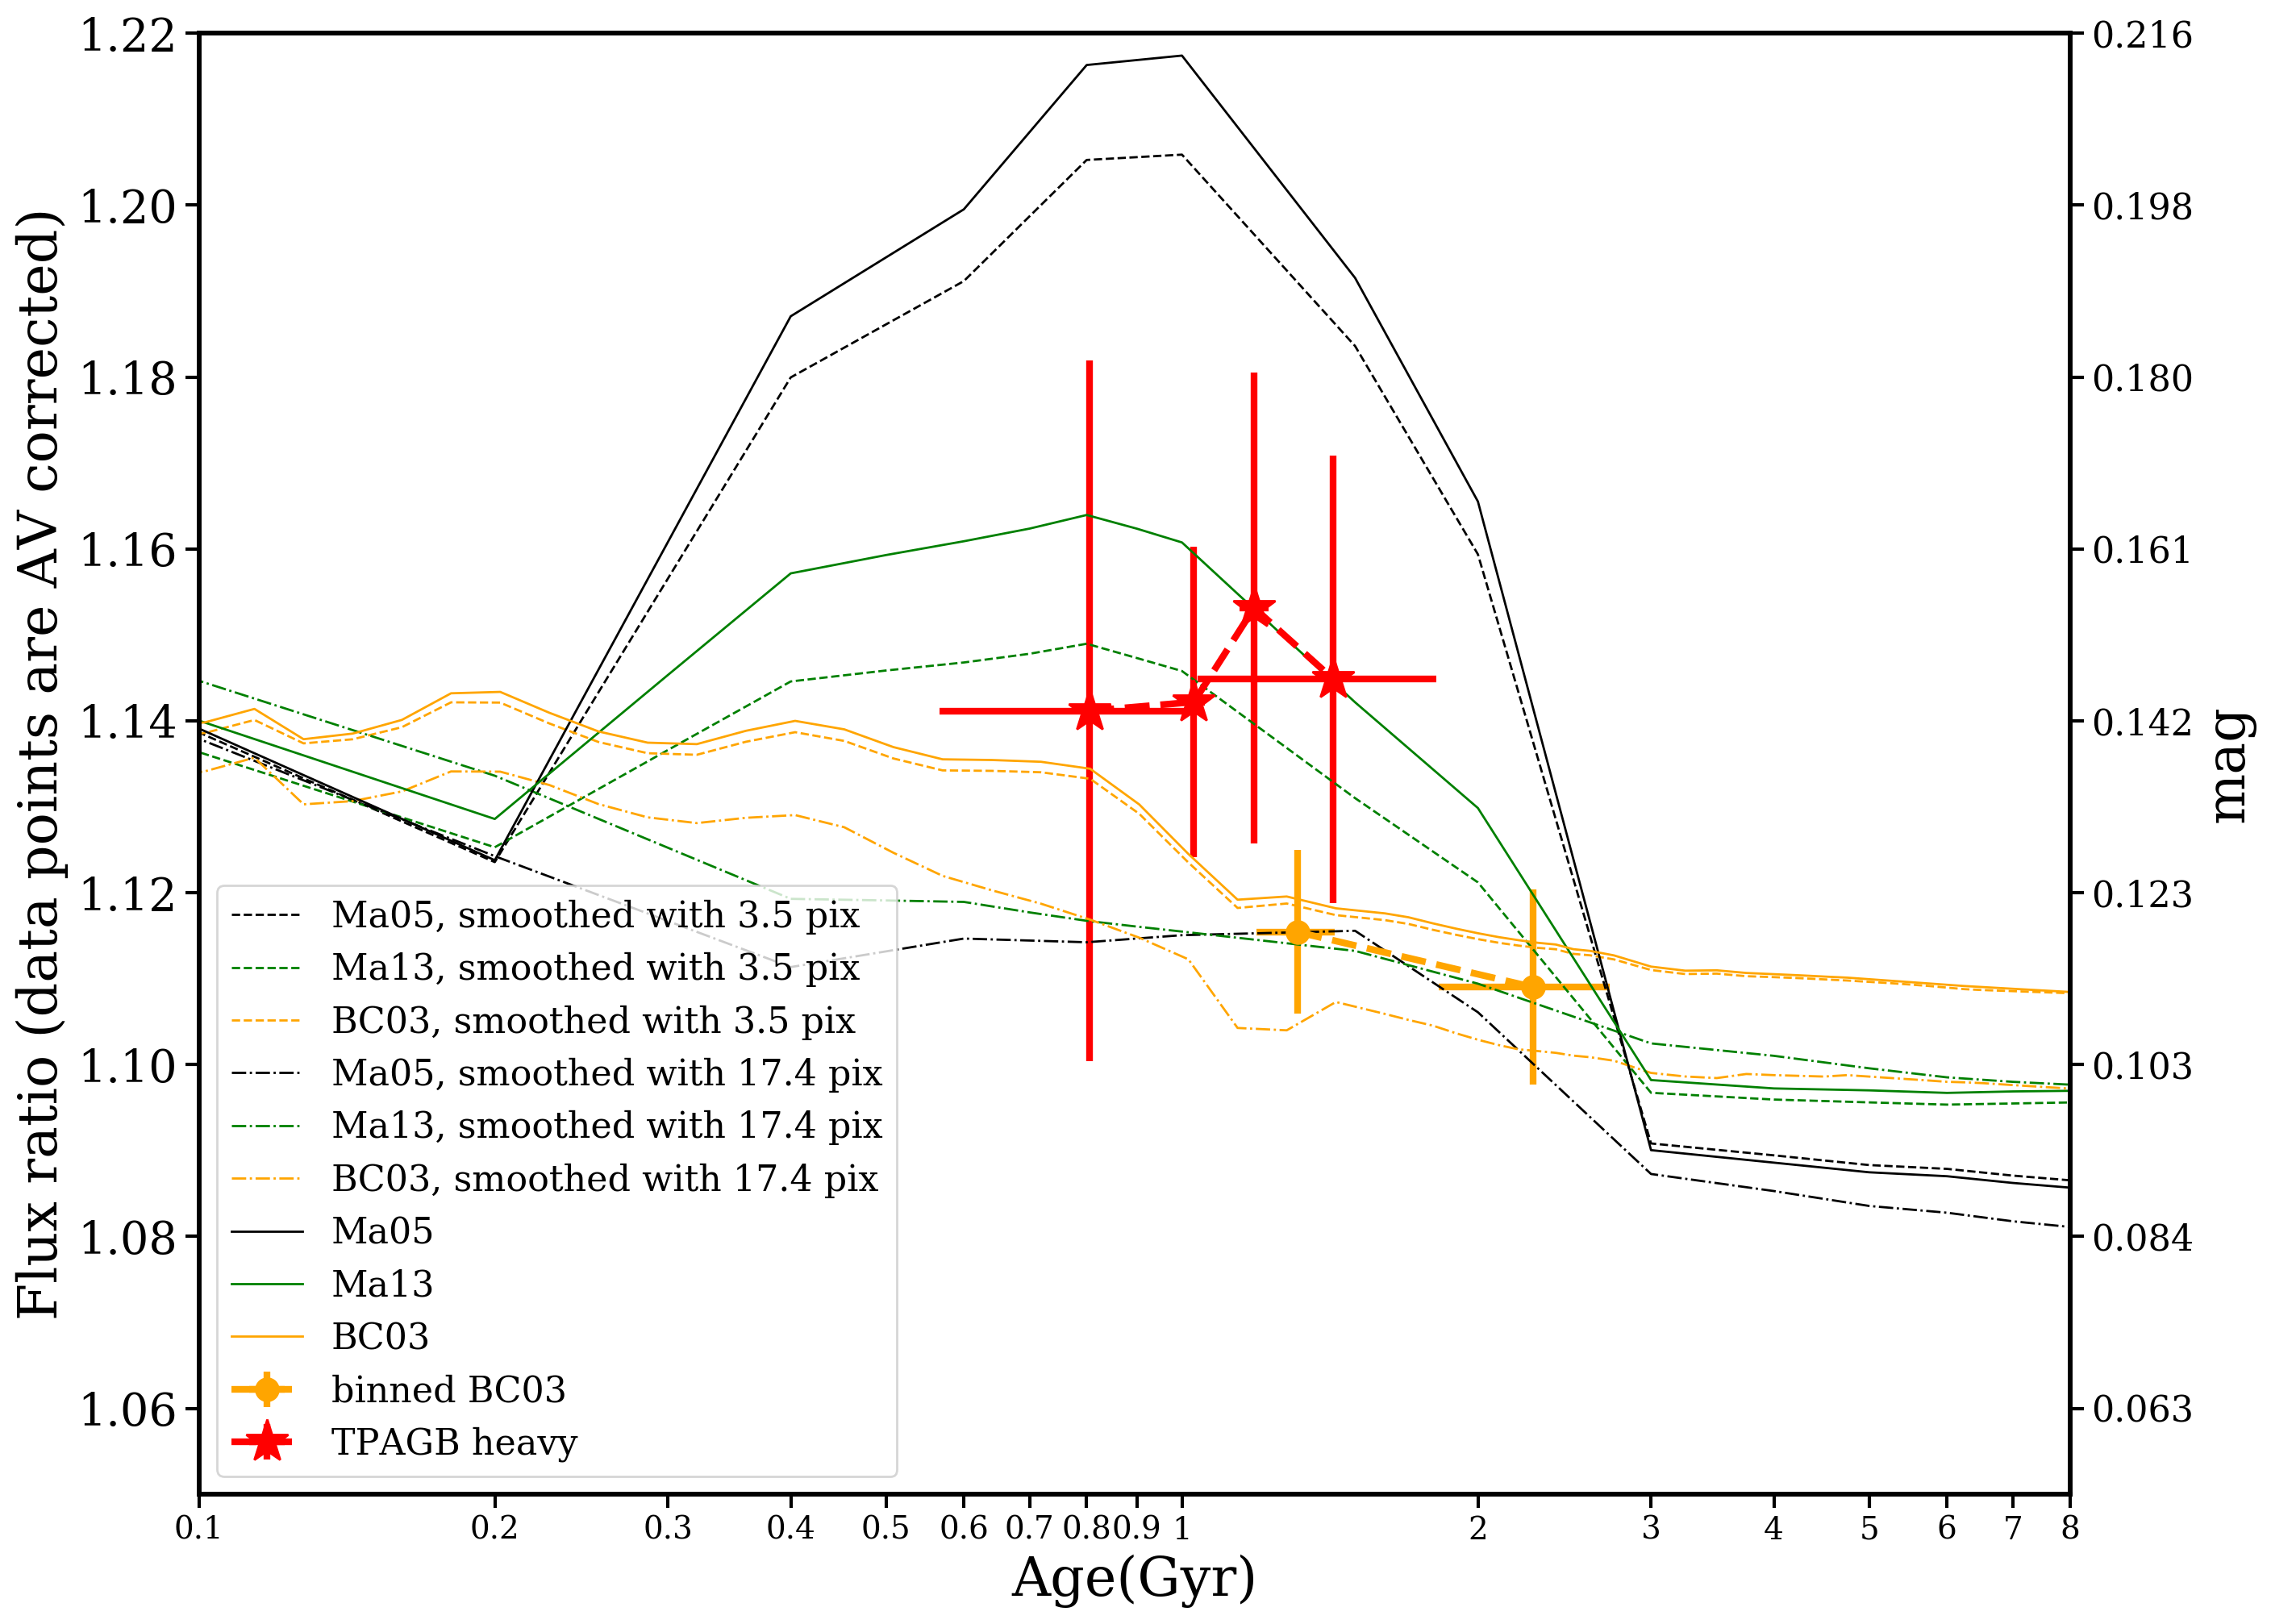

In [225]:
# based on model_new
date ='20200705'
fig=plt.figure(figsize=(16,12),dpi=200)
plt.rc('lines', linewidth=1, markersize=2)
plt.rc('font', size=24, family='serif', weight=300)
plt.rc('mathtext', fontset='stix')
plt.rc('axes', linewidth=2)
plt.rc('xtick.major', width=1.5, size=6)
plt.rc('ytick.major', width=1.5, size=6)
plt.tick_params(axis='both', which='major', labelsize=20)

ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
# CN_69=CN_69

colorset=['indigo','k','g','orange']

# attenuated
ax1.plot(df_Ma.Age.unique(), Lick_index_list_Ma05_smoothed_min, label='Ma05, smoothed with 3.5 pix', color='k', linestyle='--')
ax1.plot(df_M13.Age.unique()[1:], Lick_index_list_Ma13_smoothed_min[1:], label='Ma13, smoothed with 3.5 pix', color='green', linestyle='--')
ax1.plot(BC03_age_list_num, Lick_index_list_BC03_smoothed_min, label='BC03, smoothed with 3.5 pix', color='orange', linestyle='--')

ax1.plot(df_Ma.Age.unique(), Lick_index_list_Ma05_smoothed_max, label='Ma05, smoothed with 17.4 pix', color='k', linestyle='-.')
ax1.plot(df_M13.Age.unique()[1:], Lick_index_list_Ma13_smoothed_max[1:], label='Ma13, smoothed with 17.4 pix', color='green', linestyle='-.')
ax1.plot(BC03_age_list_num, Lick_index_list_BC03_smoothed_max, label='BC03, smoothed with 17.4 pix', color='orange', linestyle='-.')


ax1.plot(df_Ma.Age.unique(), Lick_index_list_Ma05, label='Ma05', color='k')
ax1.plot(df_M13.Age.unique()[1:], Lick_index_list_Ma13[1:], label='Ma13', color='green')
ax1.plot(BC03_age_list_num, Lick_index_list_BC03, label='BC03', color='orange')


# ax1.errorbar(M05_ret.age_opt.values, 
#              M05_ret.flux_ratio_AV_corr.values, 
#              xerr=M05_std.age_opt.values,\
#              yerr=M05_std.flux_ratio_AV_corr.values,\
#          color='k',label='binned M05',lw=3,fmt='--o',markersize=10);
# ax1.errorbar(M13_ret.age_opt.values, 
#              M13_ret.flux_ratio_AV_corr.values, \
#              xerr=M13_std.age_opt.values,\
#              yerr=M13_std.flux_ratio_AV_corr.values,\
#          color='green',label='binned M13',lw=3,fmt='--o',markersize=10);
ax1.errorbar(BC03_ret.age_opt.values, 
             BC03_ret.model_ratio_smoothed_unattenuated.values,\
             xerr=BC03_std.age_opt.values,\
             yerr=BC03_std.flux_ratio_AV_corr.values, color='orange',\
         label='binned BC03',lw=3,fmt='--o',markersize=10);
# ax1.plot(tot_ret.age_opt.dropna(),tot_ret.flux_ratio_AV_corr.dropna(),\
#          label='tot',marker='o',color='indigo',lw=3,markersize=10);
ax1.errorbar(TPAGB_heavy_ret.age_opt.values, 
             TPAGB_heavy_ret.model_ratio_smoothed_unattenuated.values,\
             xerr=TPAGB_heavy_std.age_opt.values,\
             yerr=TPAGB_heavy_std.flux_ratio_AV_corr.values,\
         label='TPAGB heavy',fmt='--*',color='red',lw=3,markersize=20);
ax1.set_ylim([1.05, 1.21])
ax1.set_ylim([1.05, 1.22])
ax1Ys = ax1.get_yticks()
ax2Ys = []
for Y in ax1Ys:
    tick = "{0:.3f}".format(2.5*np.log10(Y))
    ax2Ys.append(tick)

ax2.set_yticks(ax1Ys)
ax2.set_ybound(ax1.get_ybound())
ax2.set_yticklabels(ax2Ys)
ax2.yaxis.set_tick_params(labelsize=16)
ax1.legend(prop={'size':16}, loc='lower left')
tick_labels=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,\
             3,4,5,6,7,8]

fig.subplots_adjust(right=0.85)
ax1.set_xlim(0.1,8)
ax1.semilogx()
ax1.set_xticks(tick_labels)
ax1.set_xticklabels(tick_labels,fontsize=14)
ax1.set_xlabel('Age(Gyr)')
ax1.set_ylabel('Flux ratio (data points are AV corrected)')
# ax1.set_ylabel('model_ratio_smoothed')
ax2.set_ylabel('mag')
# ax1.axvline(0.1)
# ax1.axvline(3)

fn_fig = current_dir+outcome_dir+plot_dir+\
         'Flux_ratio_model_smoothed_binned_'+date+'_model_ratio_smoothed_unattenuated.png'
# fig.savefig(fn_fig)

[1.14115643 1.14219398 1.15314598 1.14484359]
4


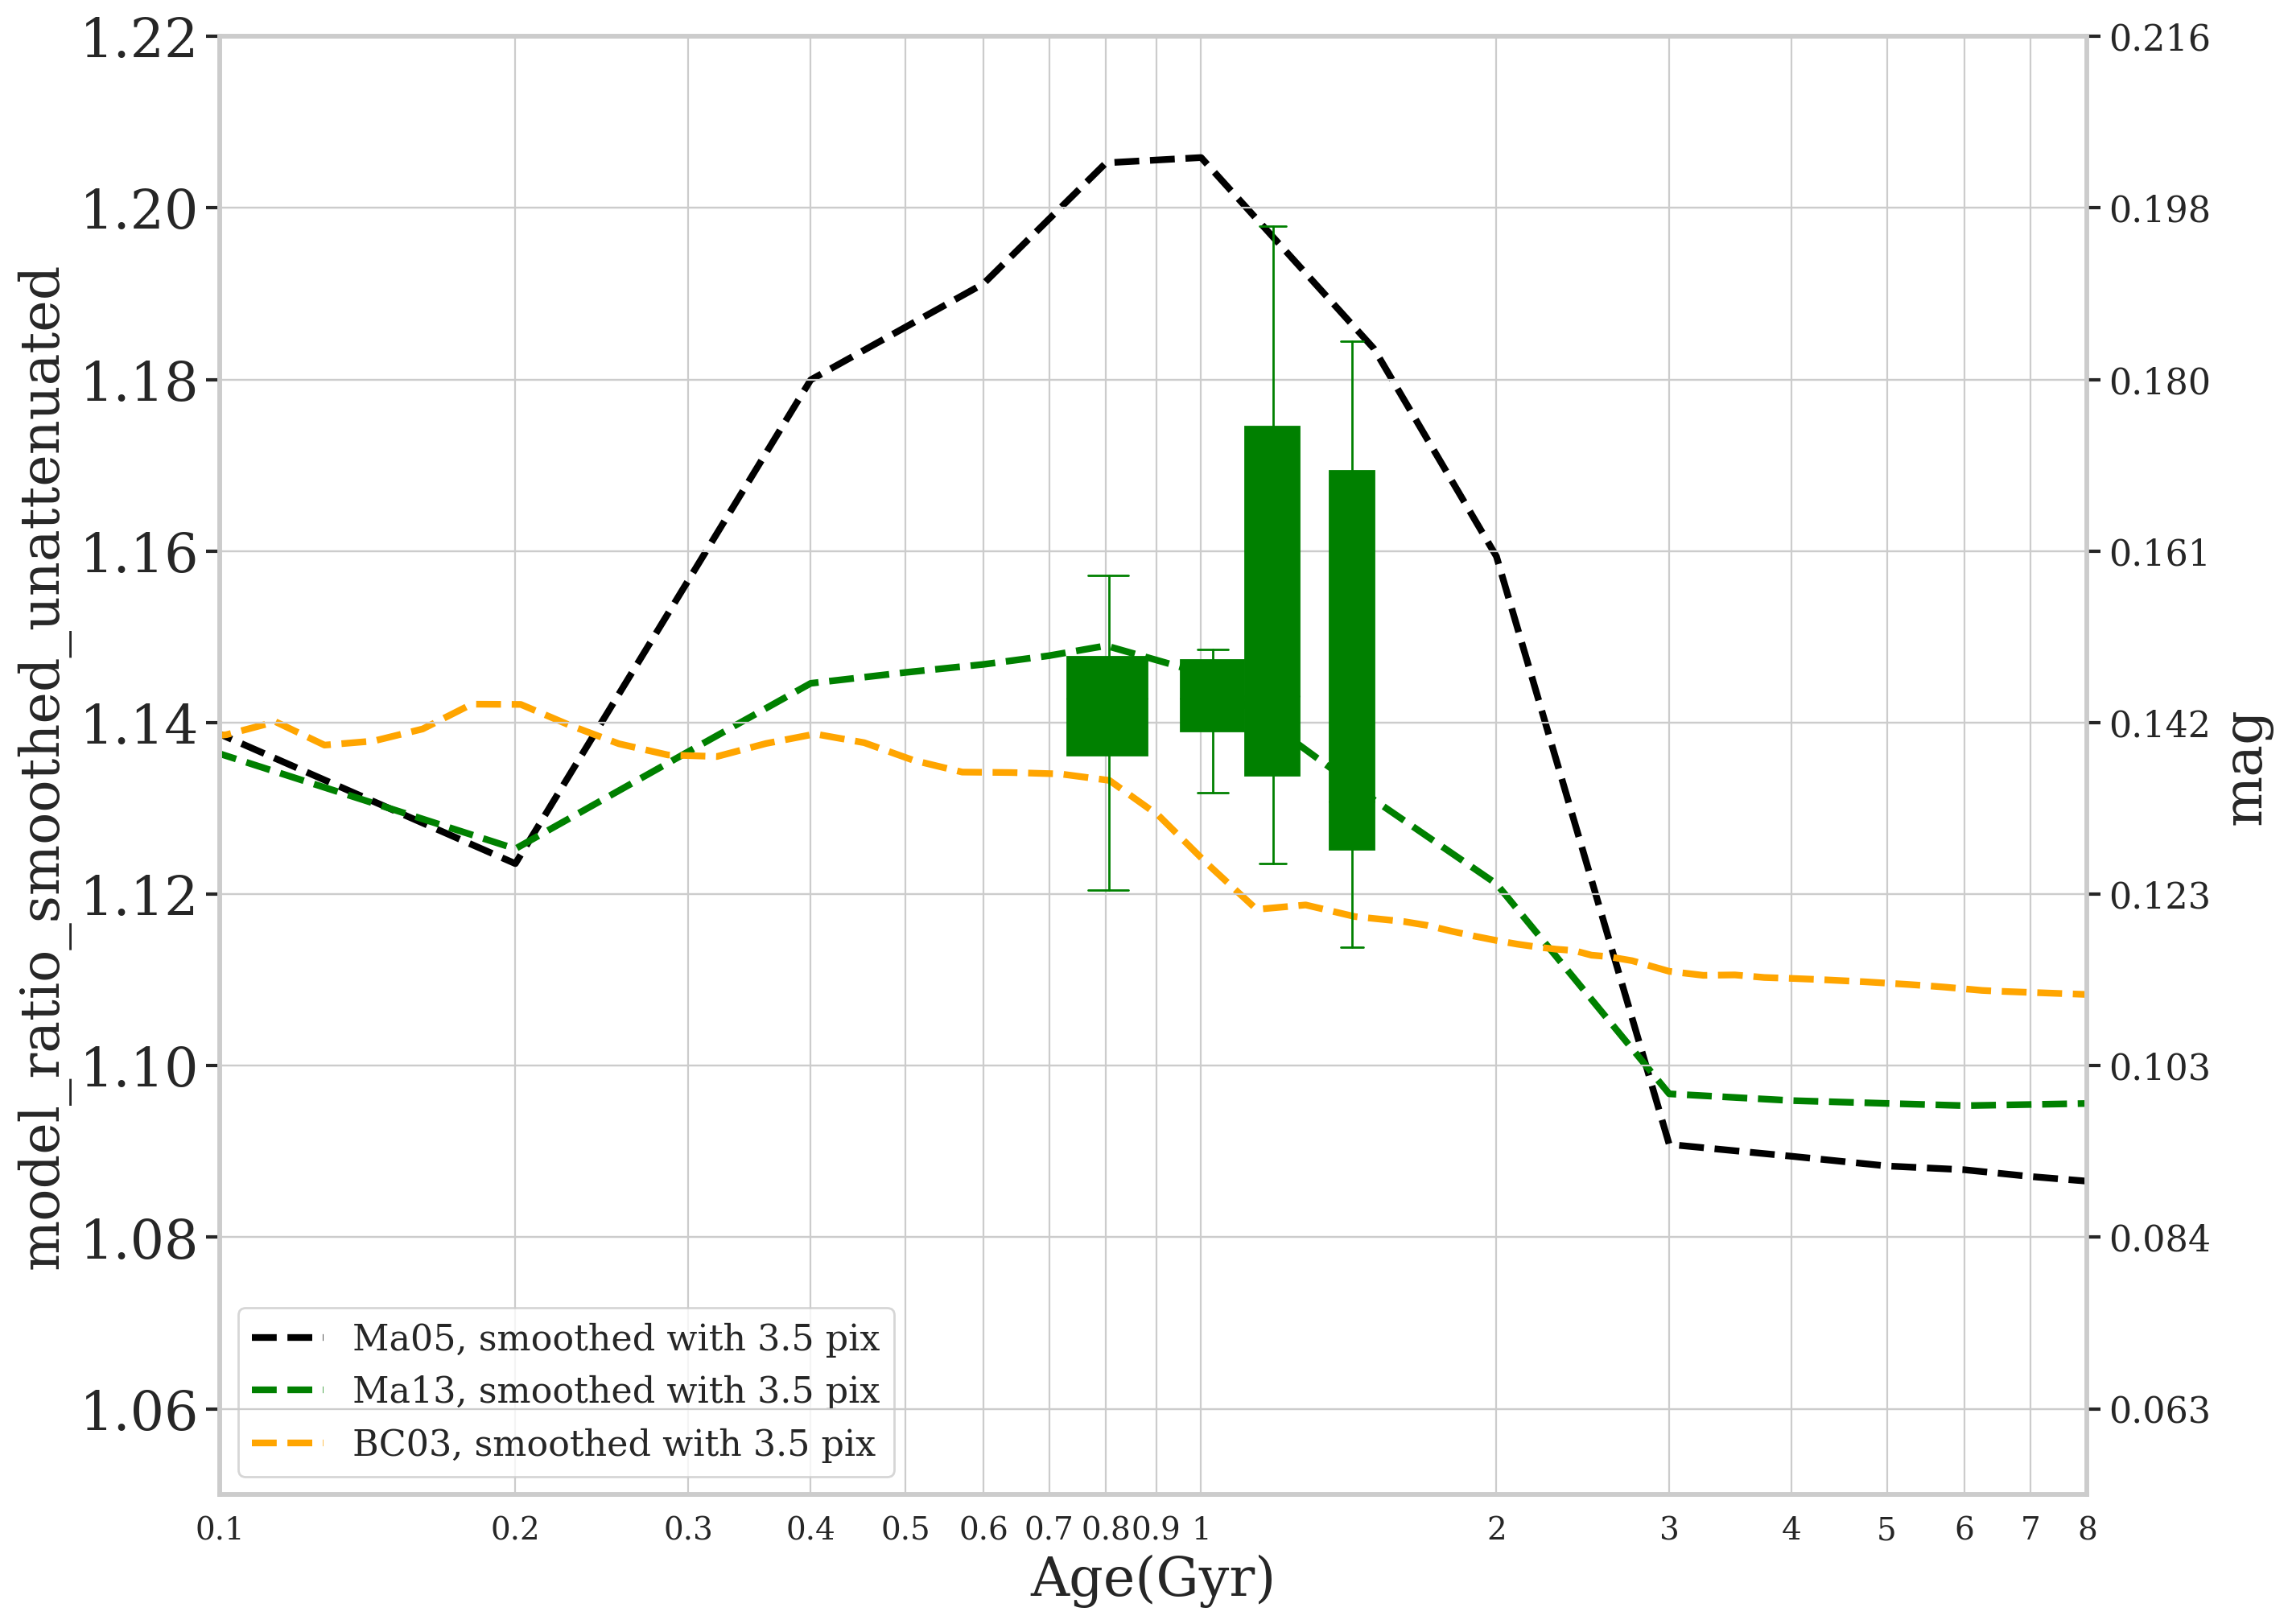

In [369]:
fig=plt.figure(figsize=(16,12),dpi=200)

ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
# Fixing random state for reproducibility
# np.random.seed(19680801)

# fake up some data
# spread = #np.random.rand(50) * 100
# center = np.ones(25) * 50
# flier_high = np.random.rand(10) * 100 + 100
# flier_low = np.random.rand(10) * -100
# data = np.concatenate((spread, center, flier_high, flier_low))

ax1.plot(df_Ma.Age.unique(), Lick_index_list_Ma05_smoothed_min, 
         label='Ma05, smoothed with 3.5 pix', color='k', linestyle='--')
ax1.plot(df_M13.Age.unique()[1:], Lick_index_list_Ma13_smoothed_min[1:], 
         label='Ma13, smoothed with 3.5 pix', color='green', linestyle='--')
ax1.plot(BC03_age_list_num, Lick_index_list_BC03_smoothed_min, 
         label='BC03, smoothed with 3.5 pix', color='orange', linestyle='--')


# fig, axs = plt.subplots(2, 3)

# basic plot
# axs[0, 0].boxplot(data)
# ax1.boxplot(TPAGB_heavy.model_ratio_smoothed_unattenuated.values,
#              positions=TPAGB_heavy.age_opt.values)
# pd.boxplot(TPAGB_heavy)
# pd.DataFrame.boxplot(TPAGB_heavy,return_type = 'both')
# boxplot = df.boxplot(column=['Col1', 'Col2', 'Col3'])
#                 notch=1, bootstrap=5000,
#                 usermedians=medians,
#                 conf_intervals=conf_intervals)
print(TPAGB_heavy_ret.model_ratio_smoothed_unattenuated.values)
print(len(TPAGB_heavy_ret.model_ratio_smoothed_unattenuated.values))
# plt.boxplot(TPAGB_heavy_1.flux_ratio_AV_corr.values,pos
#             positions=pd.qcut(TPAGB_heavy.age_opt.rank(method='first'),3,retbins=True,duplicates='drop')[1])

# print(TPAGB_heavy_ret.model_ratio_smoothed_unattenuated.values)
# print(TPAGB_heavy_ret.age_opt.values)

# import seaborn as sns
# sns.set_style('whitegrid')
# sns.boxplot(x='age_opt',y='model_ratio_smoothed_unattenuated',data=TPAGB_heavy_ret)
#
c='green'
plt.boxplot(TPAGB_heavy_1.model_ratio_smoothed_unattenuated.values,
            positions=np.array([TPAGB_heavy_ret.age_opt.values[0]]),
           patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),)
plt.boxplot(TPAGB_heavy_2.model_ratio_smoothed_unattenuated.values,
            positions=np.array([TPAGB_heavy_ret.age_opt.values[1]]),
            patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),)
plt.boxplot(TPAGB_heavy_3.model_ratio_smoothed_unattenuated.values,
            positions=np.array([TPAGB_heavy_ret.age_opt.values[2]]),
           patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),)
plt.boxplot(TPAGB_heavy_4.model_ratio_smoothed_unattenuated.values,
            positions=np.array([TPAGB_heavy_ret.age_opt.values[3]]),
           patch_artist=True,
            boxprops=dict(facecolor=c, color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),)




ax1.set_ylim([1.05, 1.21])
ax1.set_ylim([1.05, 1.22])
ax1Ys = ax1.get_yticks()
ax2Ys = []
for Y in ax1Ys:
    tick = "{0:.3f}".format(2.5*np.log10(Y))
    ax2Ys.append(tick)

ax2.set_yticks(ax1Ys)
ax2.set_ybound(ax1.get_ybound())
ax2.set_yticklabels(ax2Ys)
ax2.yaxis.set_tick_params(labelsize=16)
ax1.legend(prop={'size':16}, loc='lower left')
tick_labels=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,\
             3,4,5,6,7,8]

fig.subplots_adjust(right=0.85)
ax1.set_xlim(0.1,8)
ax1.semilogx()
ax1.set_xticks(tick_labels)
ax1.set_xticklabels(tick_labels,fontsize=14)
ax1.set_xlabel('Age(Gyr)')
# ax1.set_ylabel('Flux ratio (data points are AV corrected)')
ax1.set_ylabel('model_ratio_smoothed_unattenuated')
ax2.set_ylabel('mag')
fn_fig = current_dir+outcome_dir+plot_dir+'flux_ratio_boxplot'+date+'_model_ratio_smoothed_unattenuated.png'
fig.savefig(fn_fig)

In [18]:
from bokeh.plotting import Figure,figure, output_file, show, ColumnDataSource
from bokeh.models import HoverTool, CrosshairTool, CustomJS, Label
from bokeh.layouts import column, row, gridplot
from bokeh.models.widgets import Button, RadioButtonGroup, Select, Slider
from bokeh.models import BasicTicker, ColorBar, ColumnDataSource, LinearColorMapper, PrintfTickFormatter
from bokeh.io import output_notebook, show
from bokeh.util.compiler import TypeScript

TS_CODE = """
import * as p from "core/properties"
import {Label, LabelView} from "models/annotations/label"
declare const katex: any

export class LatexLabelView extends LabelView {
  model: LatexLabel

  render(): void {
    //--- Start of copied section from ``Label.render`` implementation

    // Here because AngleSpec does units tranform and label doesn't support specs
    let angle: number
    switch (this.model.angle_units) {
      case "rad": {
        angle = -this.model.angle
        break
      }
      case "deg": {
        angle = (-this.model.angle * Math.PI) / 180.0
        break
      }
      default:
        throw new Error("unreachable code")
    }

    const panel = this.panel != null ? this.panel : this.plot_view.frame

    const xscale = this.plot_view.frame.xscales[this.model.x_range_name]
    const yscale = this.plot_view.frame.yscales[this.model.y_range_name]

    let sx = this.model.x_units == "data" ? xscale.compute(this.model.x) : panel.xview.compute(this.model.x)
    let sy = this.model.y_units == "data" ? yscale.compute(this.model.y) : panel.yview.compute(this.model.y)

    sx += this.model.x_offset
    sy -= this.model.y_offset

    //--- End of copied section from ``Label.render`` implementation
    // Must render as superpositioned div (not on canvas) so that KaTex
    // css can properly style the text
    this._css_text(this.layer.ctx, "", sx, sy, angle)

    // ``katex`` is loaded into the global window at runtime
    // katex.renderToString returns a html ``span`` element
    katex.render(this.model.text, this.el, {displayMode: true})
  }
}

export namespace LatexLabel {
  export type Attrs = p.AttrsOf<Props>

  export type Props = Label.Props
}

export interface LatexLabel extends LatexLabel.Attrs {}

export class LatexLabel extends Label {
  properties: LatexLabel.Props
  __view_type__: LatexLabelView

  constructor(attrs?: Partial<LatexLabel.Attrs>) {
    super(attrs)
  }

  static init_LatexLabel() {
    this.prototype.default_view = LatexLabelView
  }
}
"""

class LatexLabel(Label):
    """A subclass of the Bokeh built-in `Label` that supports rendering
    LaTex using the KaTex typesetting library.

    Only the render method of LabelView is overloaded to perform the
    text -> latex (via katex) conversion. Note: ``render_mode="canvas``
    isn't supported and certain DOM manipulation happens in the Label
    superclass implementation that requires explicitly setting
    `render_mode='css'`).
    """
    __javascript__ = ["https://cdnjs.cloudflare.com/ajax/libs/KaTeX/0.6.0/katex.min.js"]
    __css__ = ["https://cdnjs.cloudflare.com/ajax/libs/KaTeX/0.6.0/katex.min.css"]
    __implementation__ = TypeScript(TS_CODE)



In [21]:
output_file("CN-age-EW.html",title='Grism measurements with AV correction')
# envcat is a dataframe that contains ID, redshift, RA, DEC, and Density_Contrast
# sfh_imgs is a list that contains all the filenames for the images I want to hover over
sfh_imgs = CN_61.fig_name.values
# print(sfh_imgs)

colorset=['indigo','black','green','orange']
fmtset = ['*','o','o','o']
  
    
color_list =[colorset[i] for i in CN_61.model_spec.values.astype(int)]
print(color_list)
source = ColumnDataSource(data=dict(
    x=CN_61.age_opt,
    y=CN_61.EW_AV_corr,
    desc=CN_61.ID,
    model = color_list,
    imgs= sfh_imgs,
    env_od = CN_61.field,
    env_region = CN_61.region,
))

TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"

TOOLTIPS = """
    <div>
        <div>
            <img
                src="@imgs" height="200" alt="@imgs" width="500"
                style="float: left; margin: 0px 15px 15px 0px;"
                border="0"
            ></img>
        </div>
        <div>
            <span style="font-size: 15px; color: #966;">Field: @env_od, region: @env_region, Galaxy Id: @desc </span>
        </div>
        <div>
            <span style="font-size: 15px; color: #696;"></span>
        </div>
    </div>
"""

p = figure(plot_width=800, plot_height=800, tooltips=TOOLTIPS,
           x_axis_type="log",x_range=(0.1,5),y_range=(-8, 16),
           title="CN-age plot", tools = TOOLS)
p.xaxis.axis_label = 'Age(Gyr)'
p.yaxis.axis_label = r'EW[$\AA$]'
# ax1.set_ylabel()



# unattenuated
p.line(df_Ma.Age.unique(), Lick_index_list_Ma05_smoothed_min,line_color='black') 
p.line(df_M13.Age.unique()[1:], Lick_index_list_Ma13_smoothed_min[1:],line_color='green')  
p.line(BC03_age_list_num, Lick_index_list_BC03_smoothed_min,color='orange')
    

p.circle('x', 'y',  source=source, fill_color='model', color='model',hover_fill_color='model',
         fill_alpha=0.3, hover_alpha=1.0)

p.toolbar.autohide = True

# output_notebook()
show(p)

['orange', 'orange', 'green', 'green', 'orange', 'orange', 'black', 'black', 'green', 'green', 'green', 'orange', 'green', 'green', 'green', 'orange', 'black', 'green', 'orange', 'black', 'green', 'black', 'black', 'green', 'green', 'green', 'black', 'orange', 'orange', 'green', 'green', 'green', 'green', 'green', 'orange', 'orange', 'green', 'black', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'orange', 'black', 'green', 'black', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'black', 'orange', 'green']
